# Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import re
import nltk
import xgboost as xgb
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from xgboost import XGBClassifier
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.classifier import ROCAUC
import joblib


sys.path.insert(0, r"d:\ML\Fake News Detection")
from src.data_audit import DataAudit


In [3]:
PATH_TO_DATA = r"d:\ML\Fake News Detection\data\liar_processed.csv"
data = pd.read_csv(PATH_TO_DATA)
print(data.shape)

(12791, 18)


In [4]:
train = pd.read_csv(r"d:\ML\Fake News Detection\data\train.csv")
test = pd.read_csv(r"d:\ML\Fake News Detection\data\test.csv")
valid = pd.read_csv(r"d:\ML\Fake News Detection\data\valid.csv")

In [5]:
X_train = train.drop(columns=['label'])
y_train = train['label']
X_valid = valid.drop(columns=['label'])
y_valid = valid['label']
X_test = test.drop(columns=['label'])
y_test = test['label']
X_combined = pd.concat([X_train, X_valid], axis=0)
y_combined = pd.concat([y_train, y_valid], axis=0)
split_indices = np.concatenate([
    -1 * np.ones(X_train.shape[0]), 
     0 * np.ones(X_valid.shape[0]) 
])

split = PredefinedSplit(test_fold=split_indices)

In [6]:
def grid_search(X, y, pipeline):
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 10, 15],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__subsample': [0.5, 0.7, 1.0],
        "classifier__num_classes": [6],
        "classifier__n_jobs": [-1]
    }
    grid_search = GridSearchCV(pipeline,
                               param_grid,
                               cv=split,
                               scoring='f1_weighted',
                               n_jobs=-1,
                               verbose=1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_params_

In [7]:
def plot_feature_importances(model):
    clf = model.named_steps["classifier"]
    pre = model.named_steps["preprocessor"]
    feature_names = pre.get_feature_names_out()
    importances = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=True)
    importances = importances.tail(30)
    plt.figure(figsize=(30, 25))
    sns.barplot(x=importances.index, y=importances.values)
    plt.title("Top Feature Importances", fontsize=20)
    plt.xlabel("Importance", fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

In [8]:
predictions = len(data) * [3]
accuracy = accuracy_score(data['label'], predictions)
precision = precision_score(data['label'],
                            predictions,
                            average='weighted',
                            zero_division=0)
recall = recall_score(data['label'],
                      predictions,
                      average='weighted',
                      zero_division=0)
f1 = f1_score(data['label'], predictions, average='weighted', zero_division=0)
report = []
report.append({
    "model": "Baseline(predicting the most common class)",
    "n_estimators": None,
    "max_depth": None,
    "learning_rate": None,
    "subsample": None,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})

In [9]:
def calculate_metrics(y_true, y_pred, model_name, model):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    clf = model.named_steps["classifier"]
    report.append({
        "model": model_name,
        "n_estimators": clf.get_params().get("n_estimators"),
        "max_depth": clf.get_params().get("max_depth"),
        "learning_rate": clf.get_params().get("learning_rate"),
        "subsample": clf.get_params().get("subsample"),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
    print(f"F1 Score: {f1:.3f}")

In [10]:
def save_to_excel(report, filename='decision_tree_report.xlsx'):
    df_report = pd.DataFrame(report)
    df_report.to_excel(filename, index=False)

# Model experiments

Let us try without the statement column

Fitting 1 folds for each of 72 candidates, totalling 72 fits


d:\ML\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [14:44:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "num_classes" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 Score: 0.634


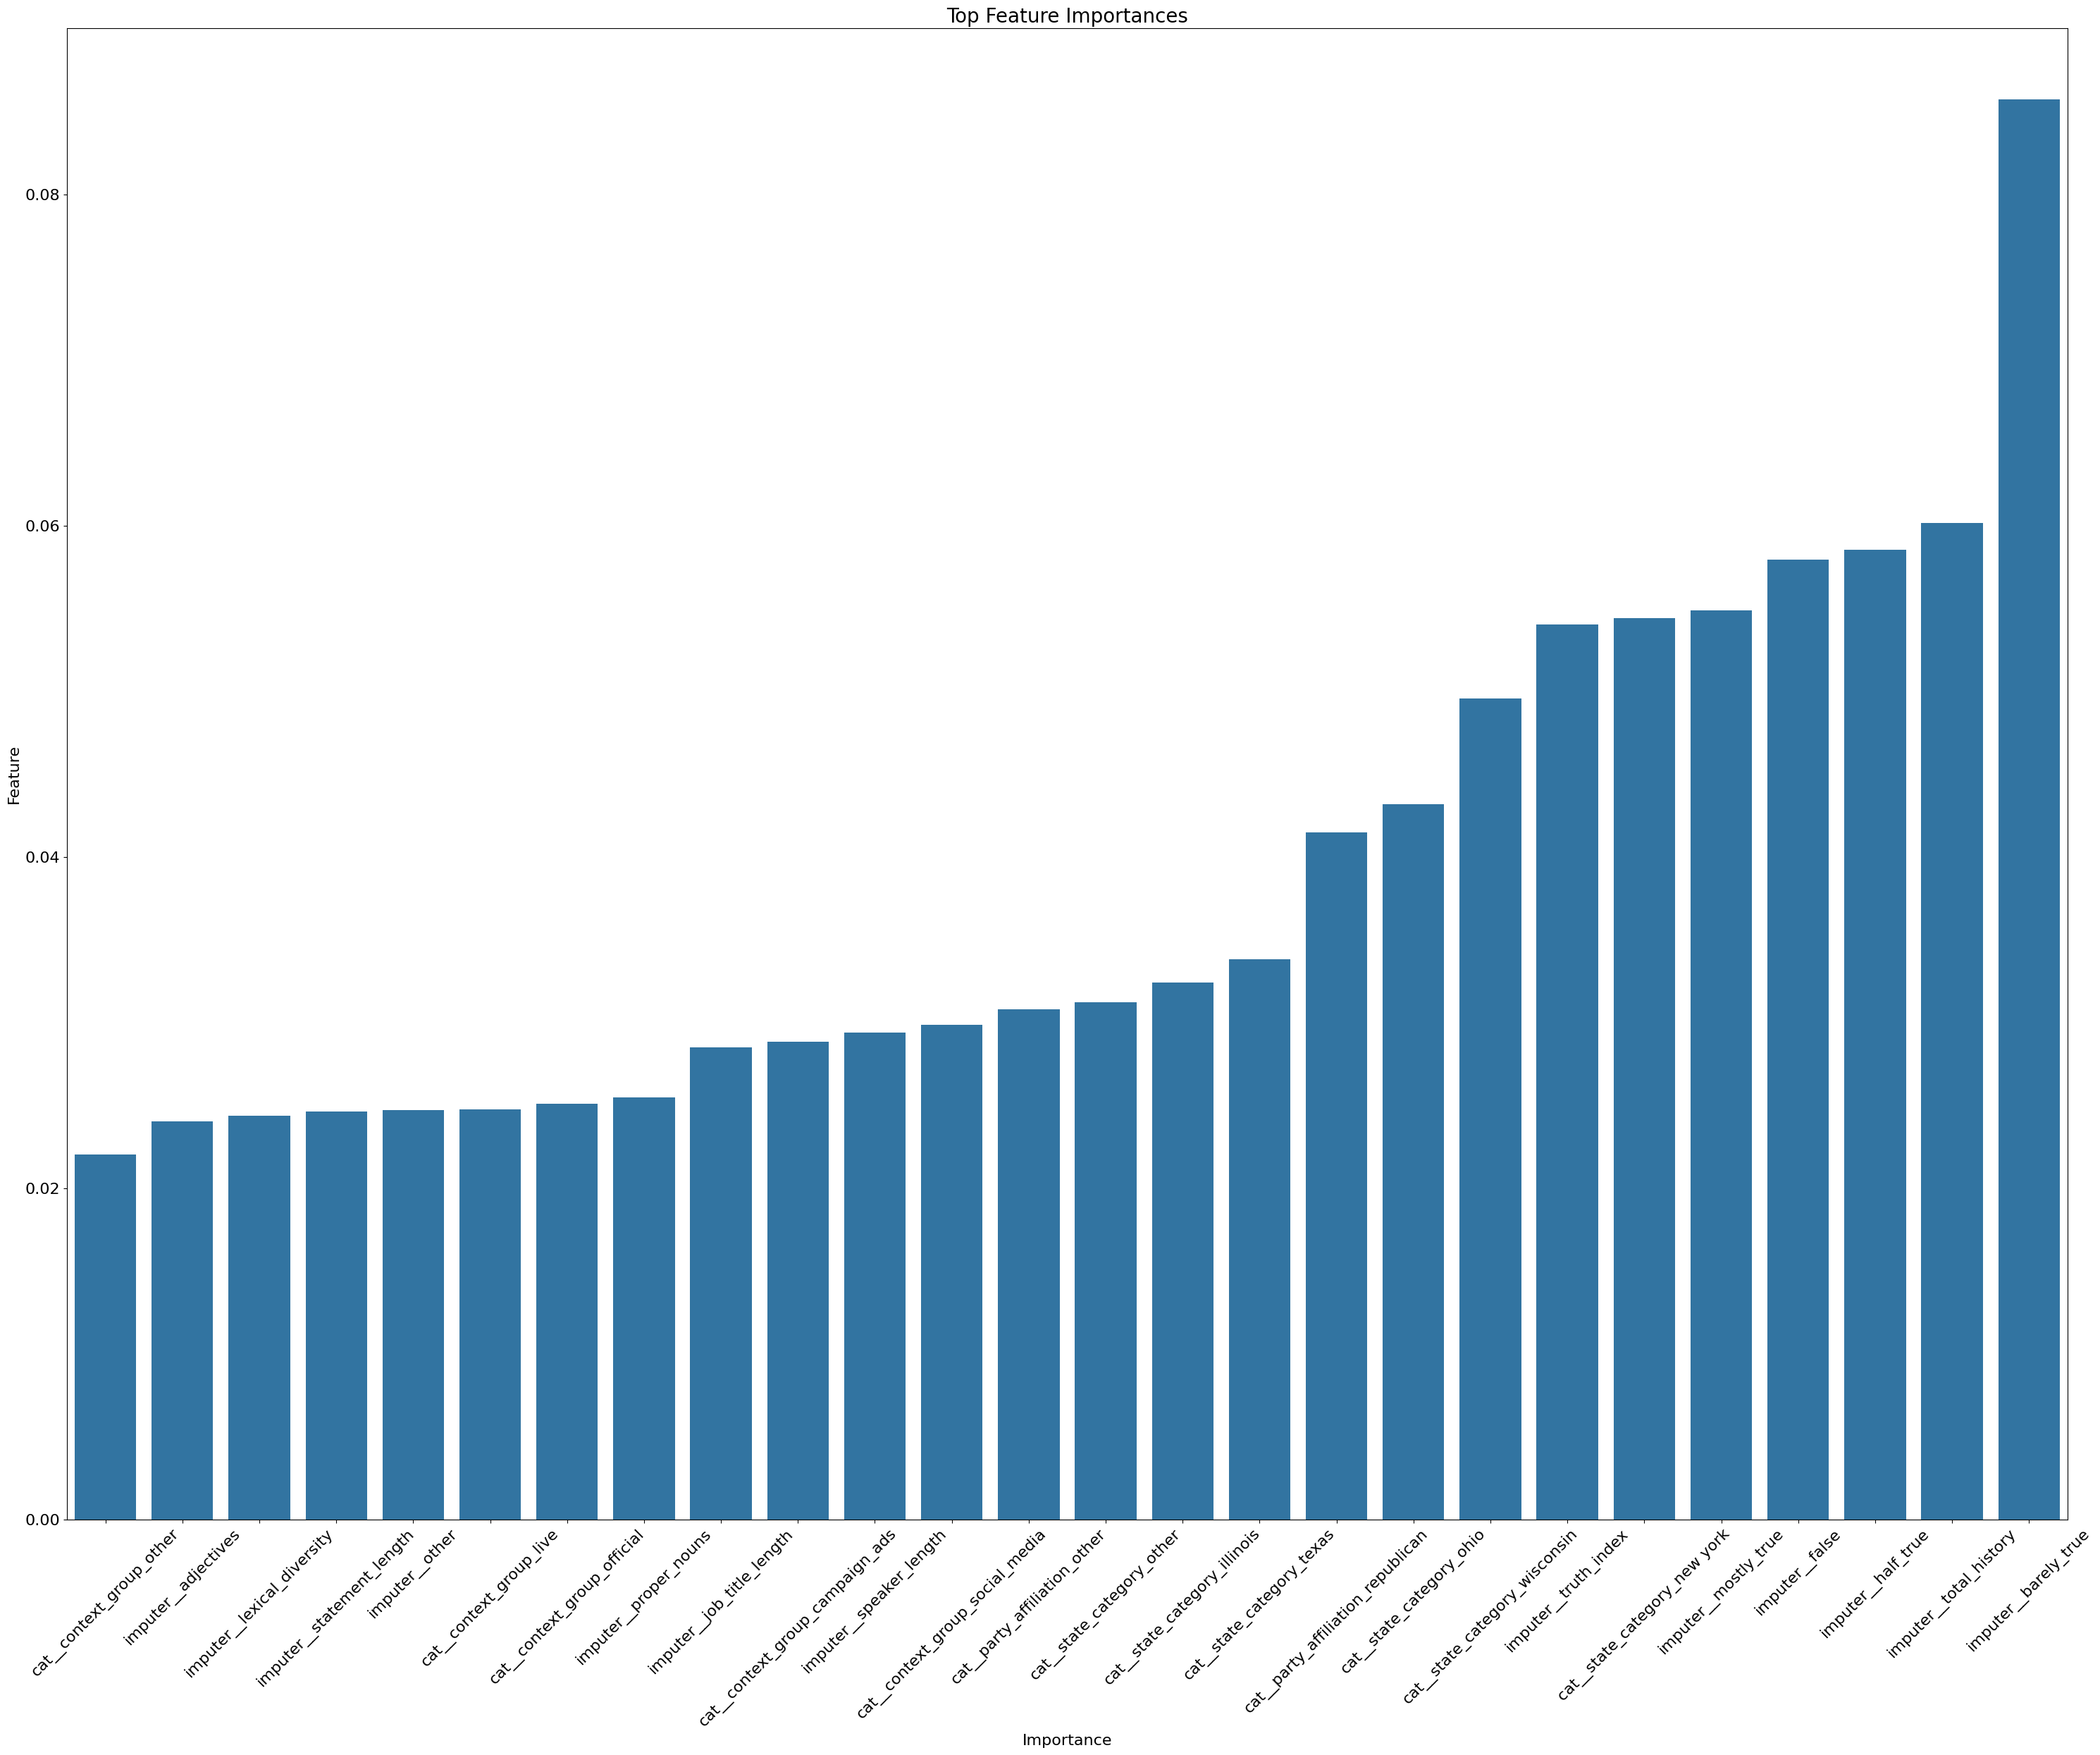

In [44]:
categorical_cols = ['context_group', 'state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])
model = grid_search(X_combined.drop(columns=['statement']), y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test.drop(columns=['statement'])), "XGBoost", model)
plot_feature_importances(model)

We got an incredible 0.634 f1 score, but all features seem to be important, maybe try removing one of the correlated features

Fitting 1 folds for each of 72 candidates, totalling 72 fits


d:\ML\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [14:47:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "num_classes" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 Score: 0.615


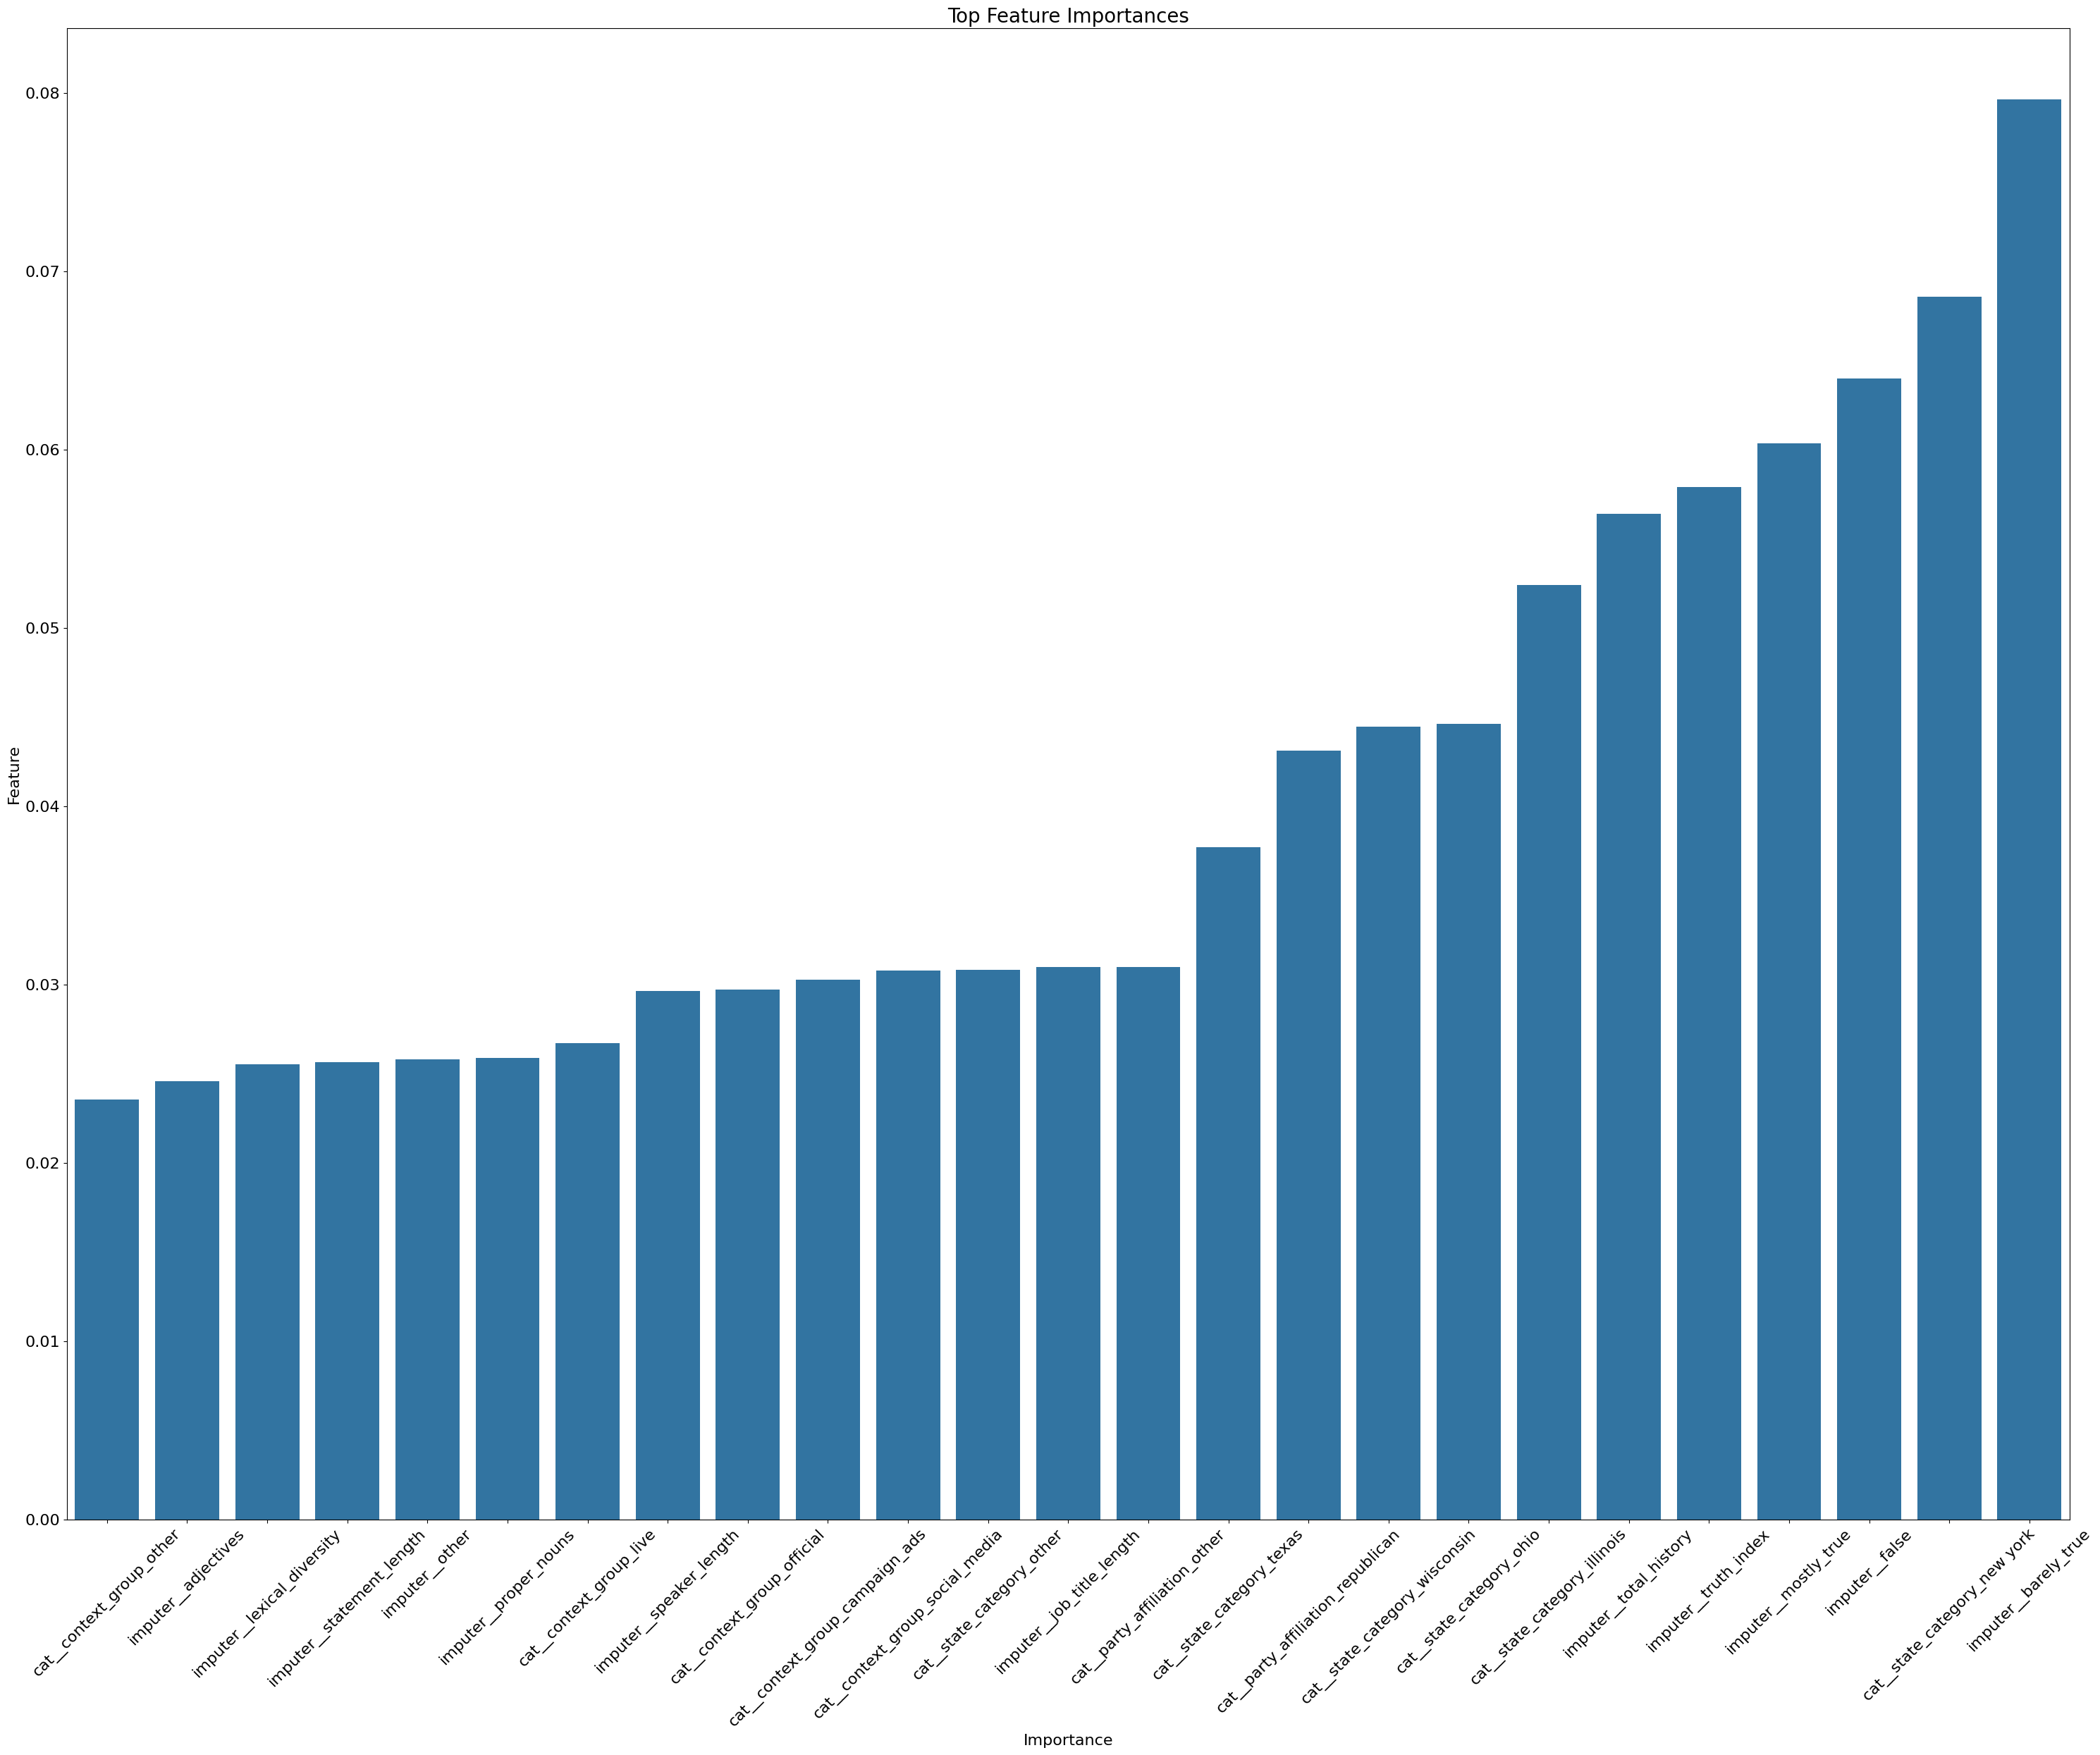

In [45]:
categorical_cols = ['context_group', 'state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('half_true')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_cols),
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])
model = grid_search(X_combined.drop(columns=['statement']), y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test.drop(columns=['statement'])), "XGBoost", model)
plot_feature_importances(model)

We actually see a slight decreasement in performance

Let us try adding back the half-true column

Fitting 1 folds for each of 72 candidates, totalling 72 fits


d:\ML\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:20:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "num_classes" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 Score: 0.640


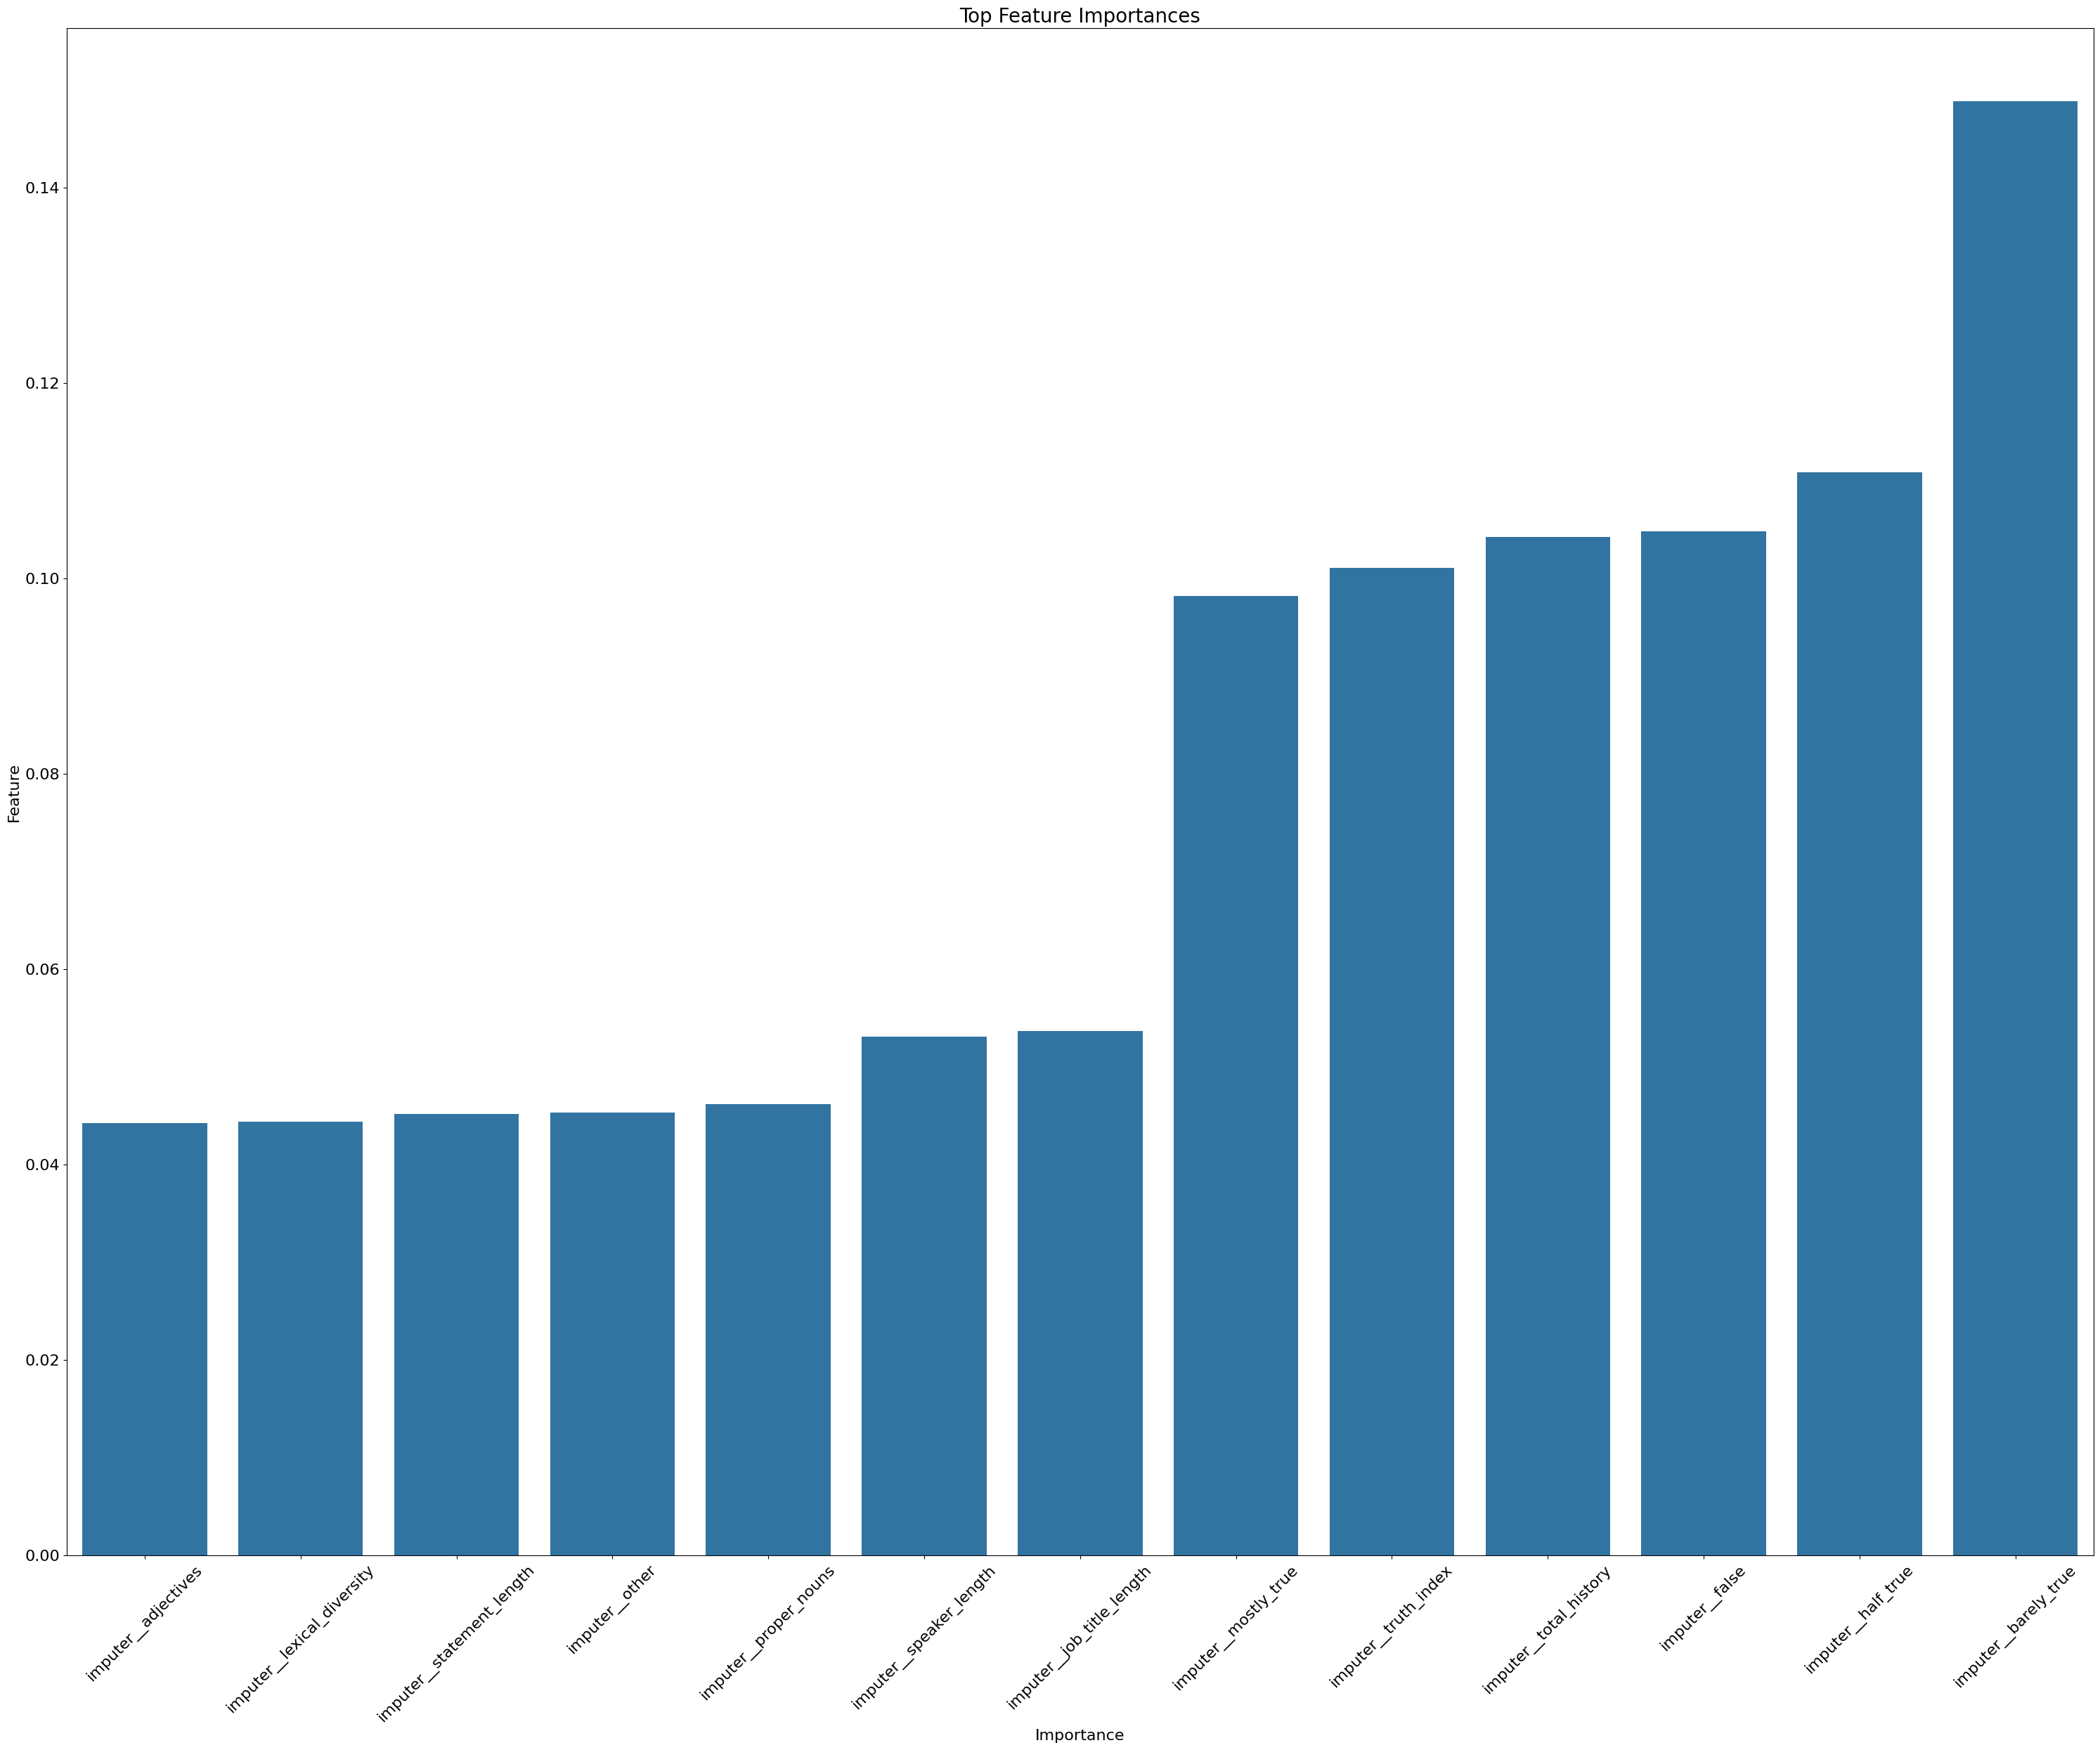

In [47]:

numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])
model = grid_search(X_combined.drop(columns=['statement']), y_combined, pipeline)[0]
calculate_metrics(y_test, model.predict(X_test.drop(columns=['statement'])), "XGBoost", model)
plot_feature_importances(model)

We got a very good score, we will see what the best params are

In [48]:
print(report)

[{'model': 'Baseline(predicting the most common class)', 'n_estimators': None, 'max_depth': None, 'learning_rate': None, 'subsample': None, 'accuracy': 0.20537878195606285, 'precision': 0.04218044407775601, 'recall': 0.20537878195606285, 'f1': 0.06998703595778663}, {'model': 'XGBoost', 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 1.0, 'accuracy': 0.6377269139700079, 'precision': 0.6420560032952244, 'recall': 0.6377269139700079, 'f1': 0.6342106055305459}, {'model': 'XGBoost', 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 1.0, 'accuracy': 0.6172059984214681, 'precision': 0.6207405356764489, 'recall': 0.6172059984214681, 'f1': 0.6152388349333956}, {'model': 'XGBoost', 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 1.0, 'accuracy': 0.6203630623520127, 'precision': 0.625025280707516, 'recall': 0.6203630623520127, 'f1': 0.618669333118958}, {'model': 'XGBoost', 'n_estimators': 300, 'max_depth': 10, 'learning_rate

In [49]:
best_model = XGBClassifier(random_state=42, n_estimators=300, max_depth=10, learning_rate=0.1, subsample=1, n_jobs=-1, num_classes = 6)

We see an imporved performance, but let us try removing other columns

d:\ML\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:25:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "num_classes" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 Score: 0.588


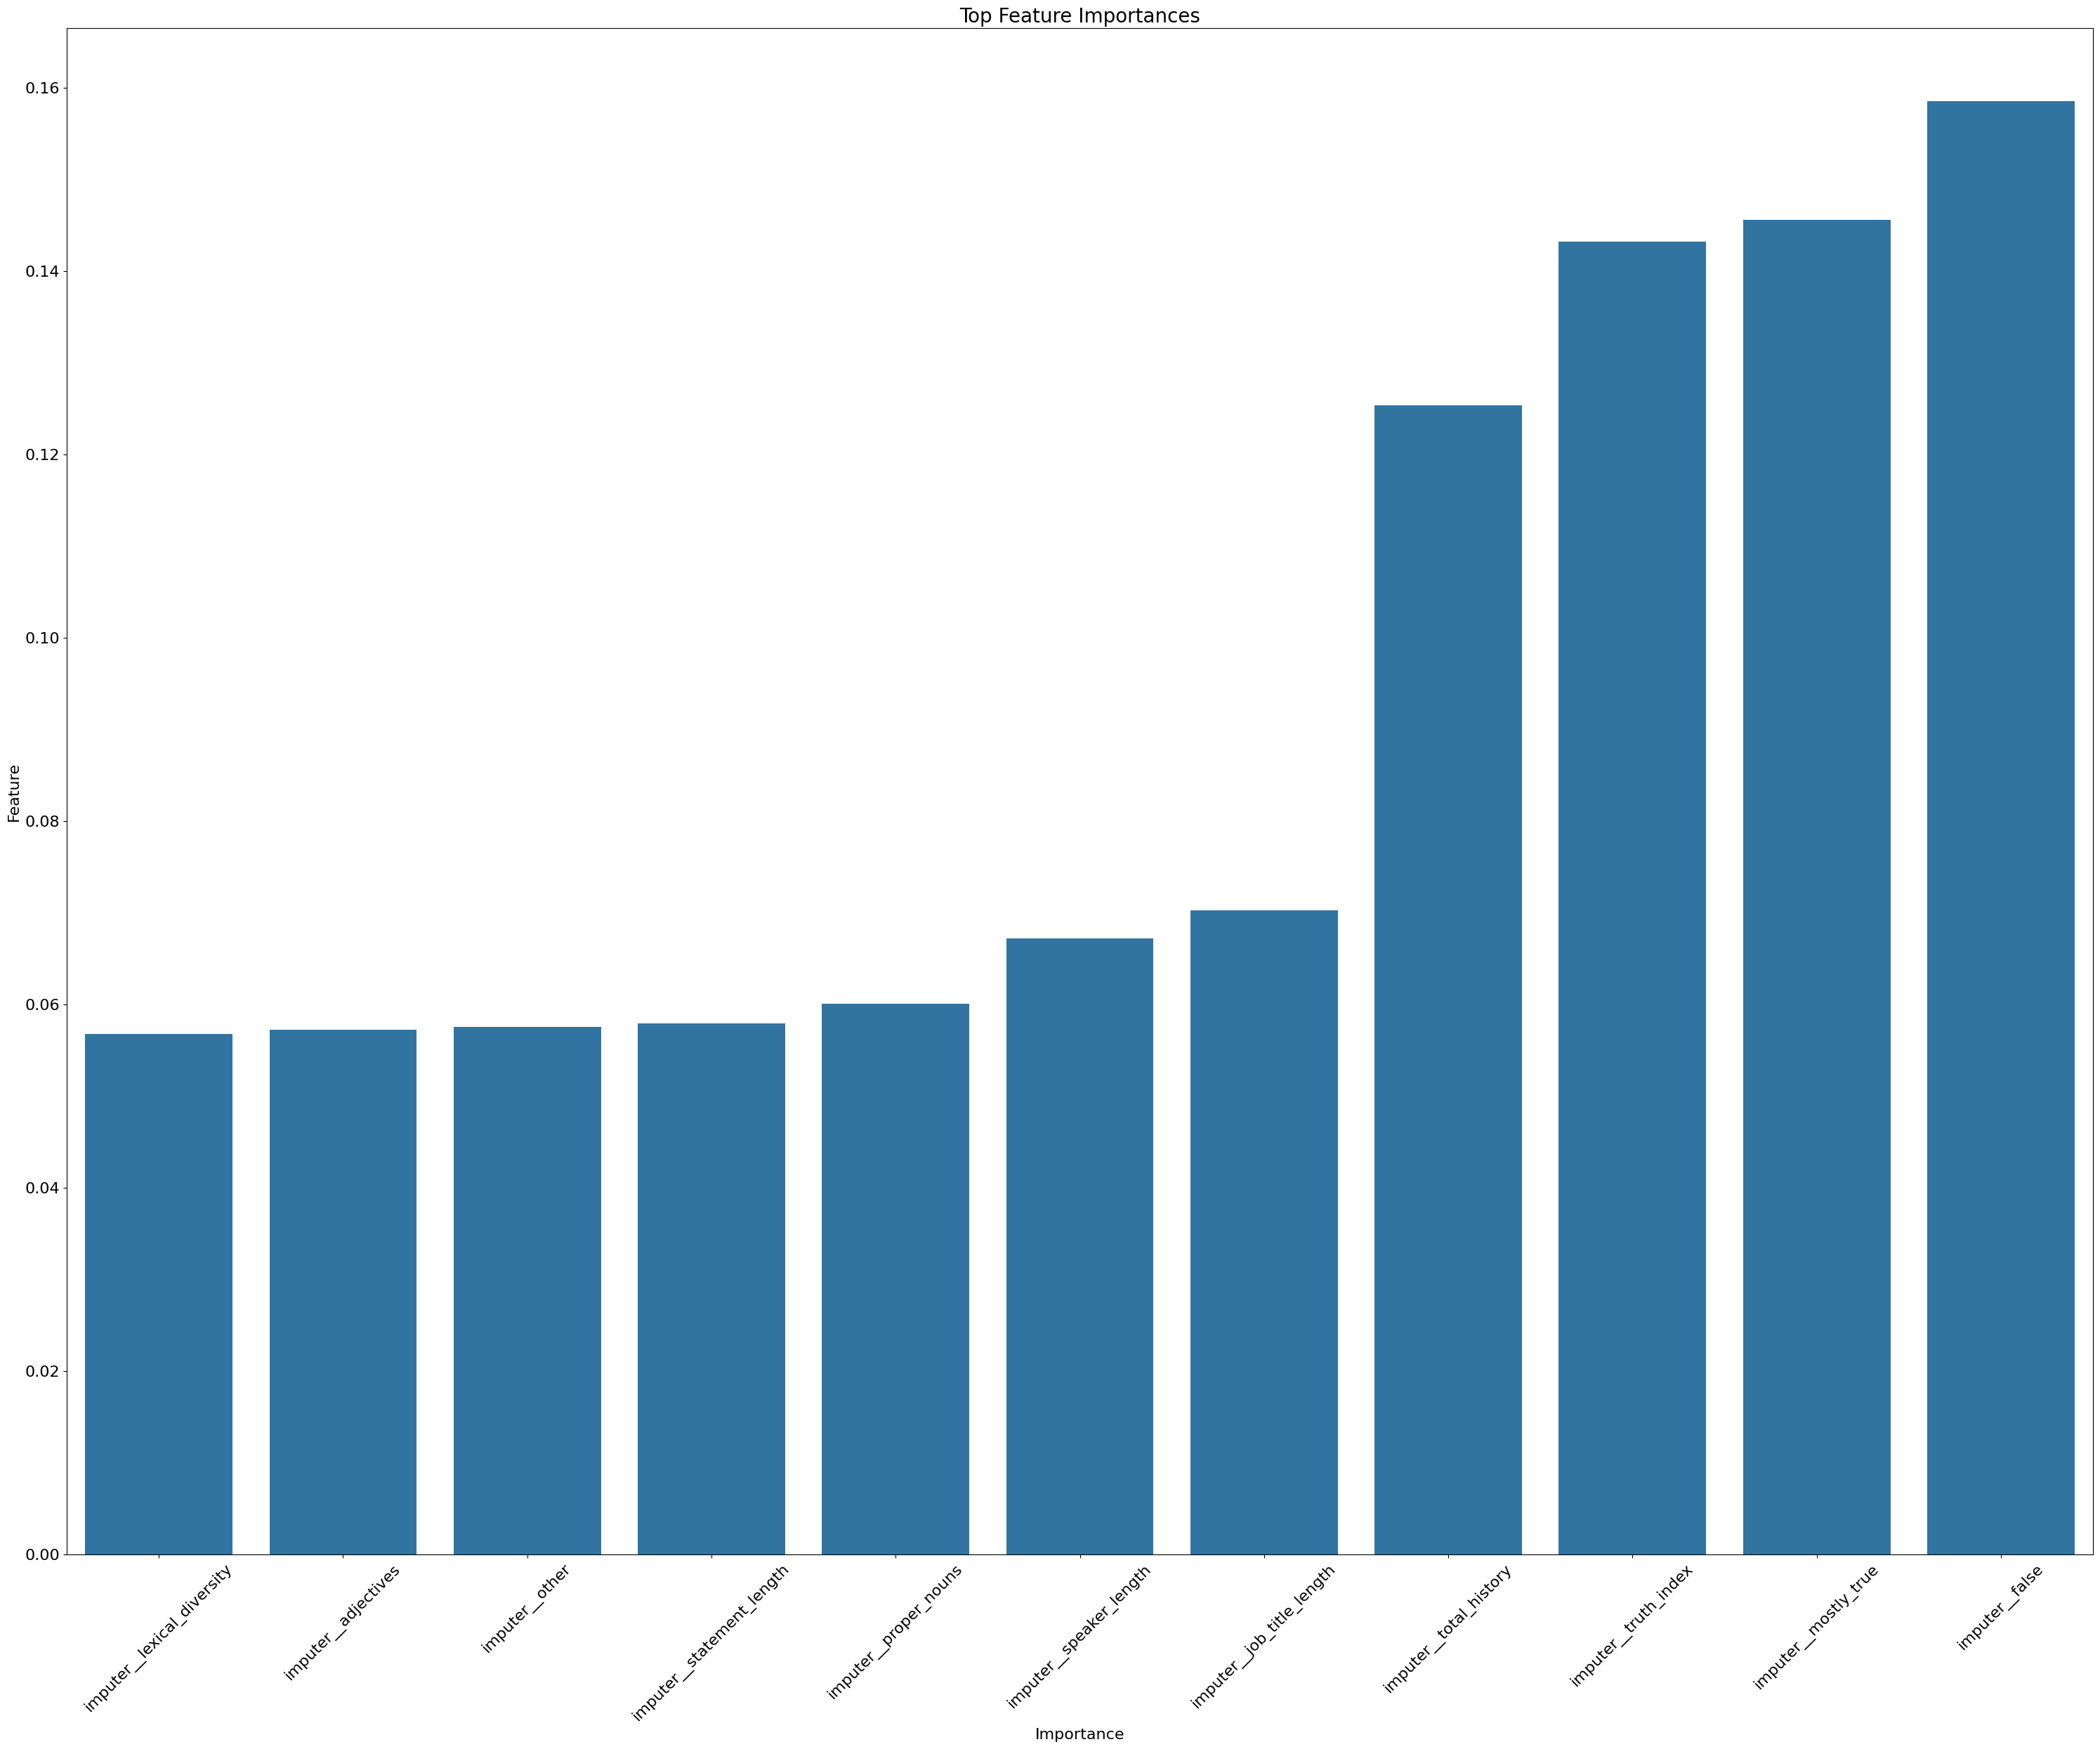

In [54]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('half_true')
numerical_cols.remove('barely_true')
preprocessor = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

A decrease so we should stick with one of the removed cols, let us try with half_true

d:\ML\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:26:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "num_classes" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 Score: 0.619


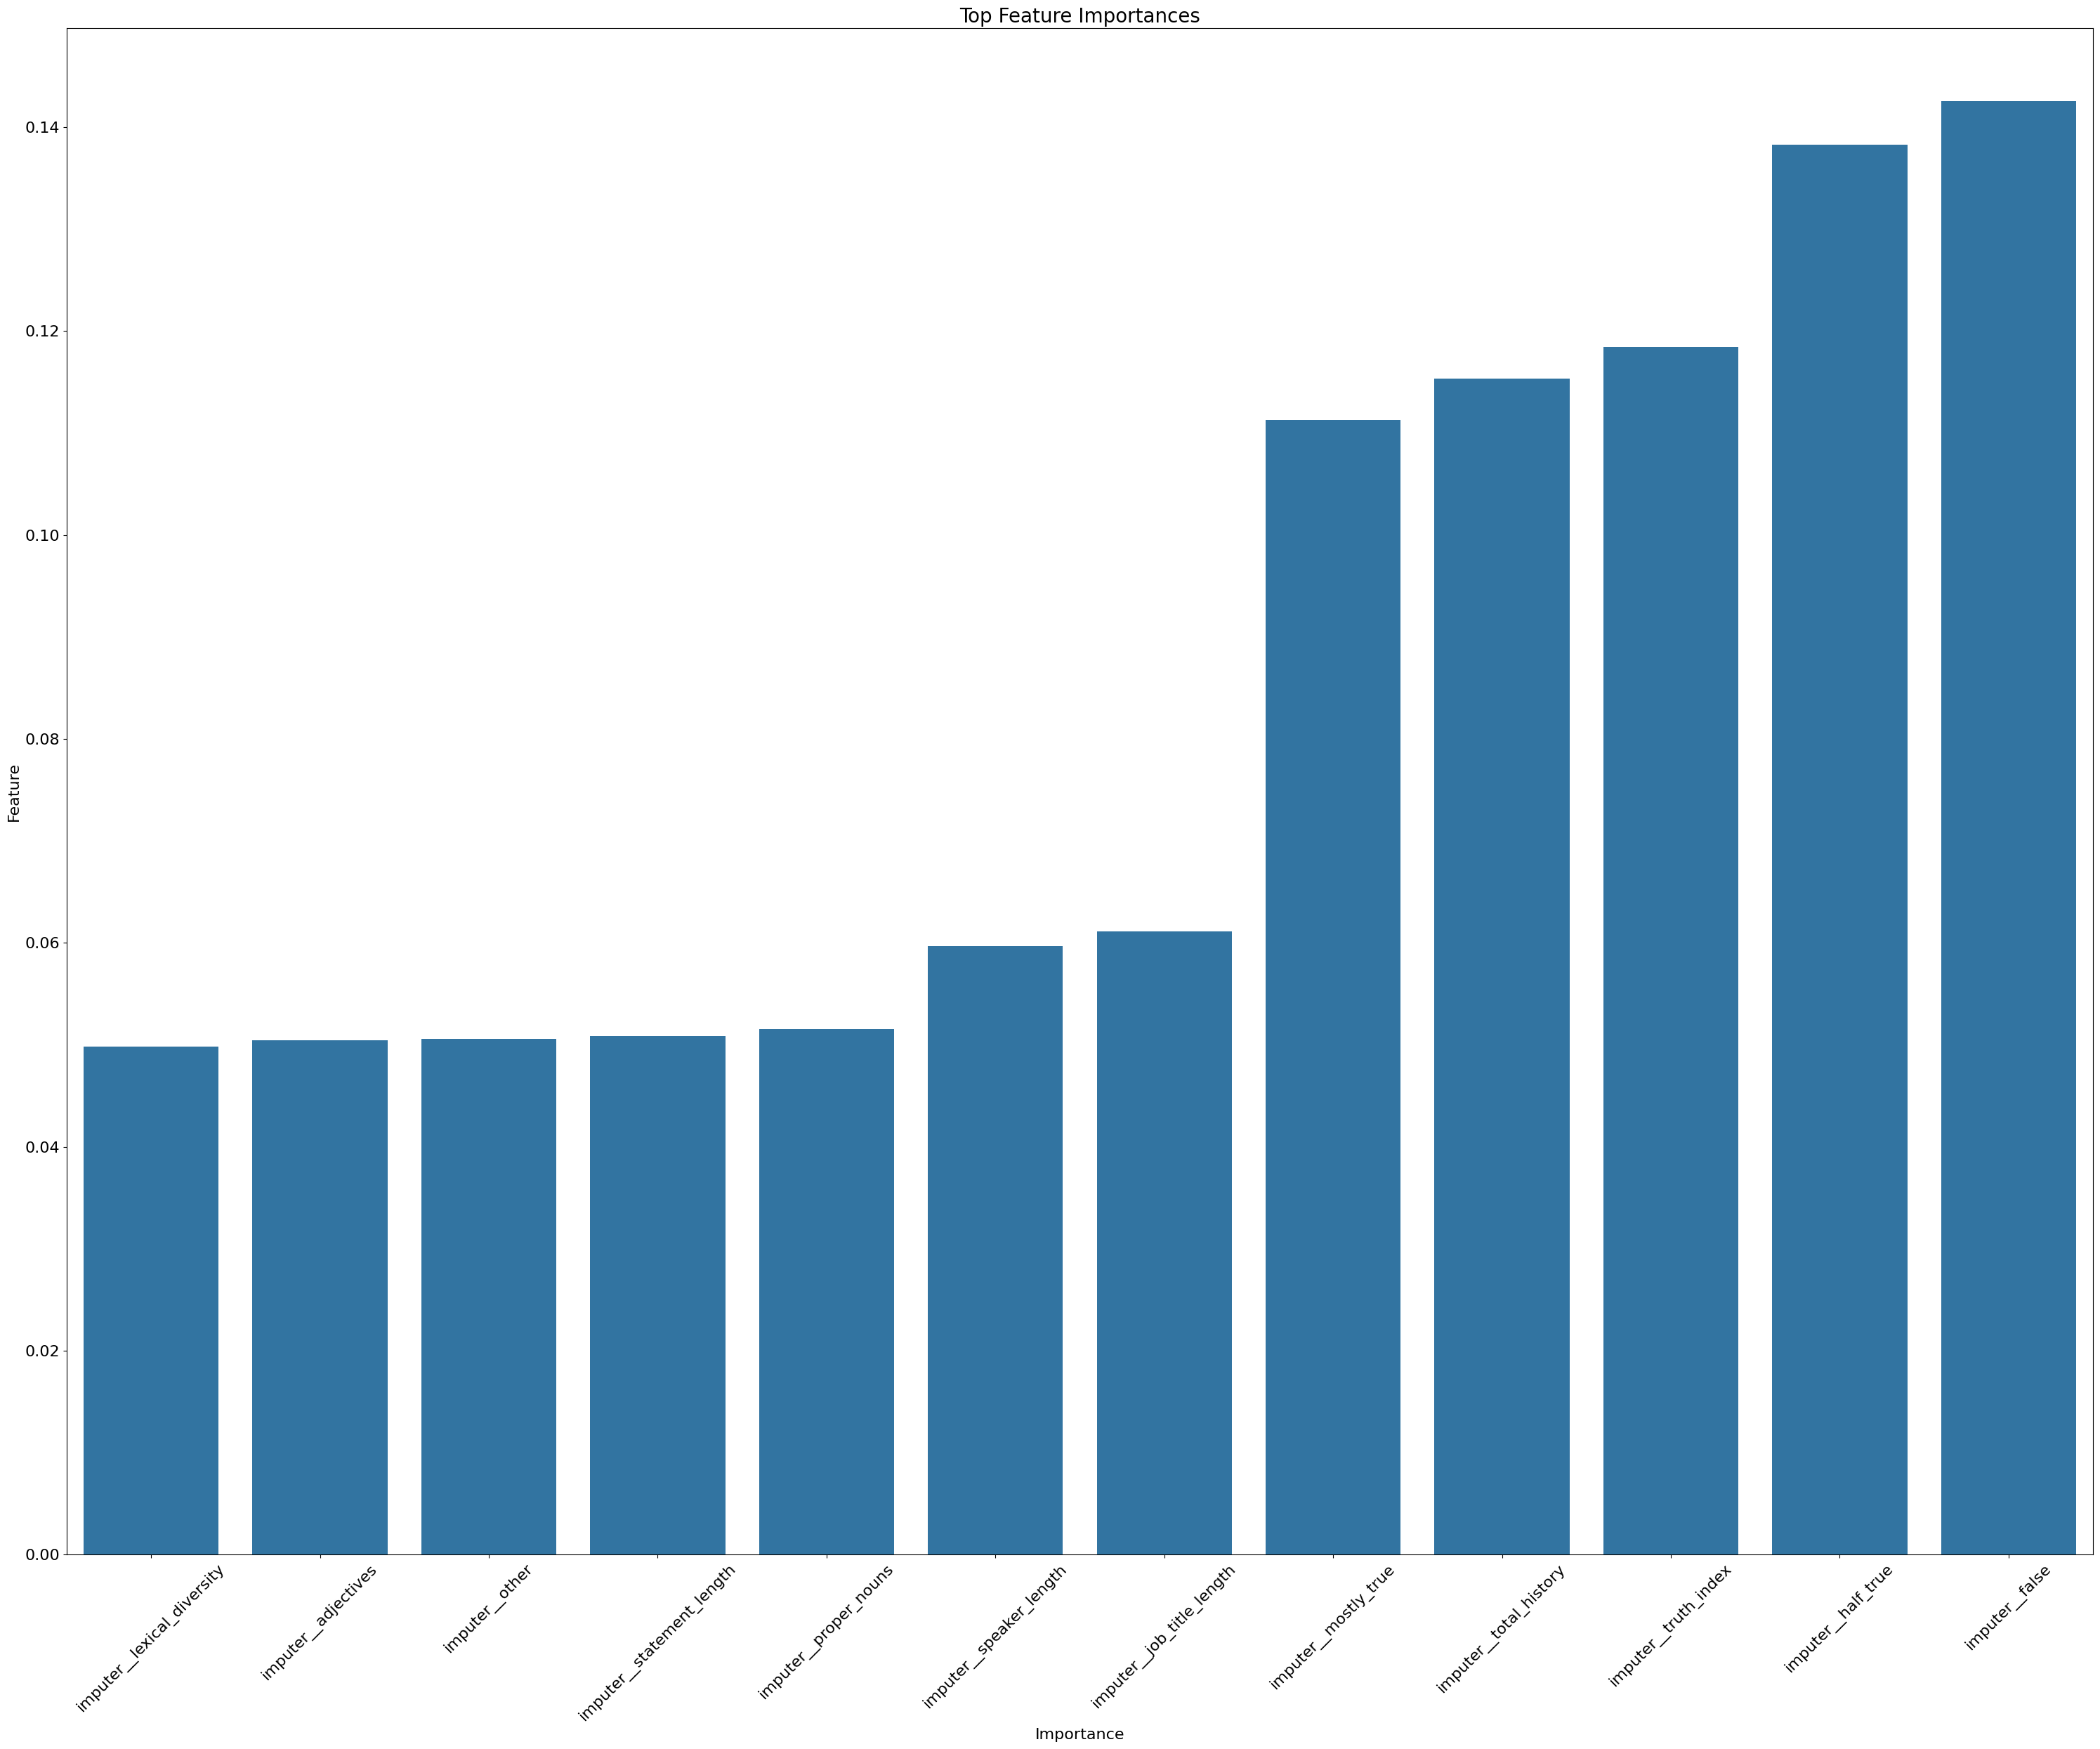

In [55]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('barely_true')
preprocessor = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='median'), numerical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

So half_true should be removed, we should also try with at least one cat column

d:\ML\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:27:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "num_classes" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 Score: 0.598


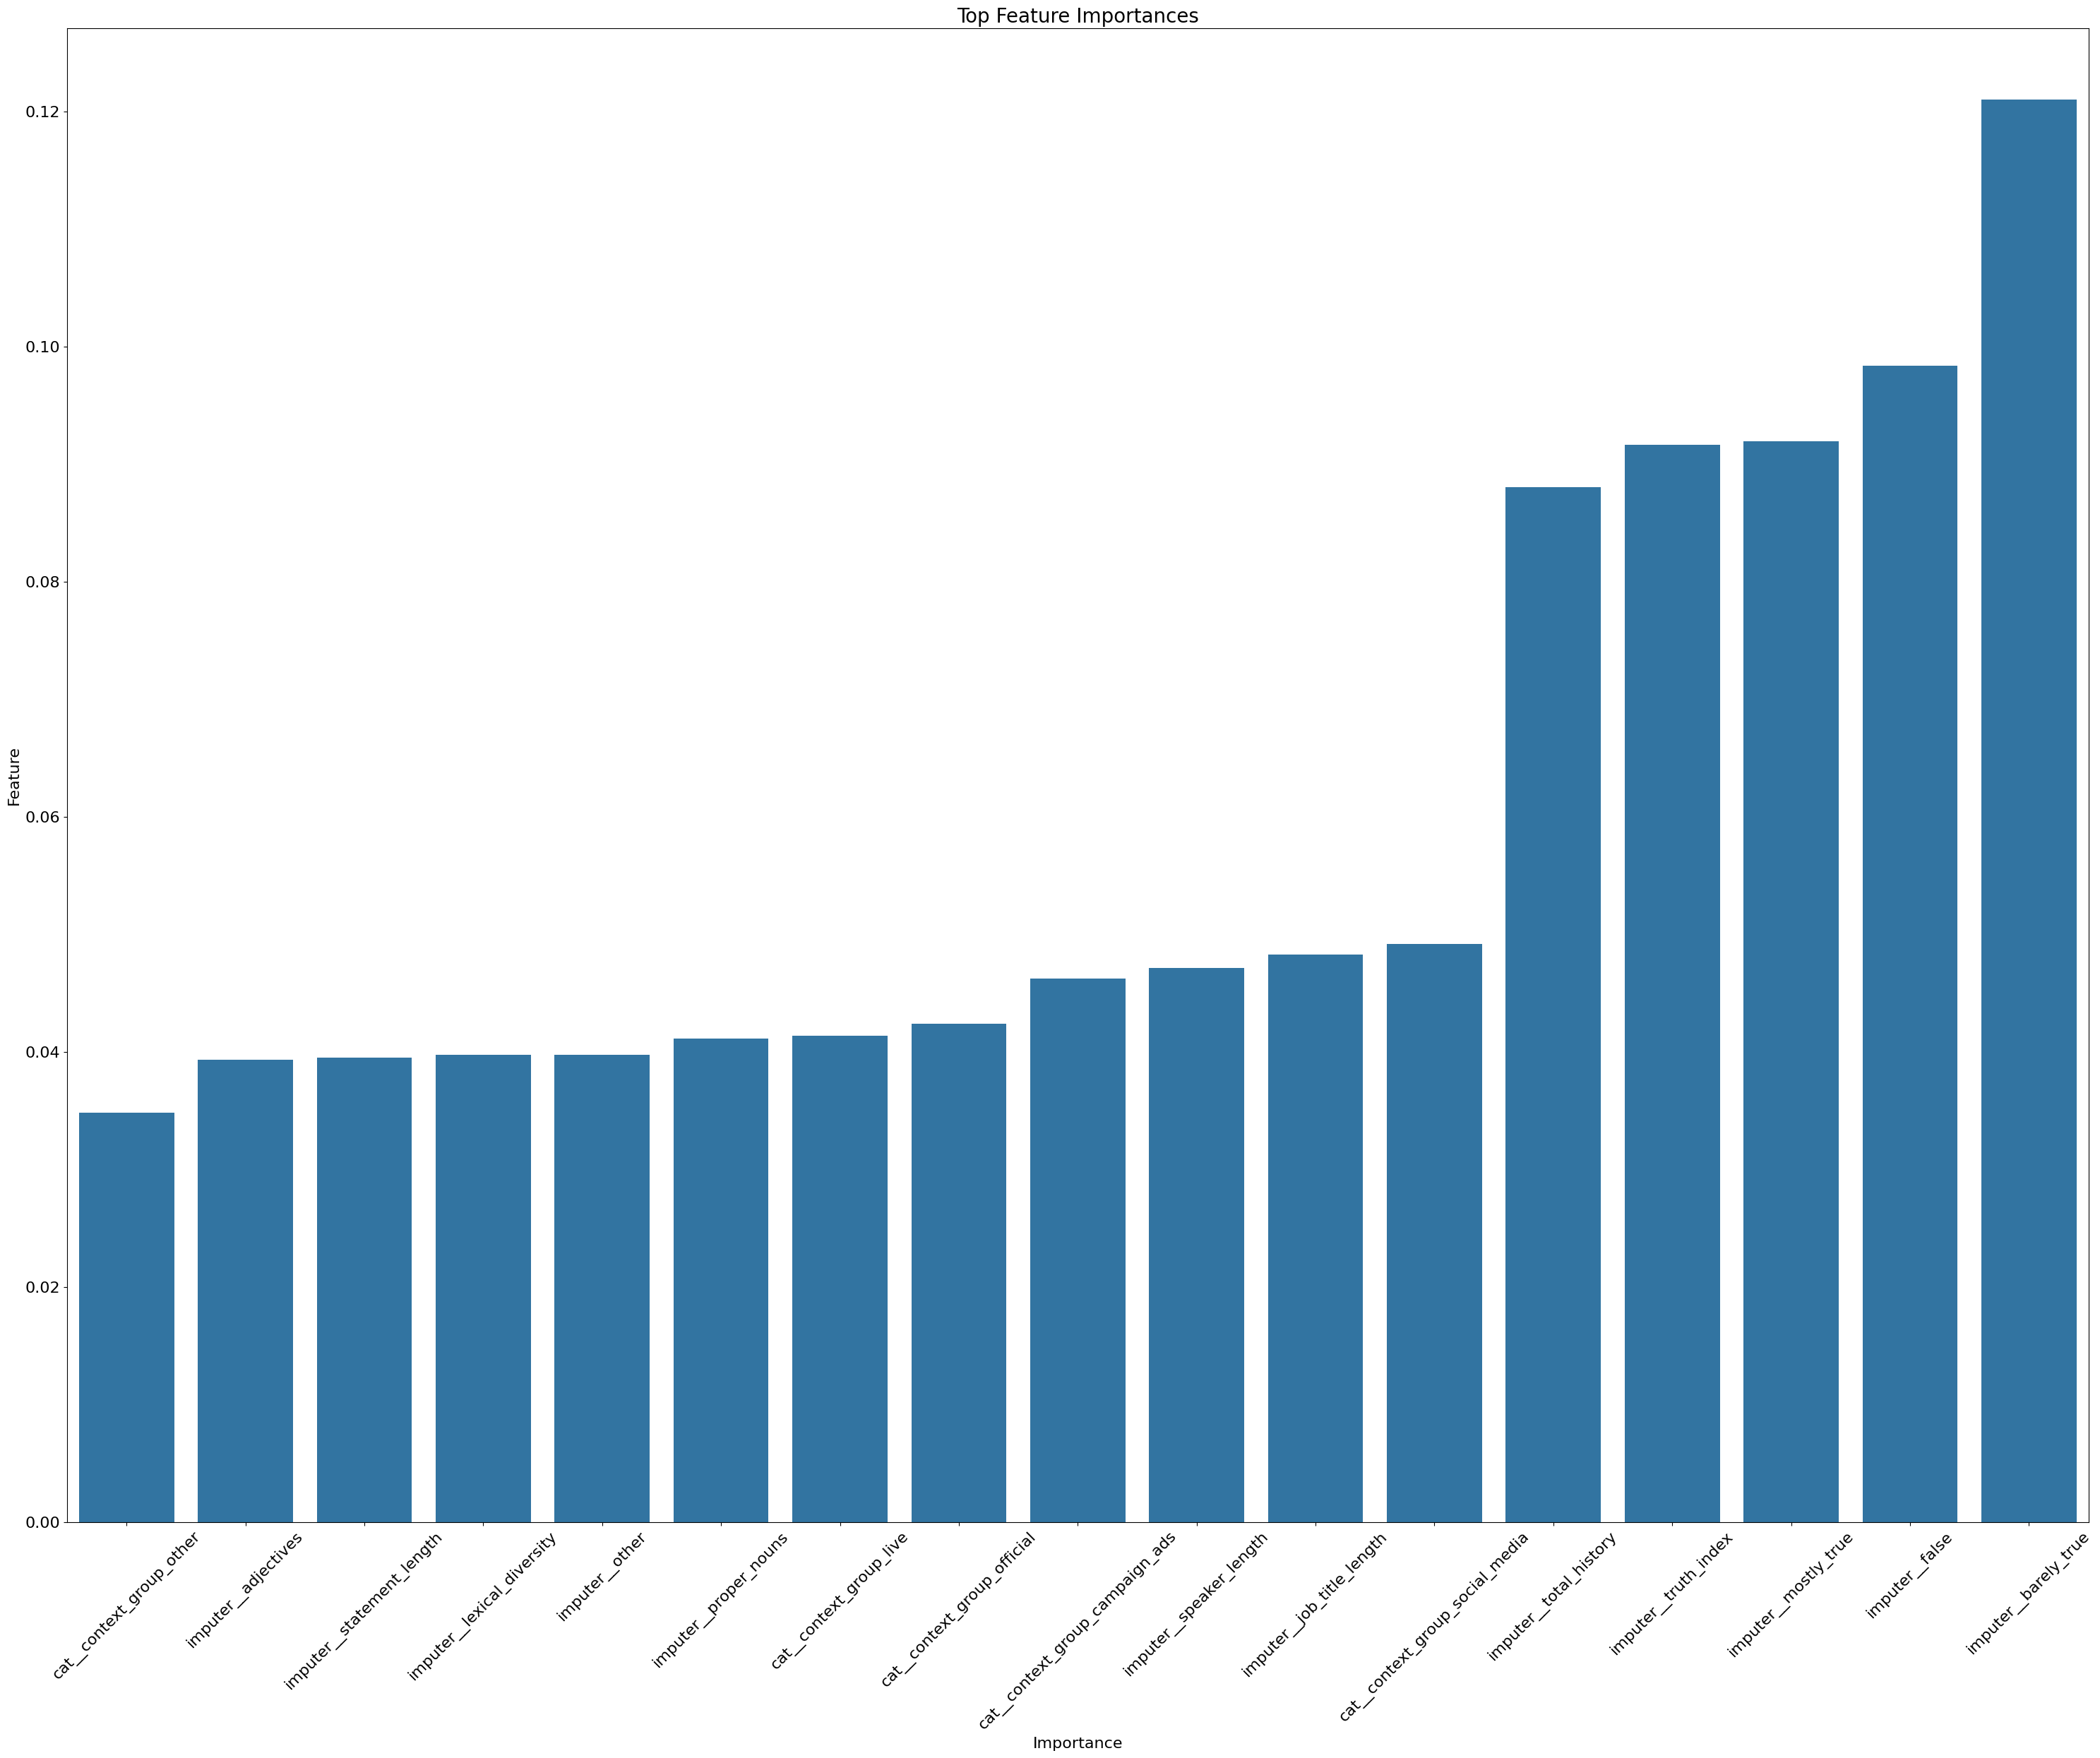

In [57]:
categorical_cols = ['context_group']
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('half_true')
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore',
                          drop='first'), categorical_cols),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)
],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

d:\ML\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:28:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "num_classes" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 Score: 0.603


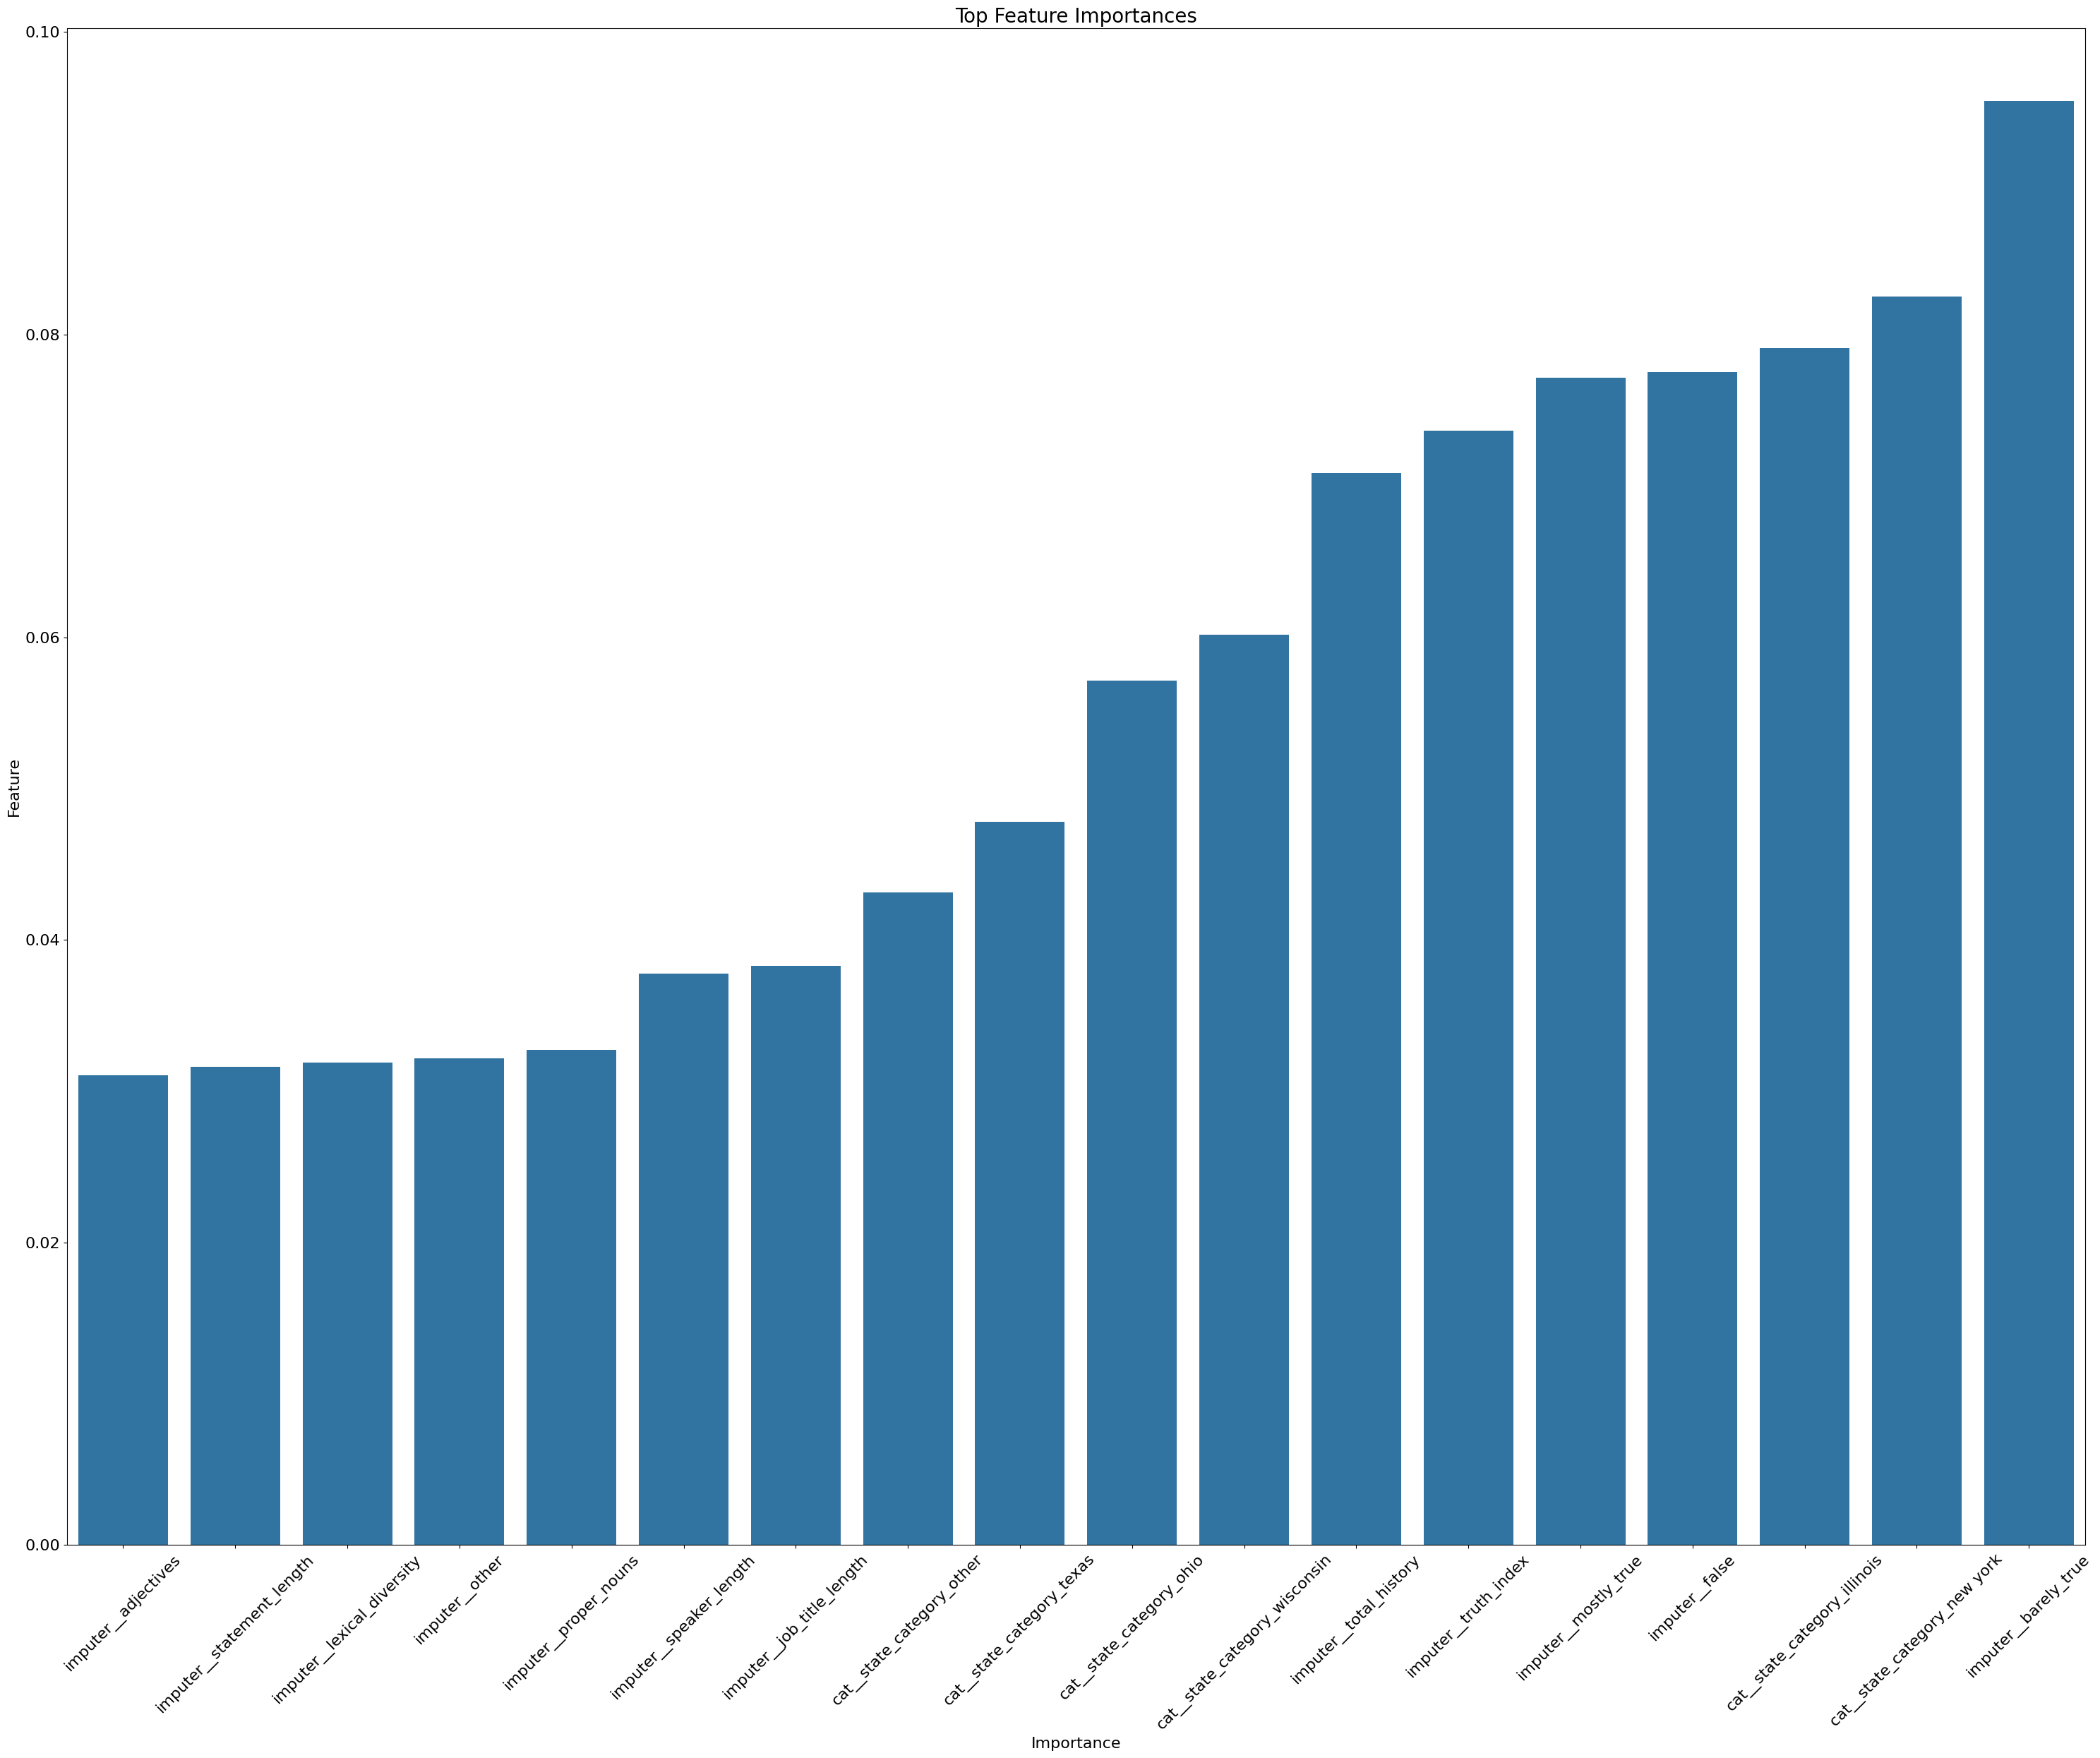

In [58]:
categorical_cols = ['state_category']
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('half_true')
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore',
                          drop='first'), categorical_cols),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)
],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

d:\ML\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:28:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "num_classes" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 Score: 0.624


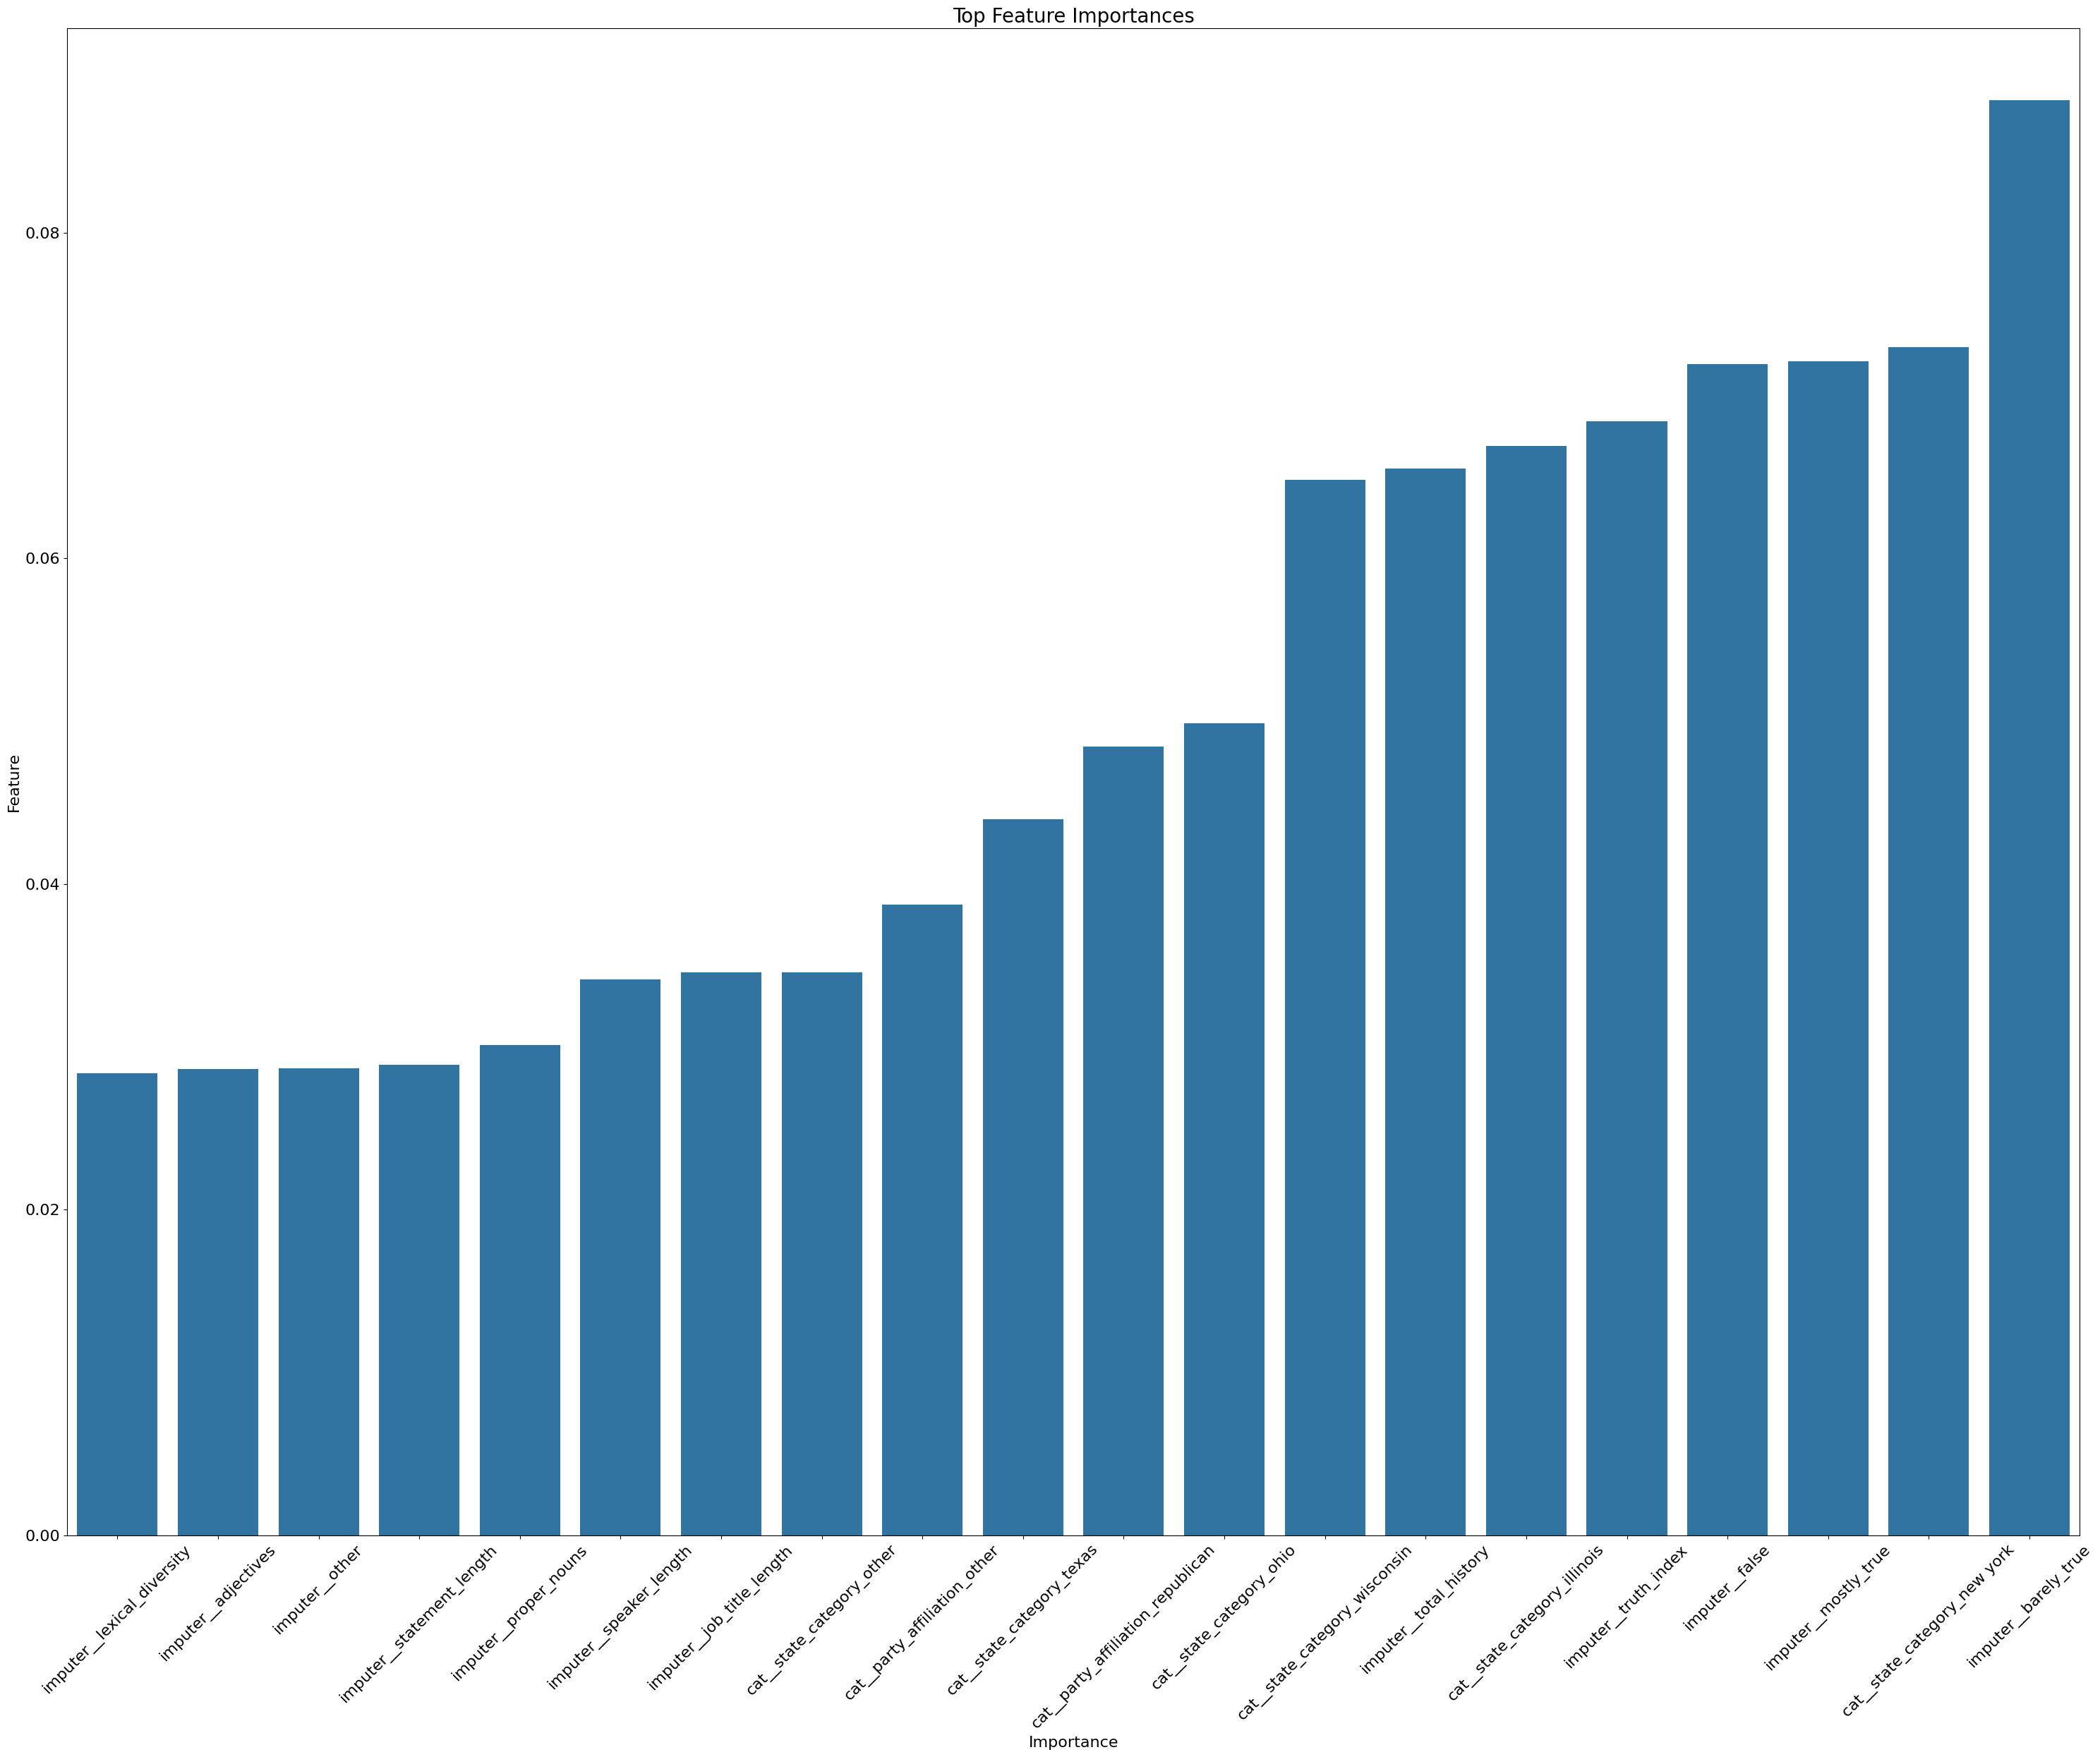

In [59]:
categorical_cols = ['state_category', 'party_affiliation']
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('half_true')
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore',
                          drop='first'), categorical_cols),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)
],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

d:\ML\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:29:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "num_classes" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 Score: 0.623


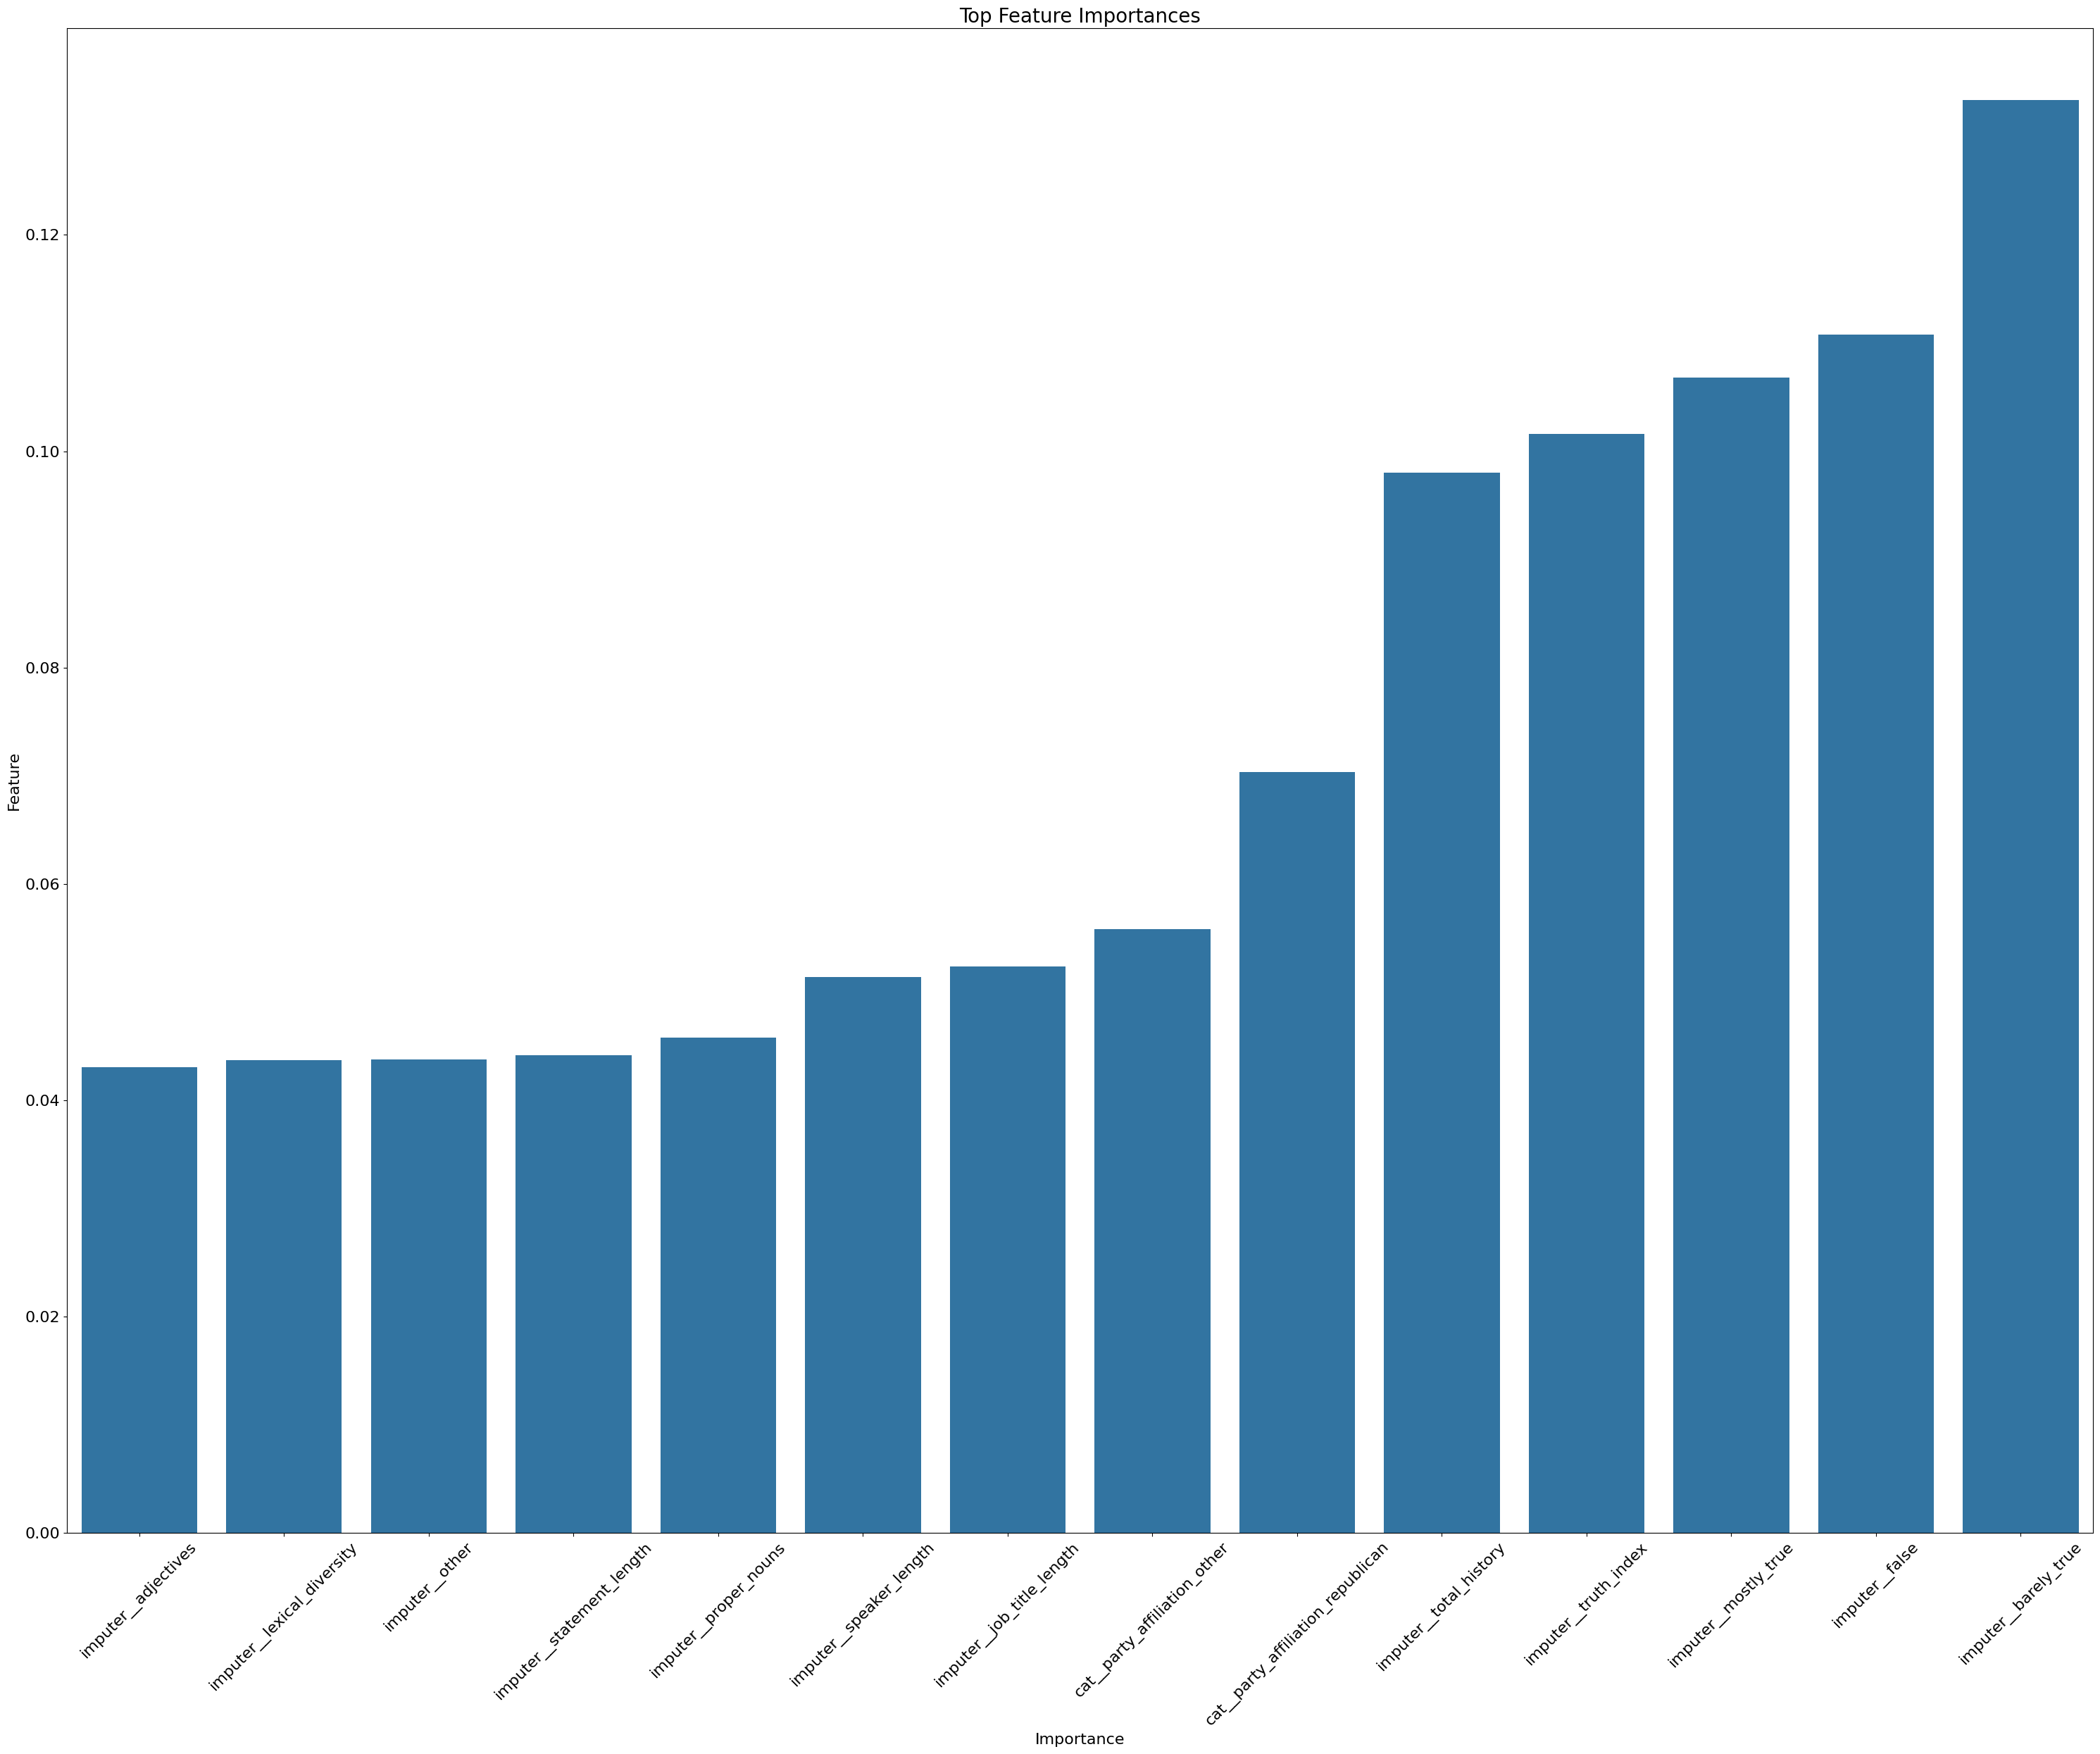

In [60]:
categorical_cols = ['party_affiliation']
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('half_true')
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore',
                          drop='first'), categorical_cols),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)
],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

It is maybe better to not use categorical cols. Let us now analyze the statement column

d:\ML\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:31:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "num_classes" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 Score: 0.237


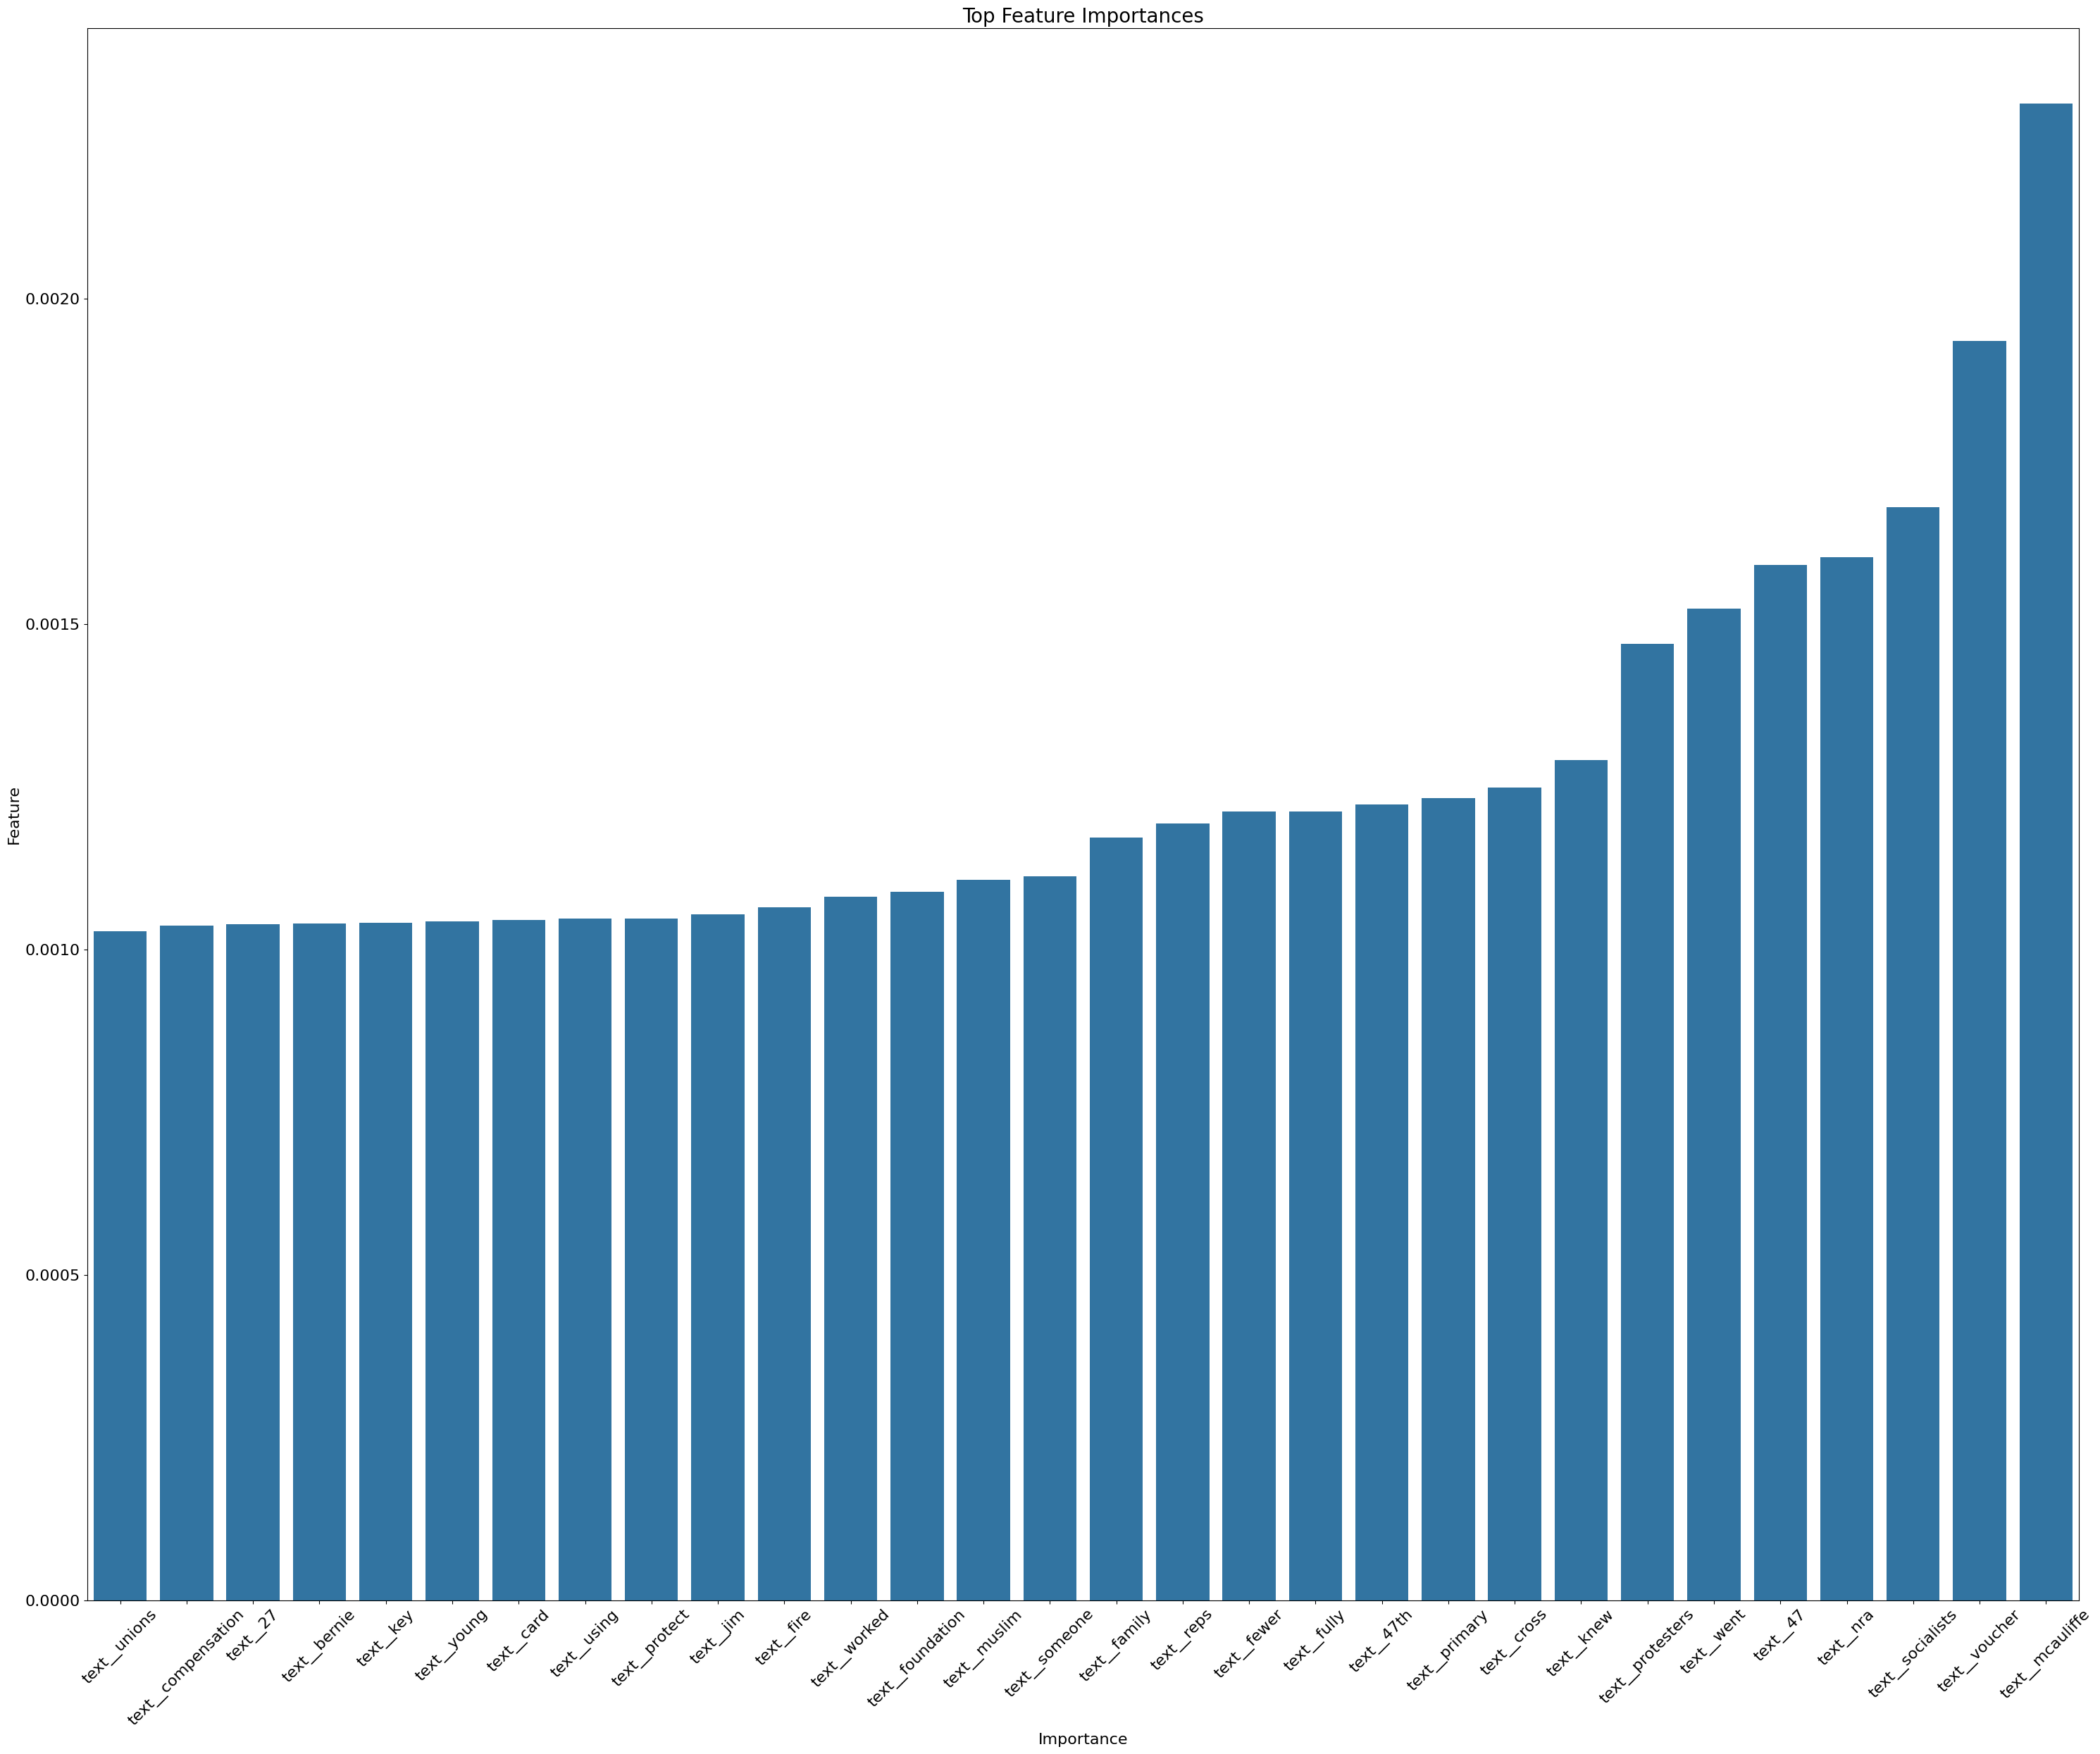

In [62]:
preprocessor = ColumnTransformer(transformers=[
    ('text', TfidfVectorizer(), 'statement'),
],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

d:\ML\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:32:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "num_classes" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 Score: 0.248


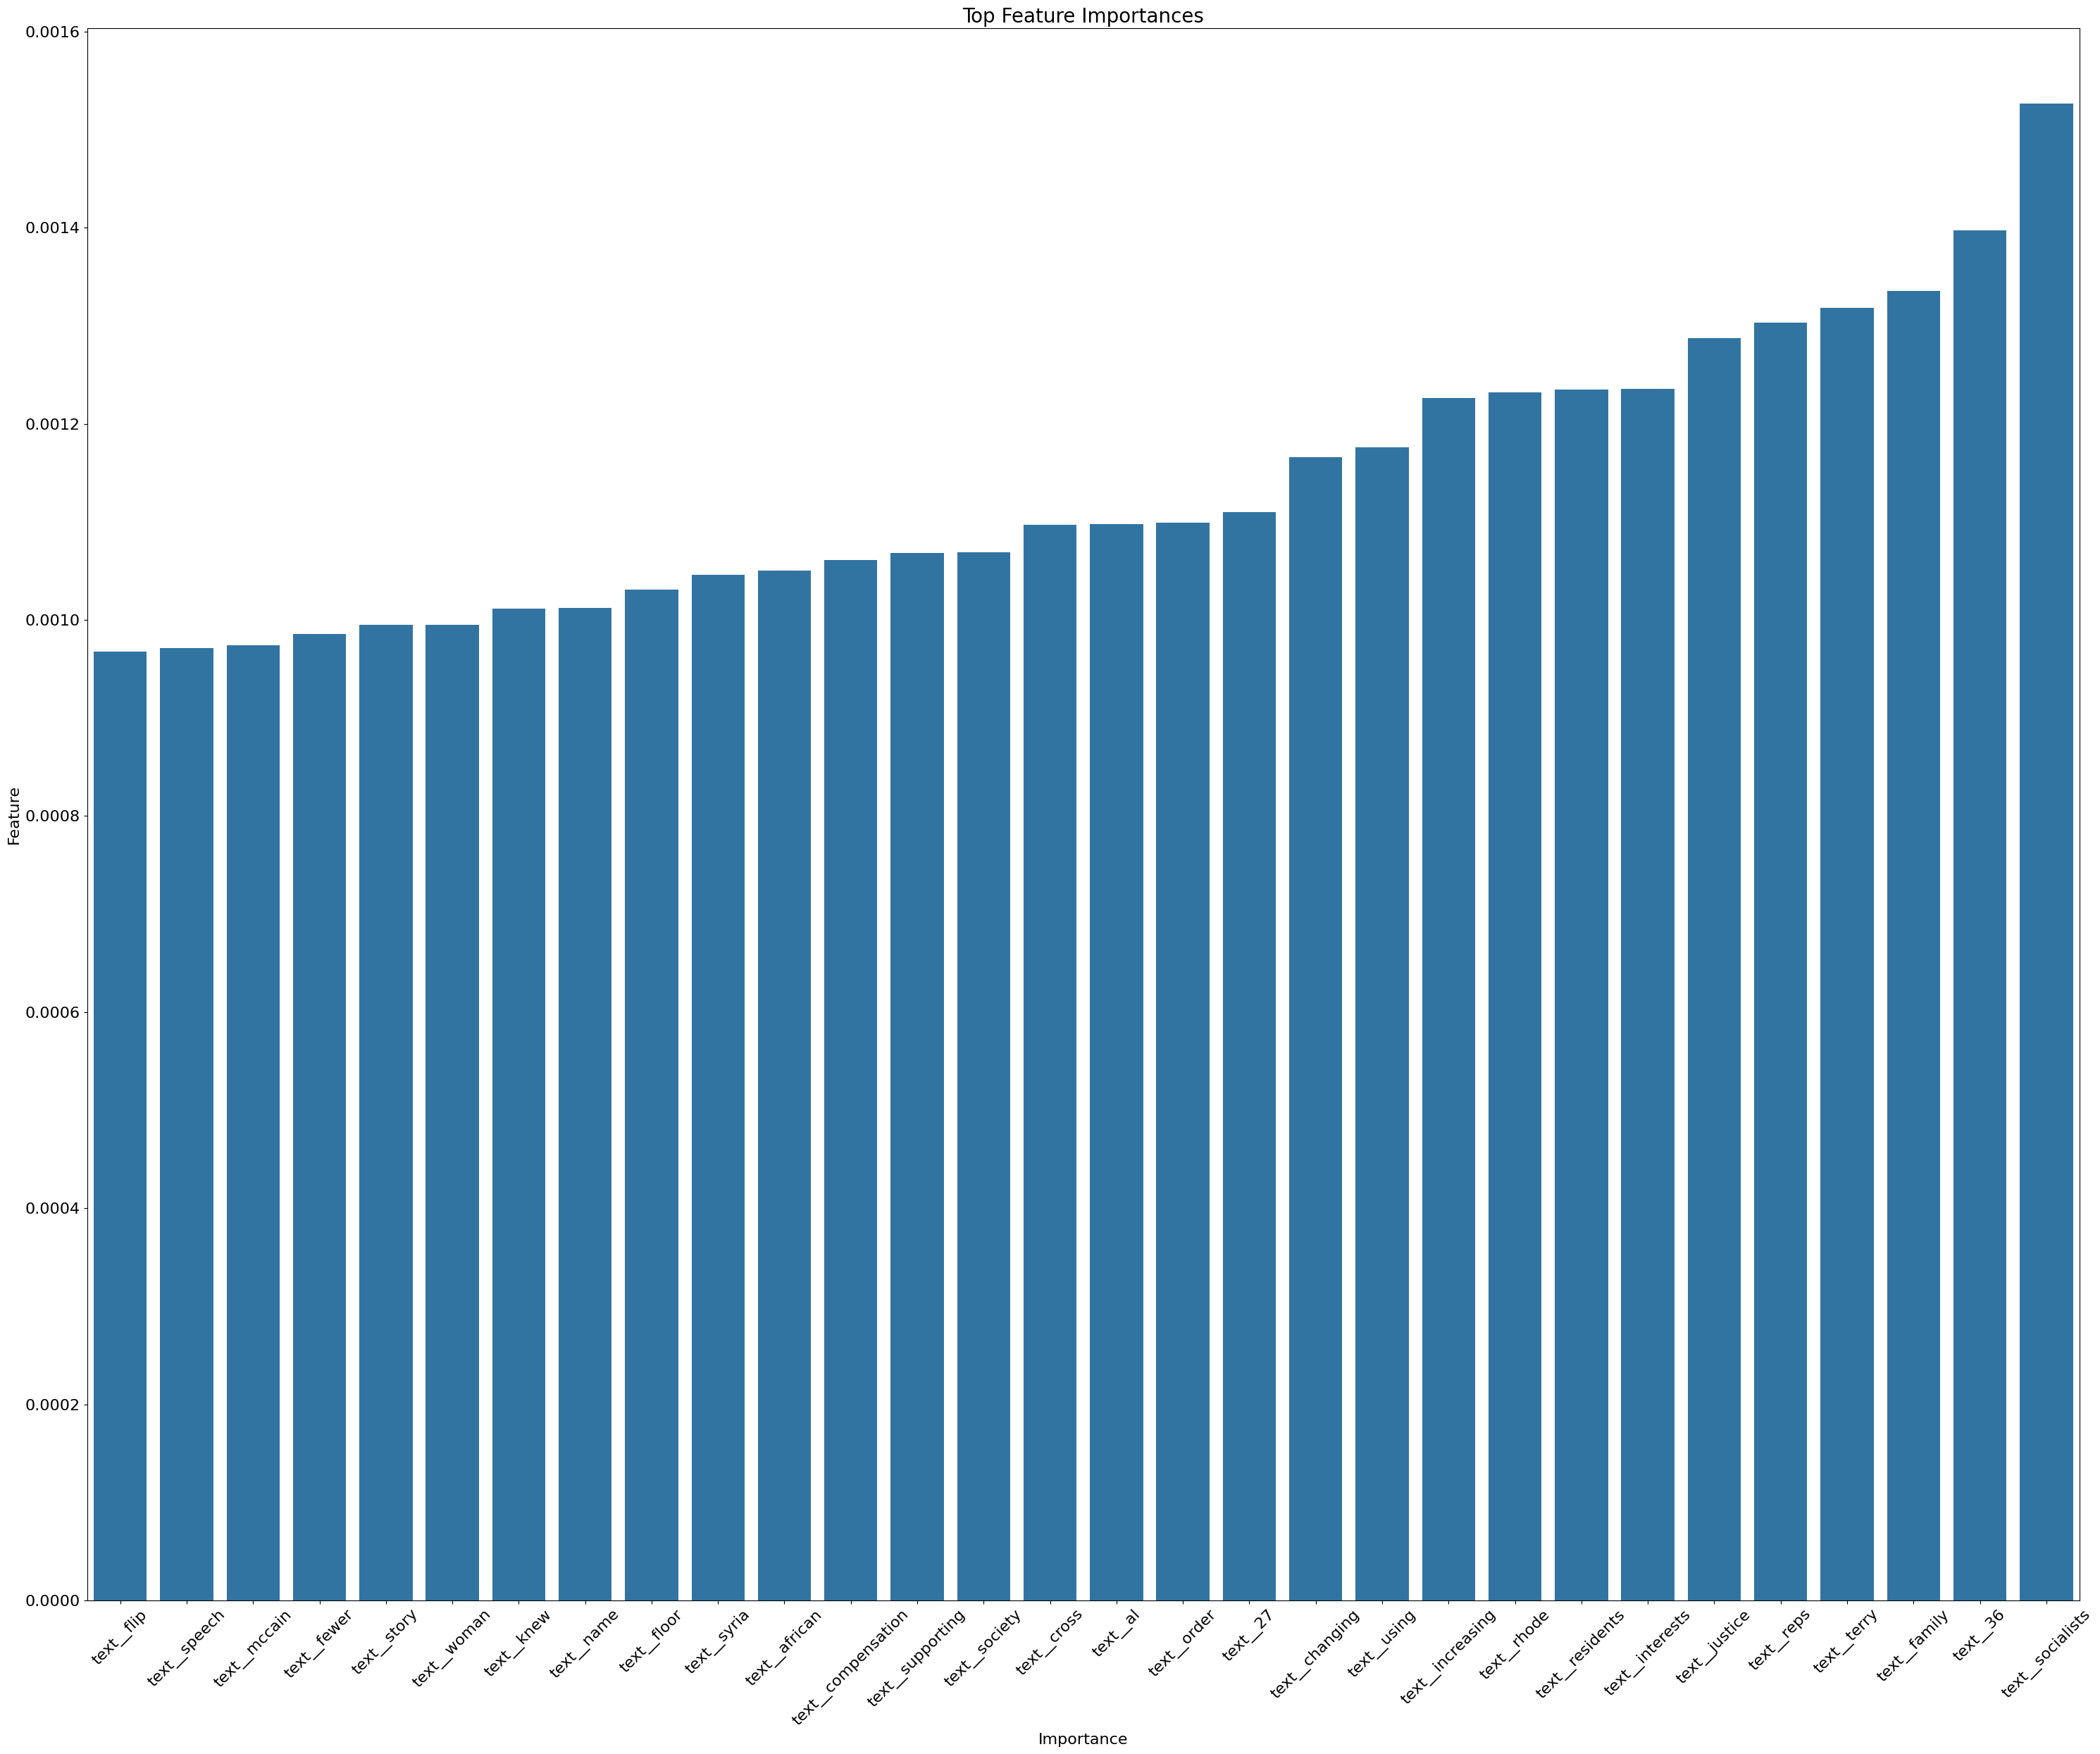

In [63]:
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(), 'statement'),
],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

Count vectorizer gives us better results. We should try removing stopwords

d:\ML\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [15:34:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "num_classes" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


F1 Score: 0.248


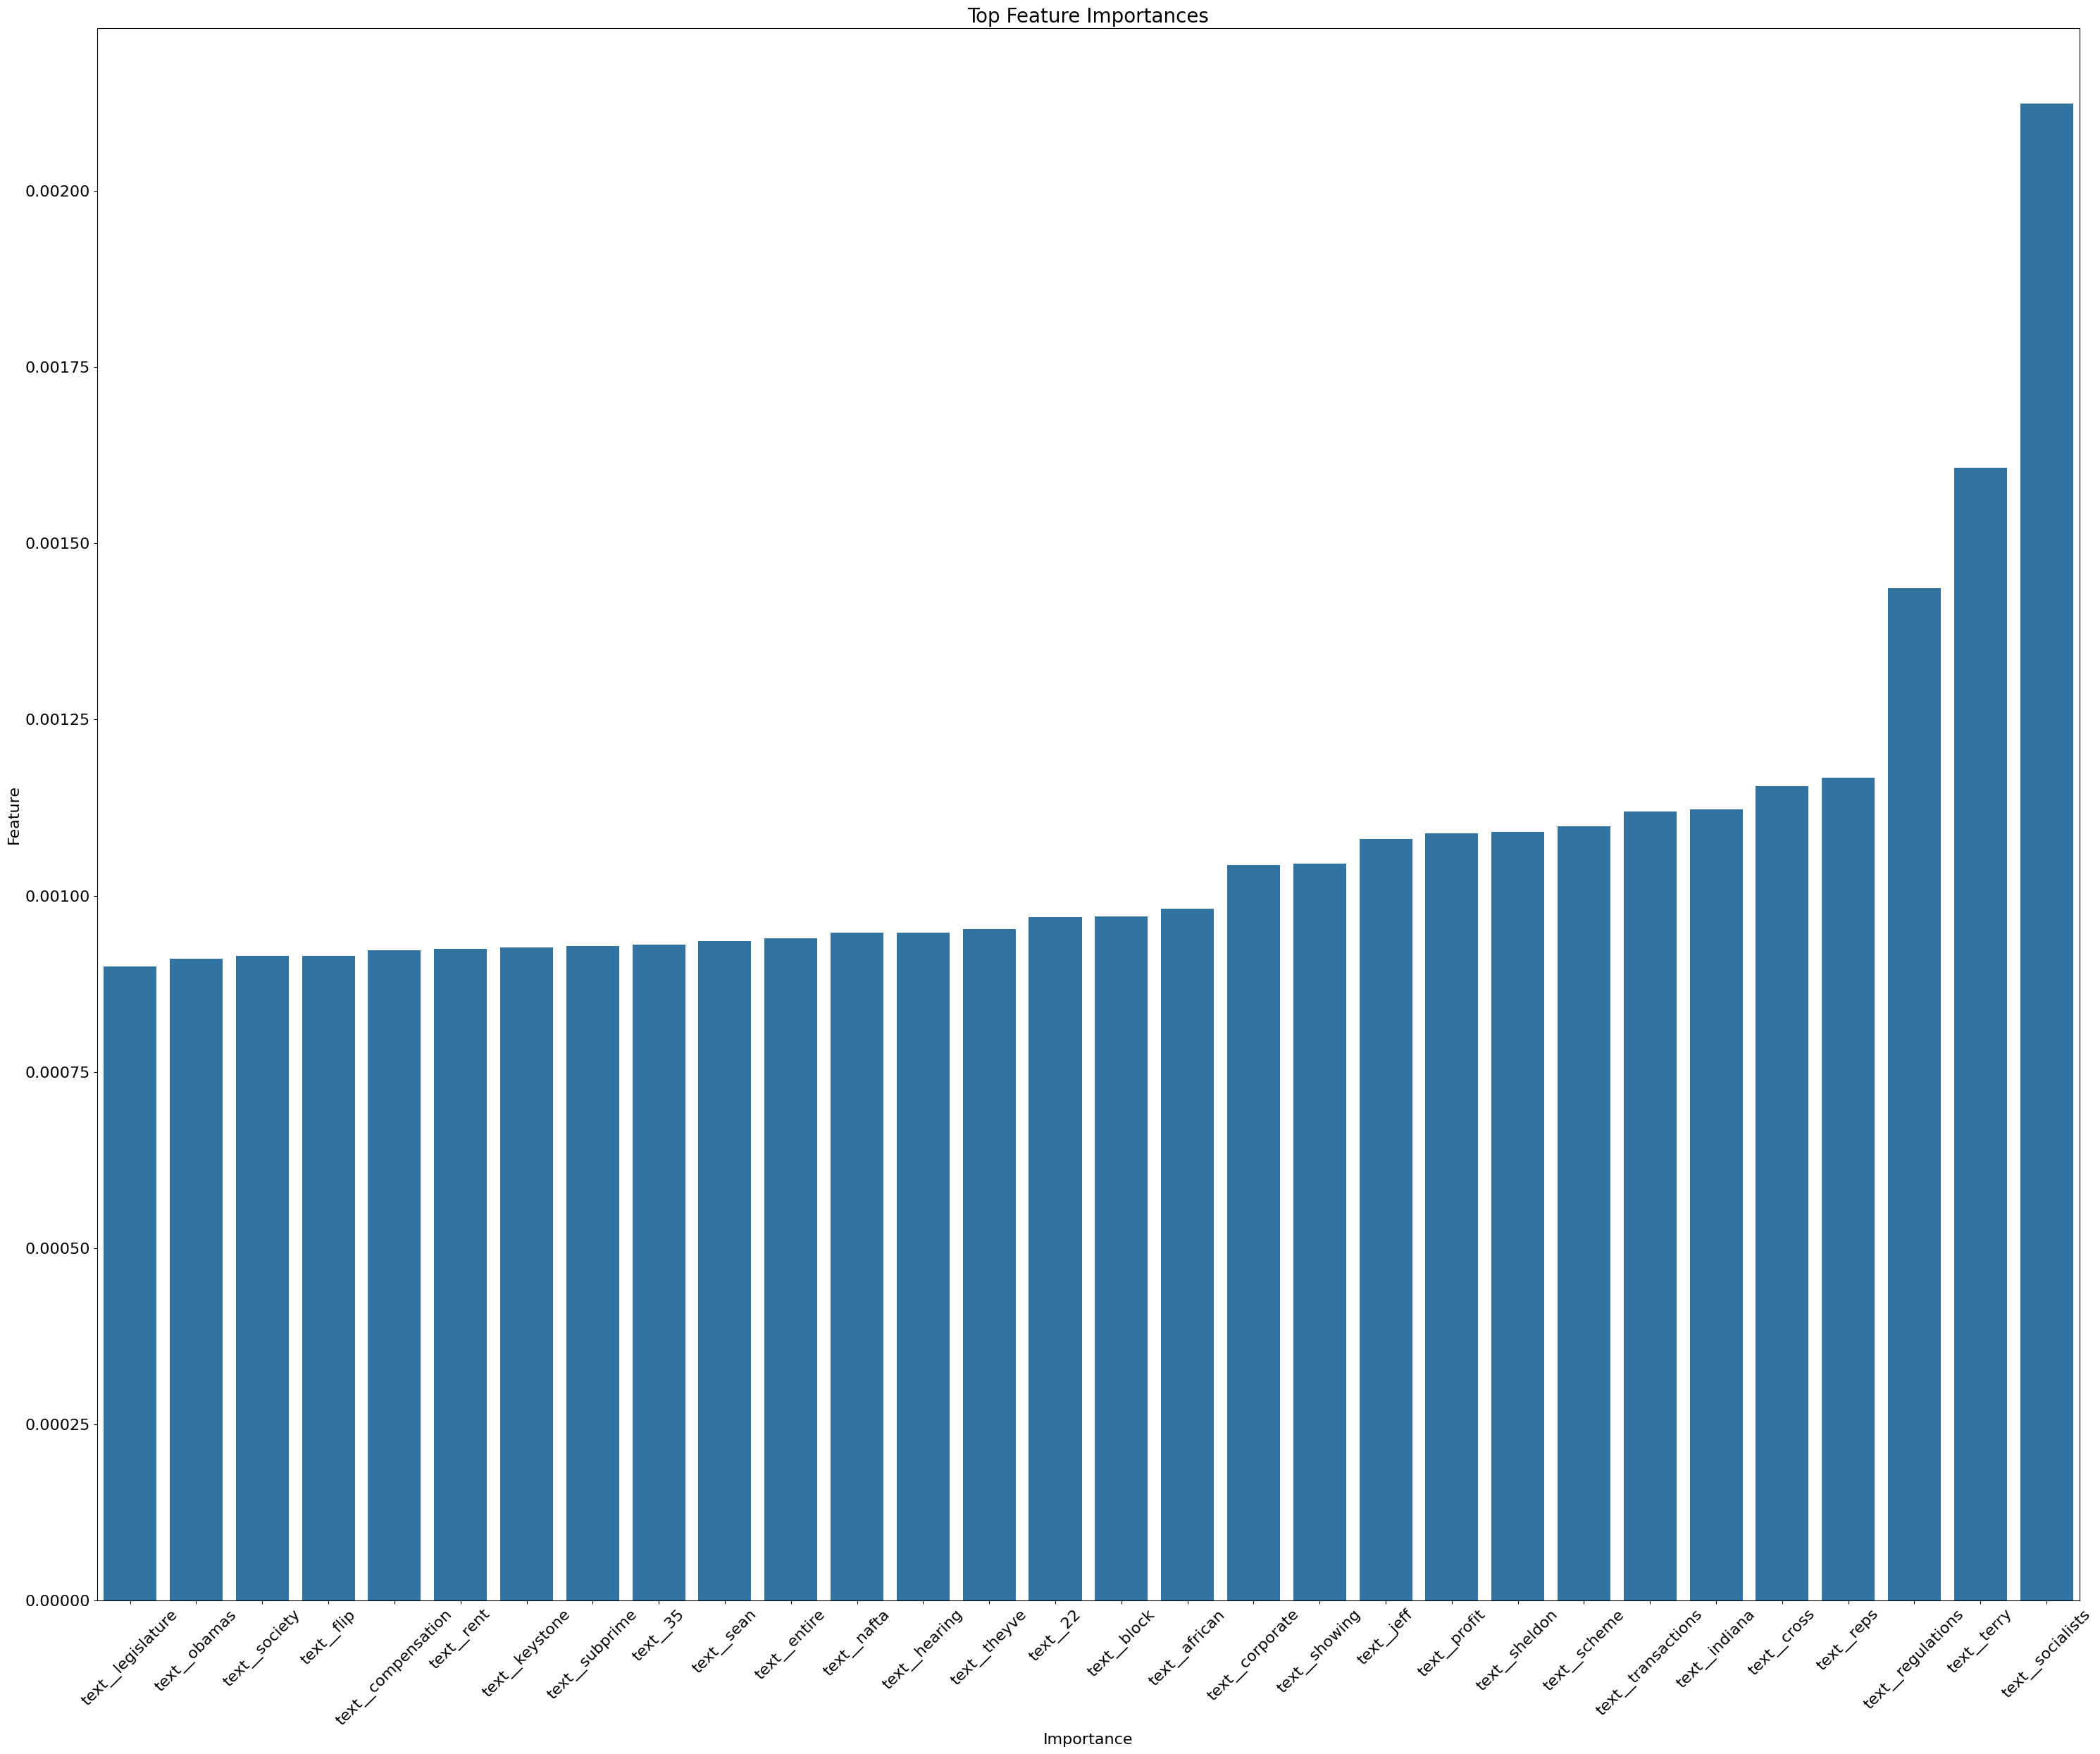

In [64]:
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(stop_words='english'), 'statement'),
],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

In [12]:
def stemmed_tokenizer(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

We get the same result, we should try stemming

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.260


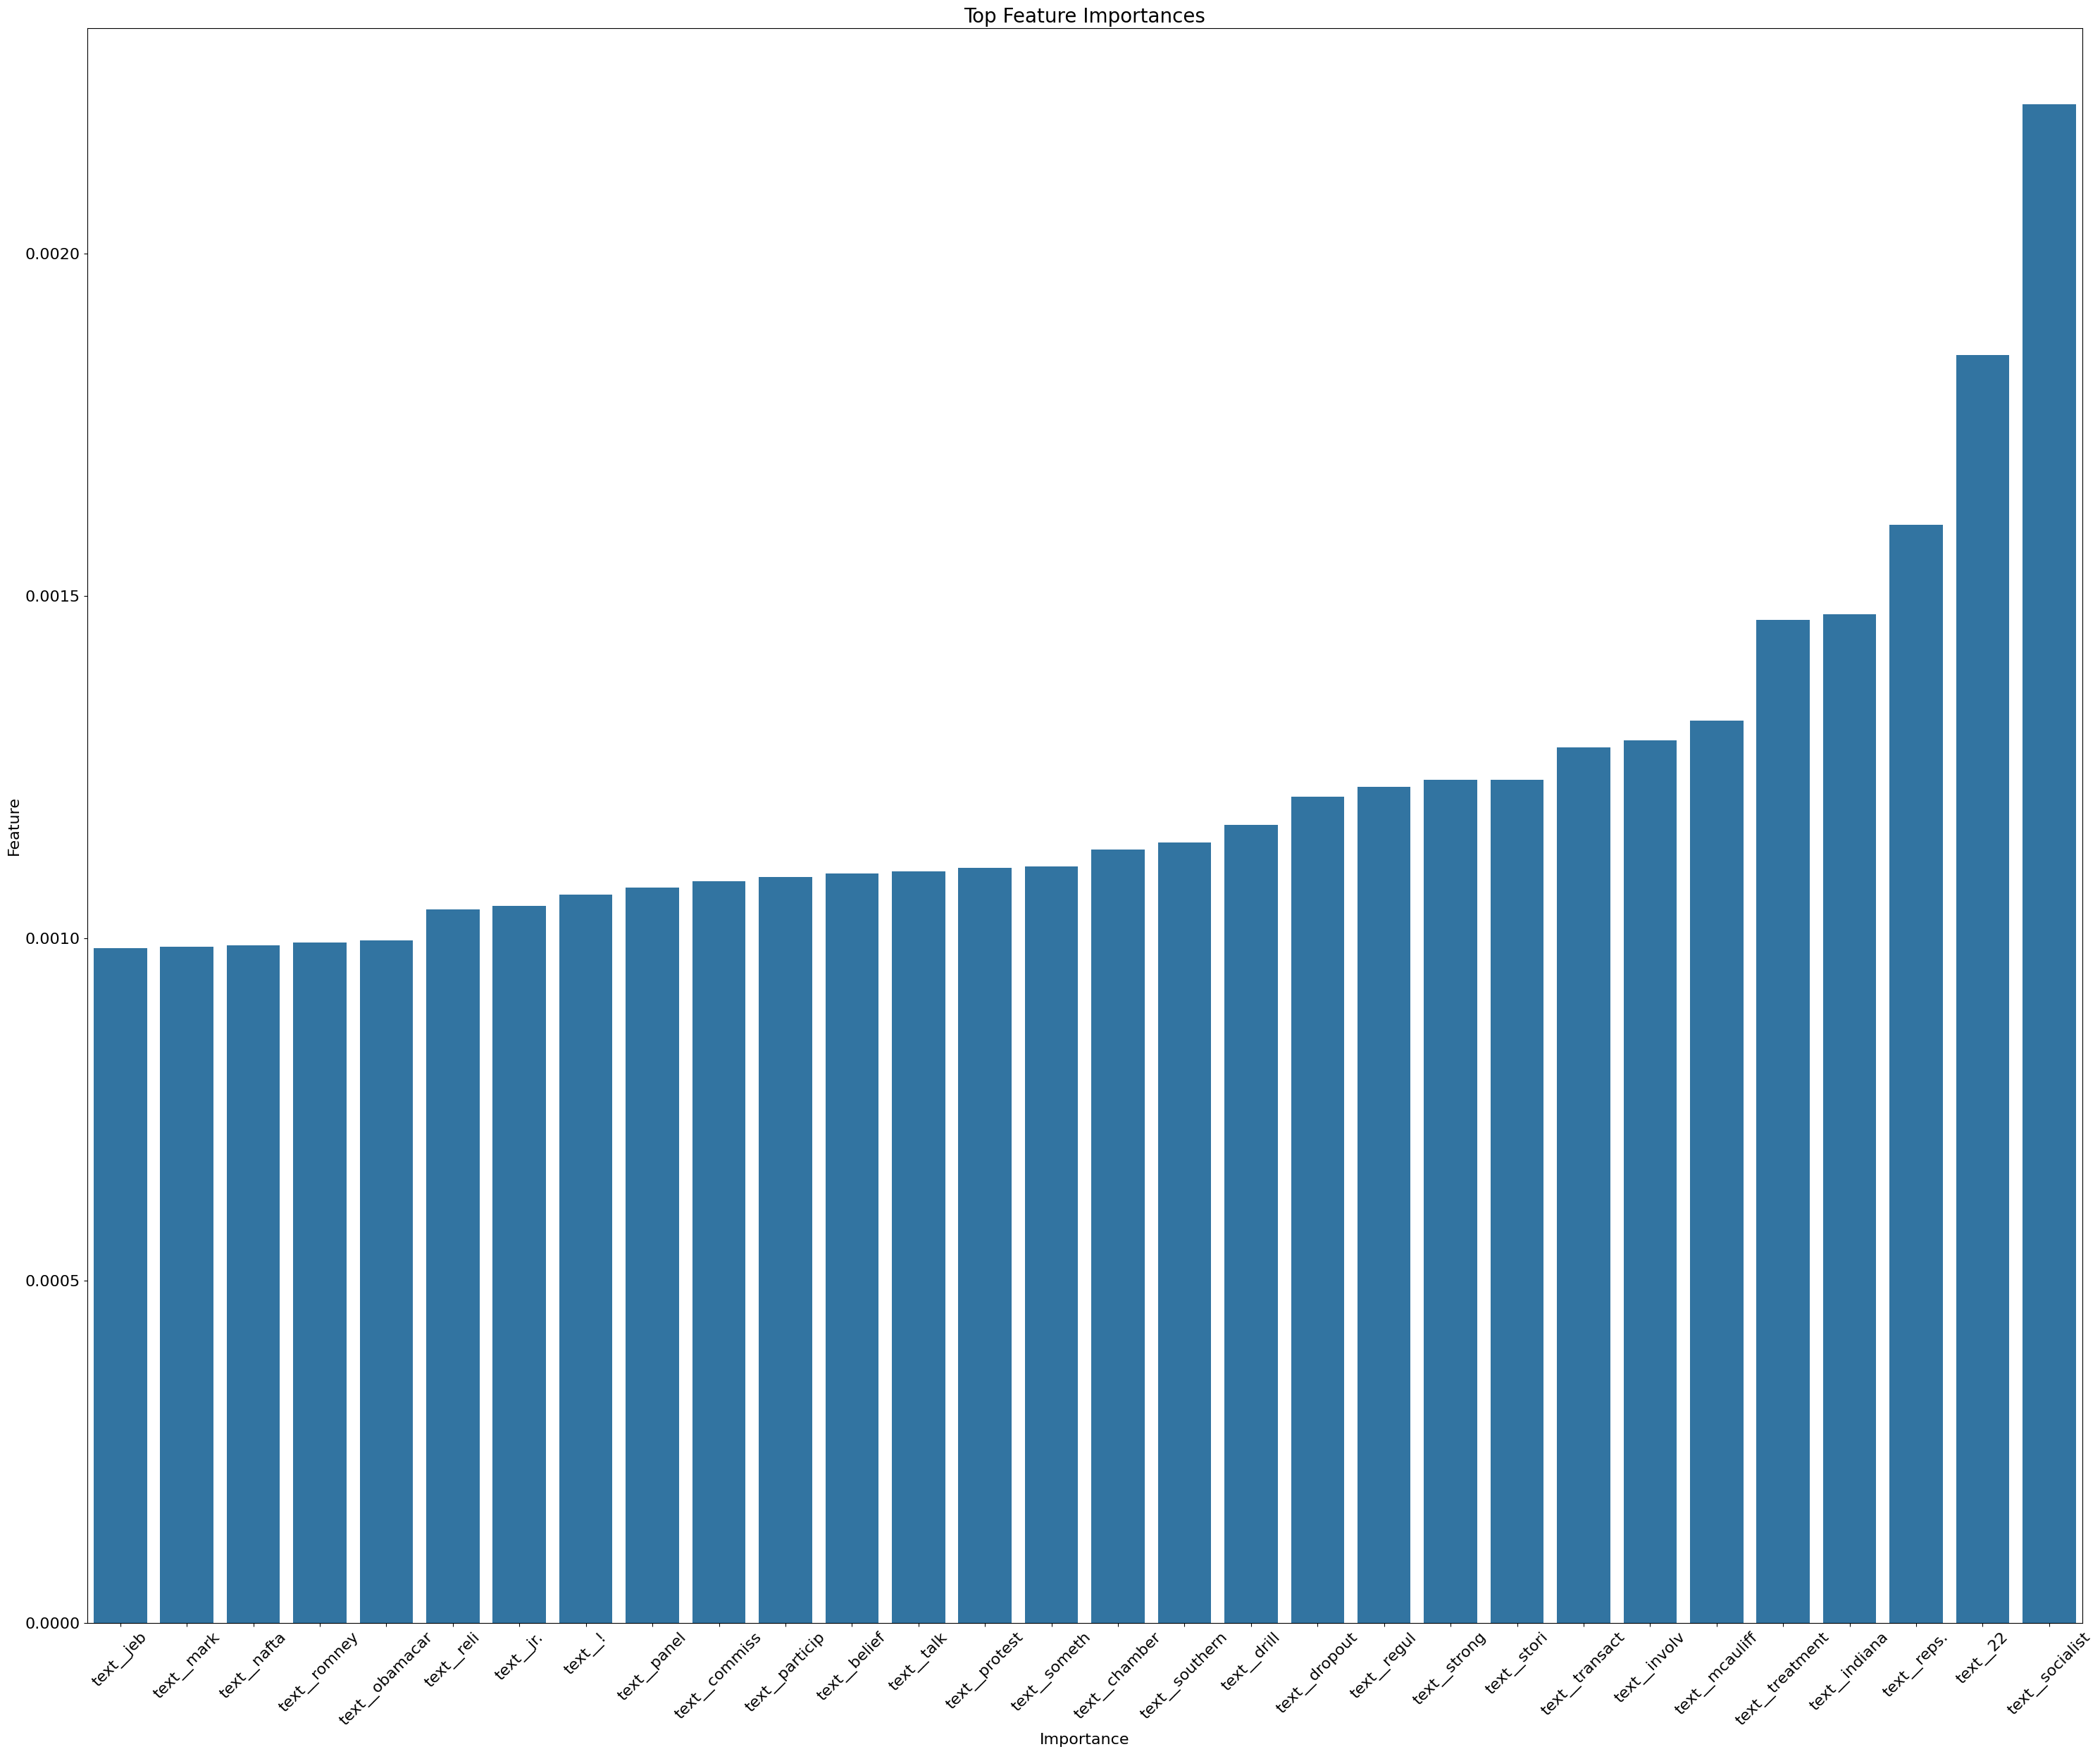

In [66]:
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer, stop_words='english'), 'statement'),
],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

Very good results, let us try bigrams now

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.256


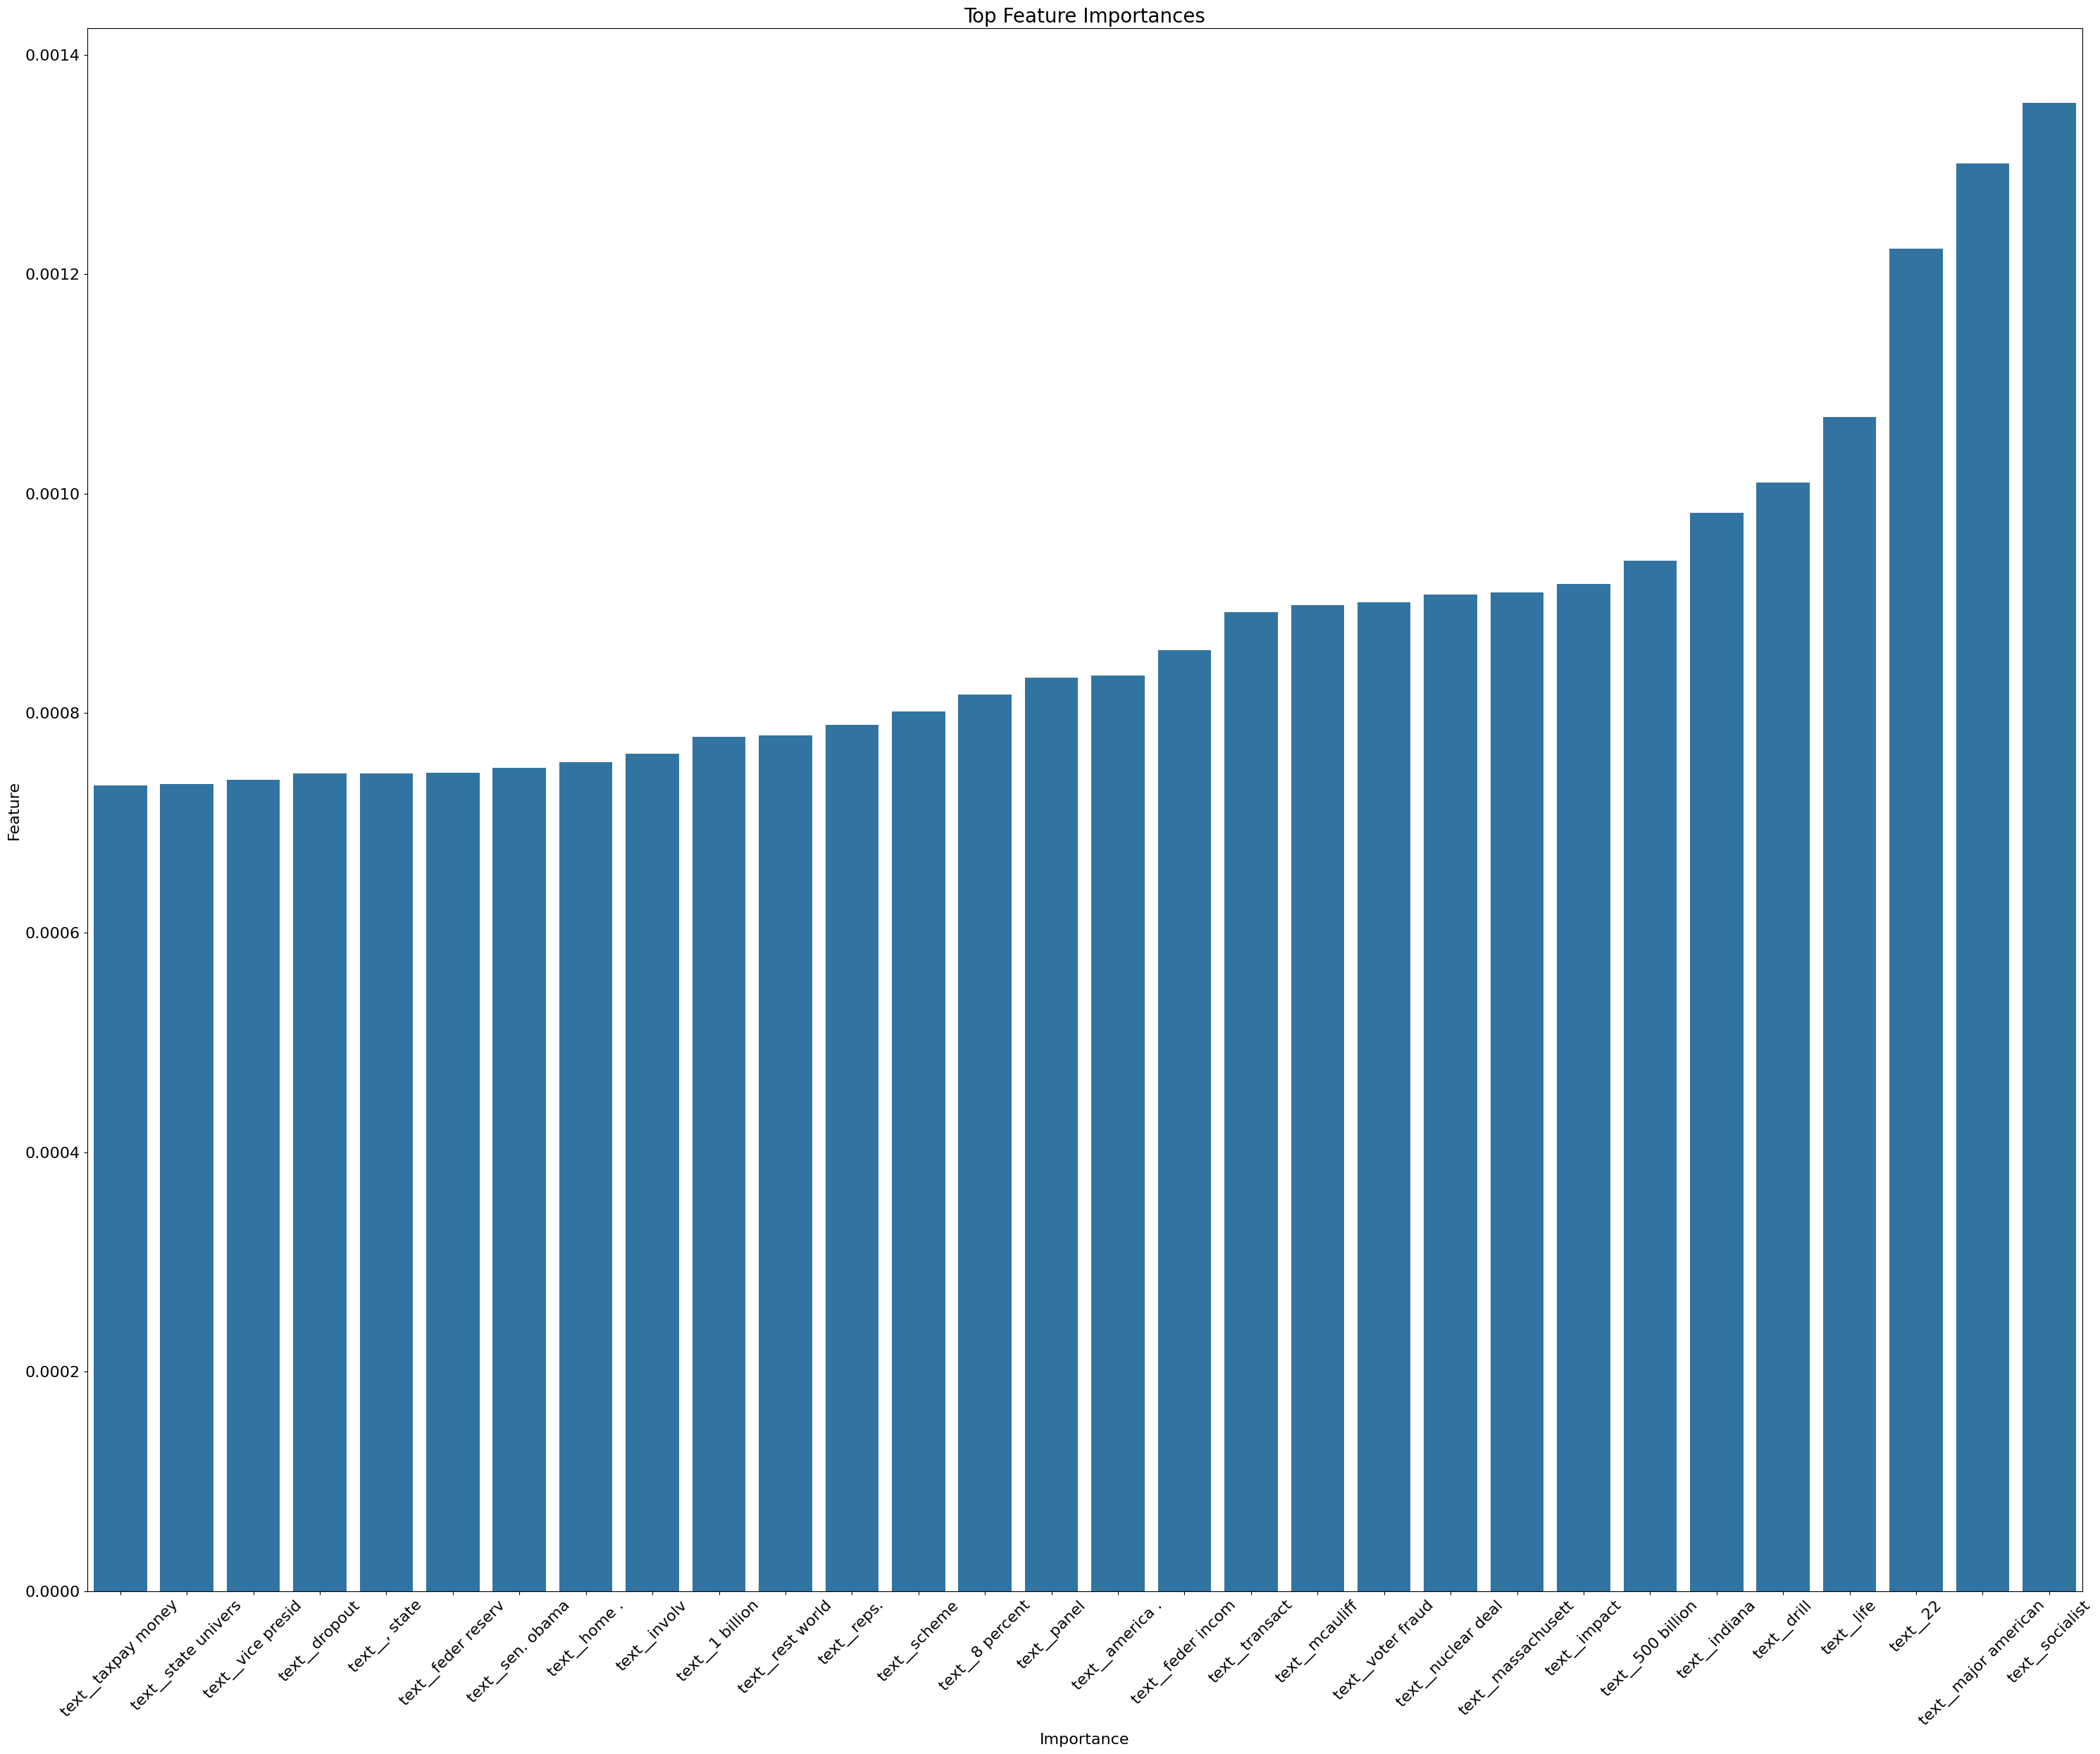

In [67]:
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer, ngram_range=(1, 2), stop_words='english'), 'statement'),
],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

It doesnt give us better results, we should combine vectorization with other features

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.497


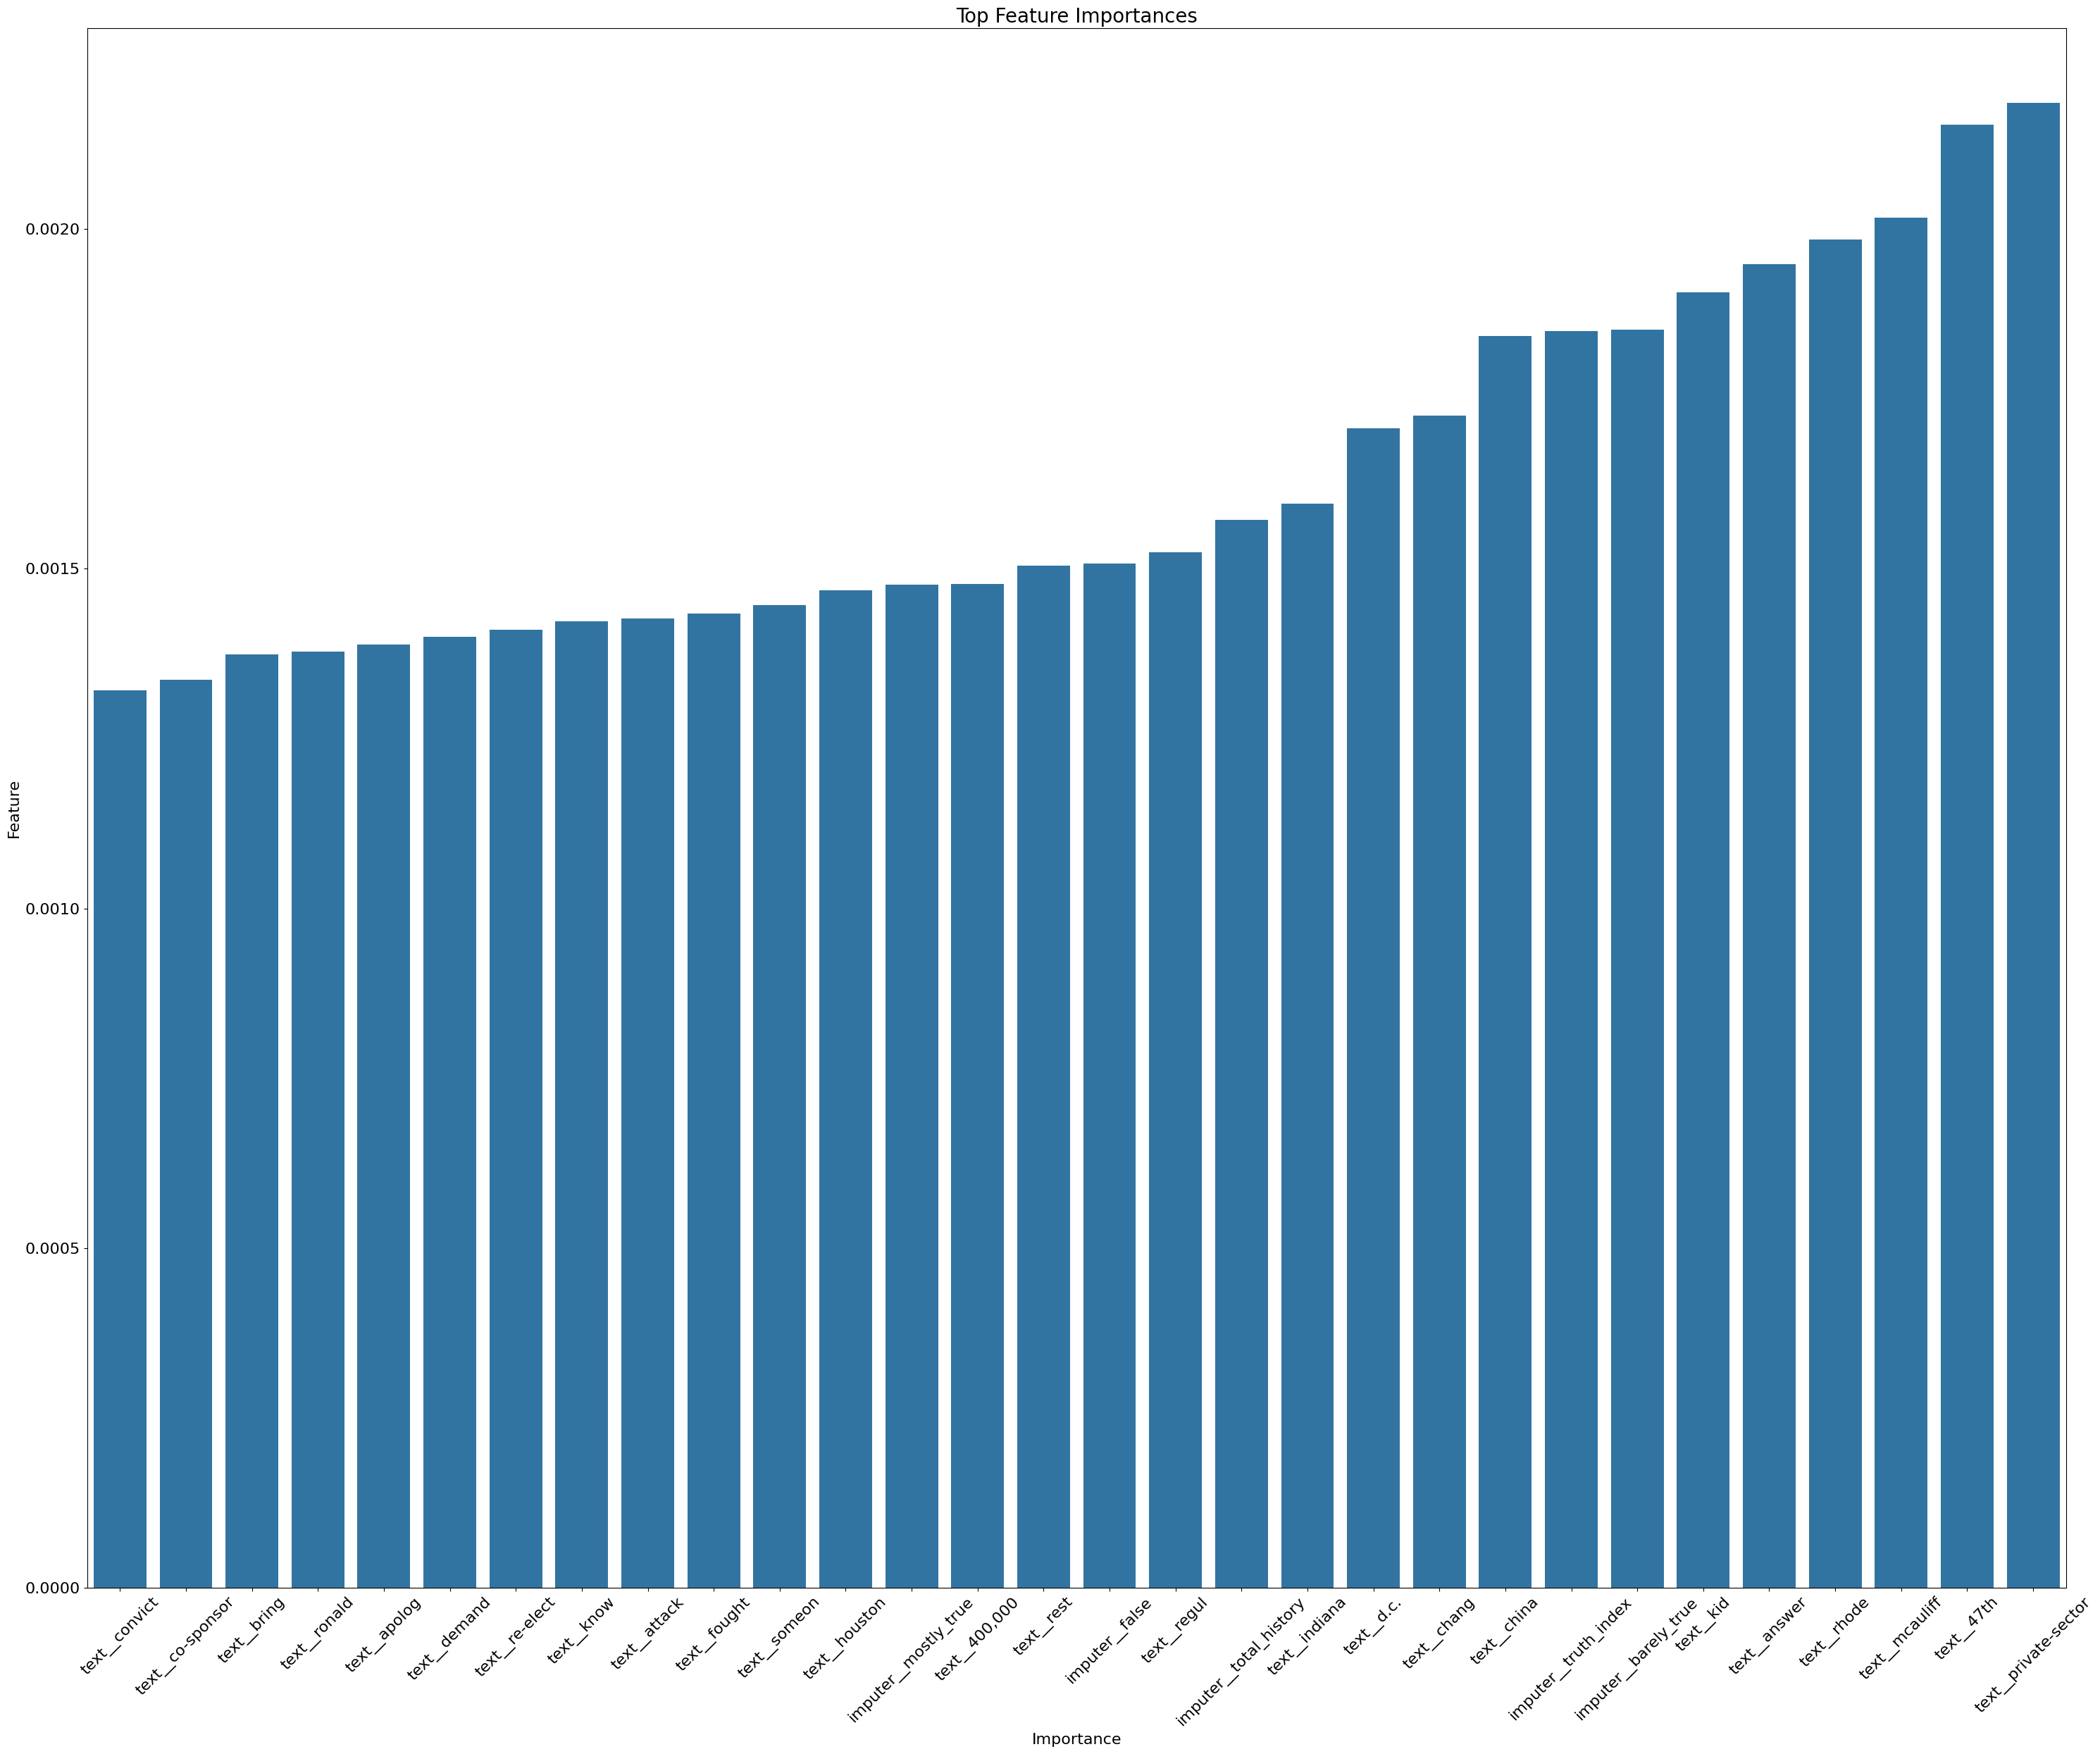

In [70]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('half_true')
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english'), 'statement'),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

Worse results, let us limit the words.

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.521


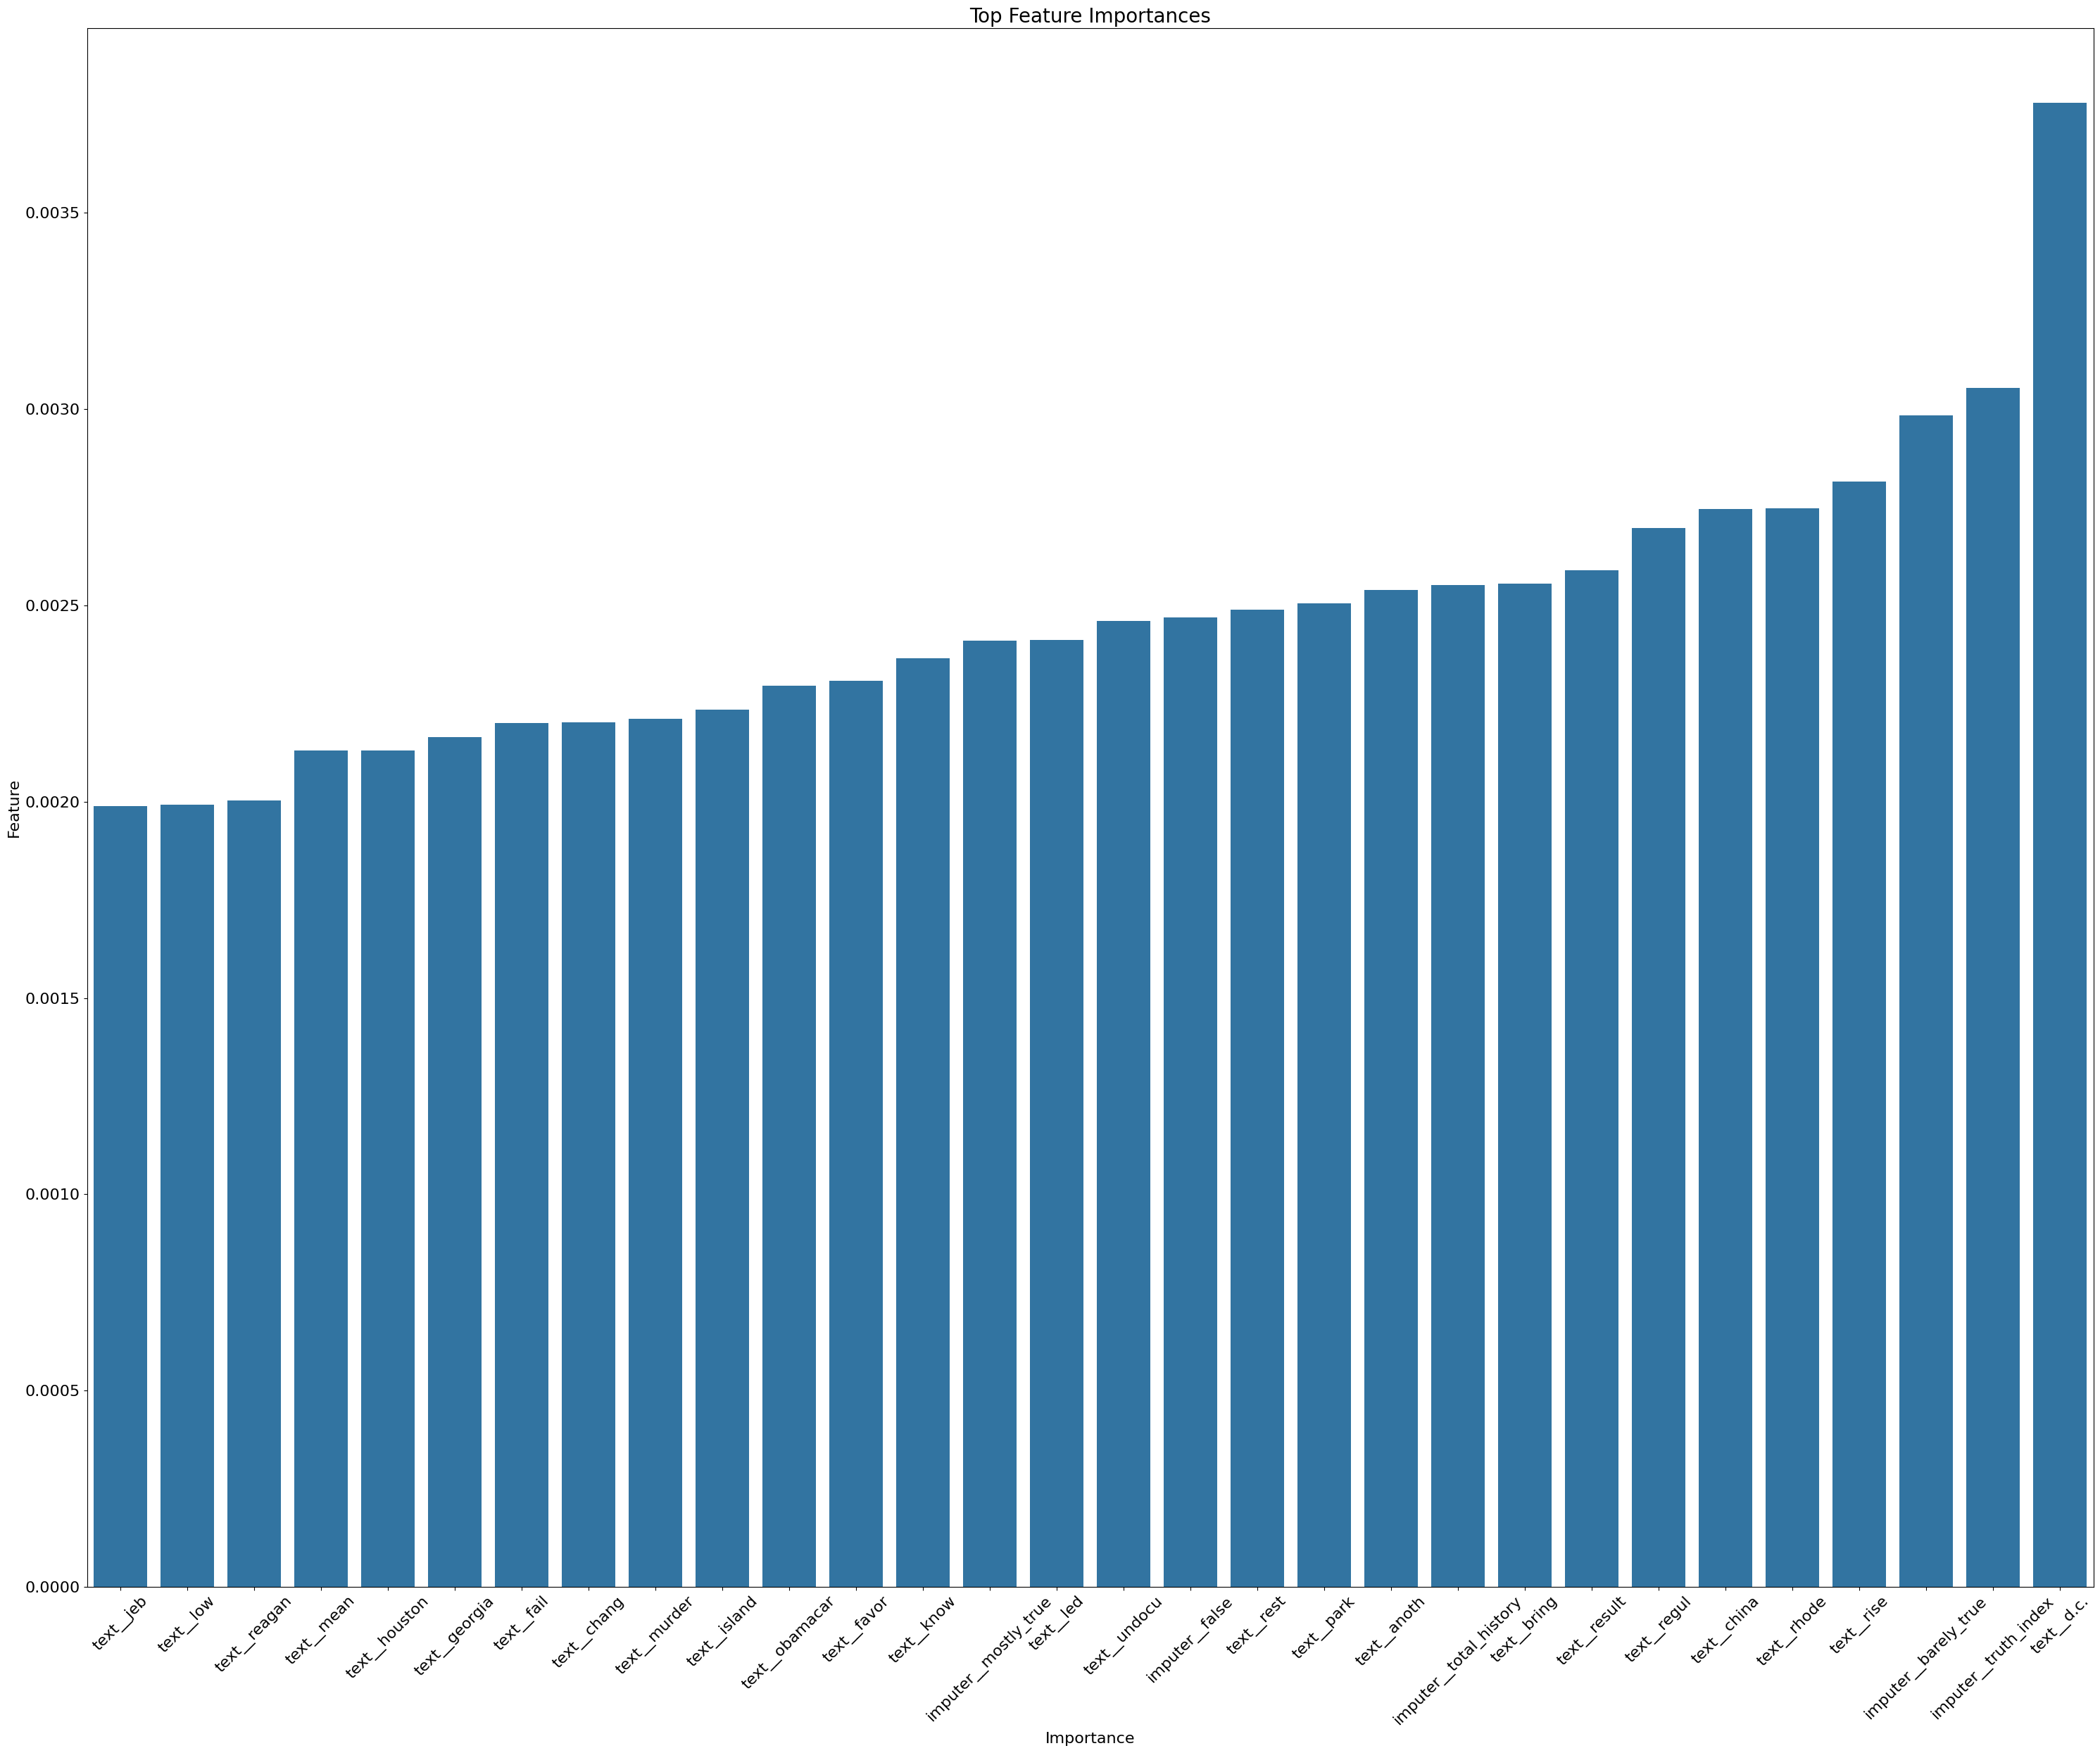

In [71]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('half_true')
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=1000), 'statement'),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.560


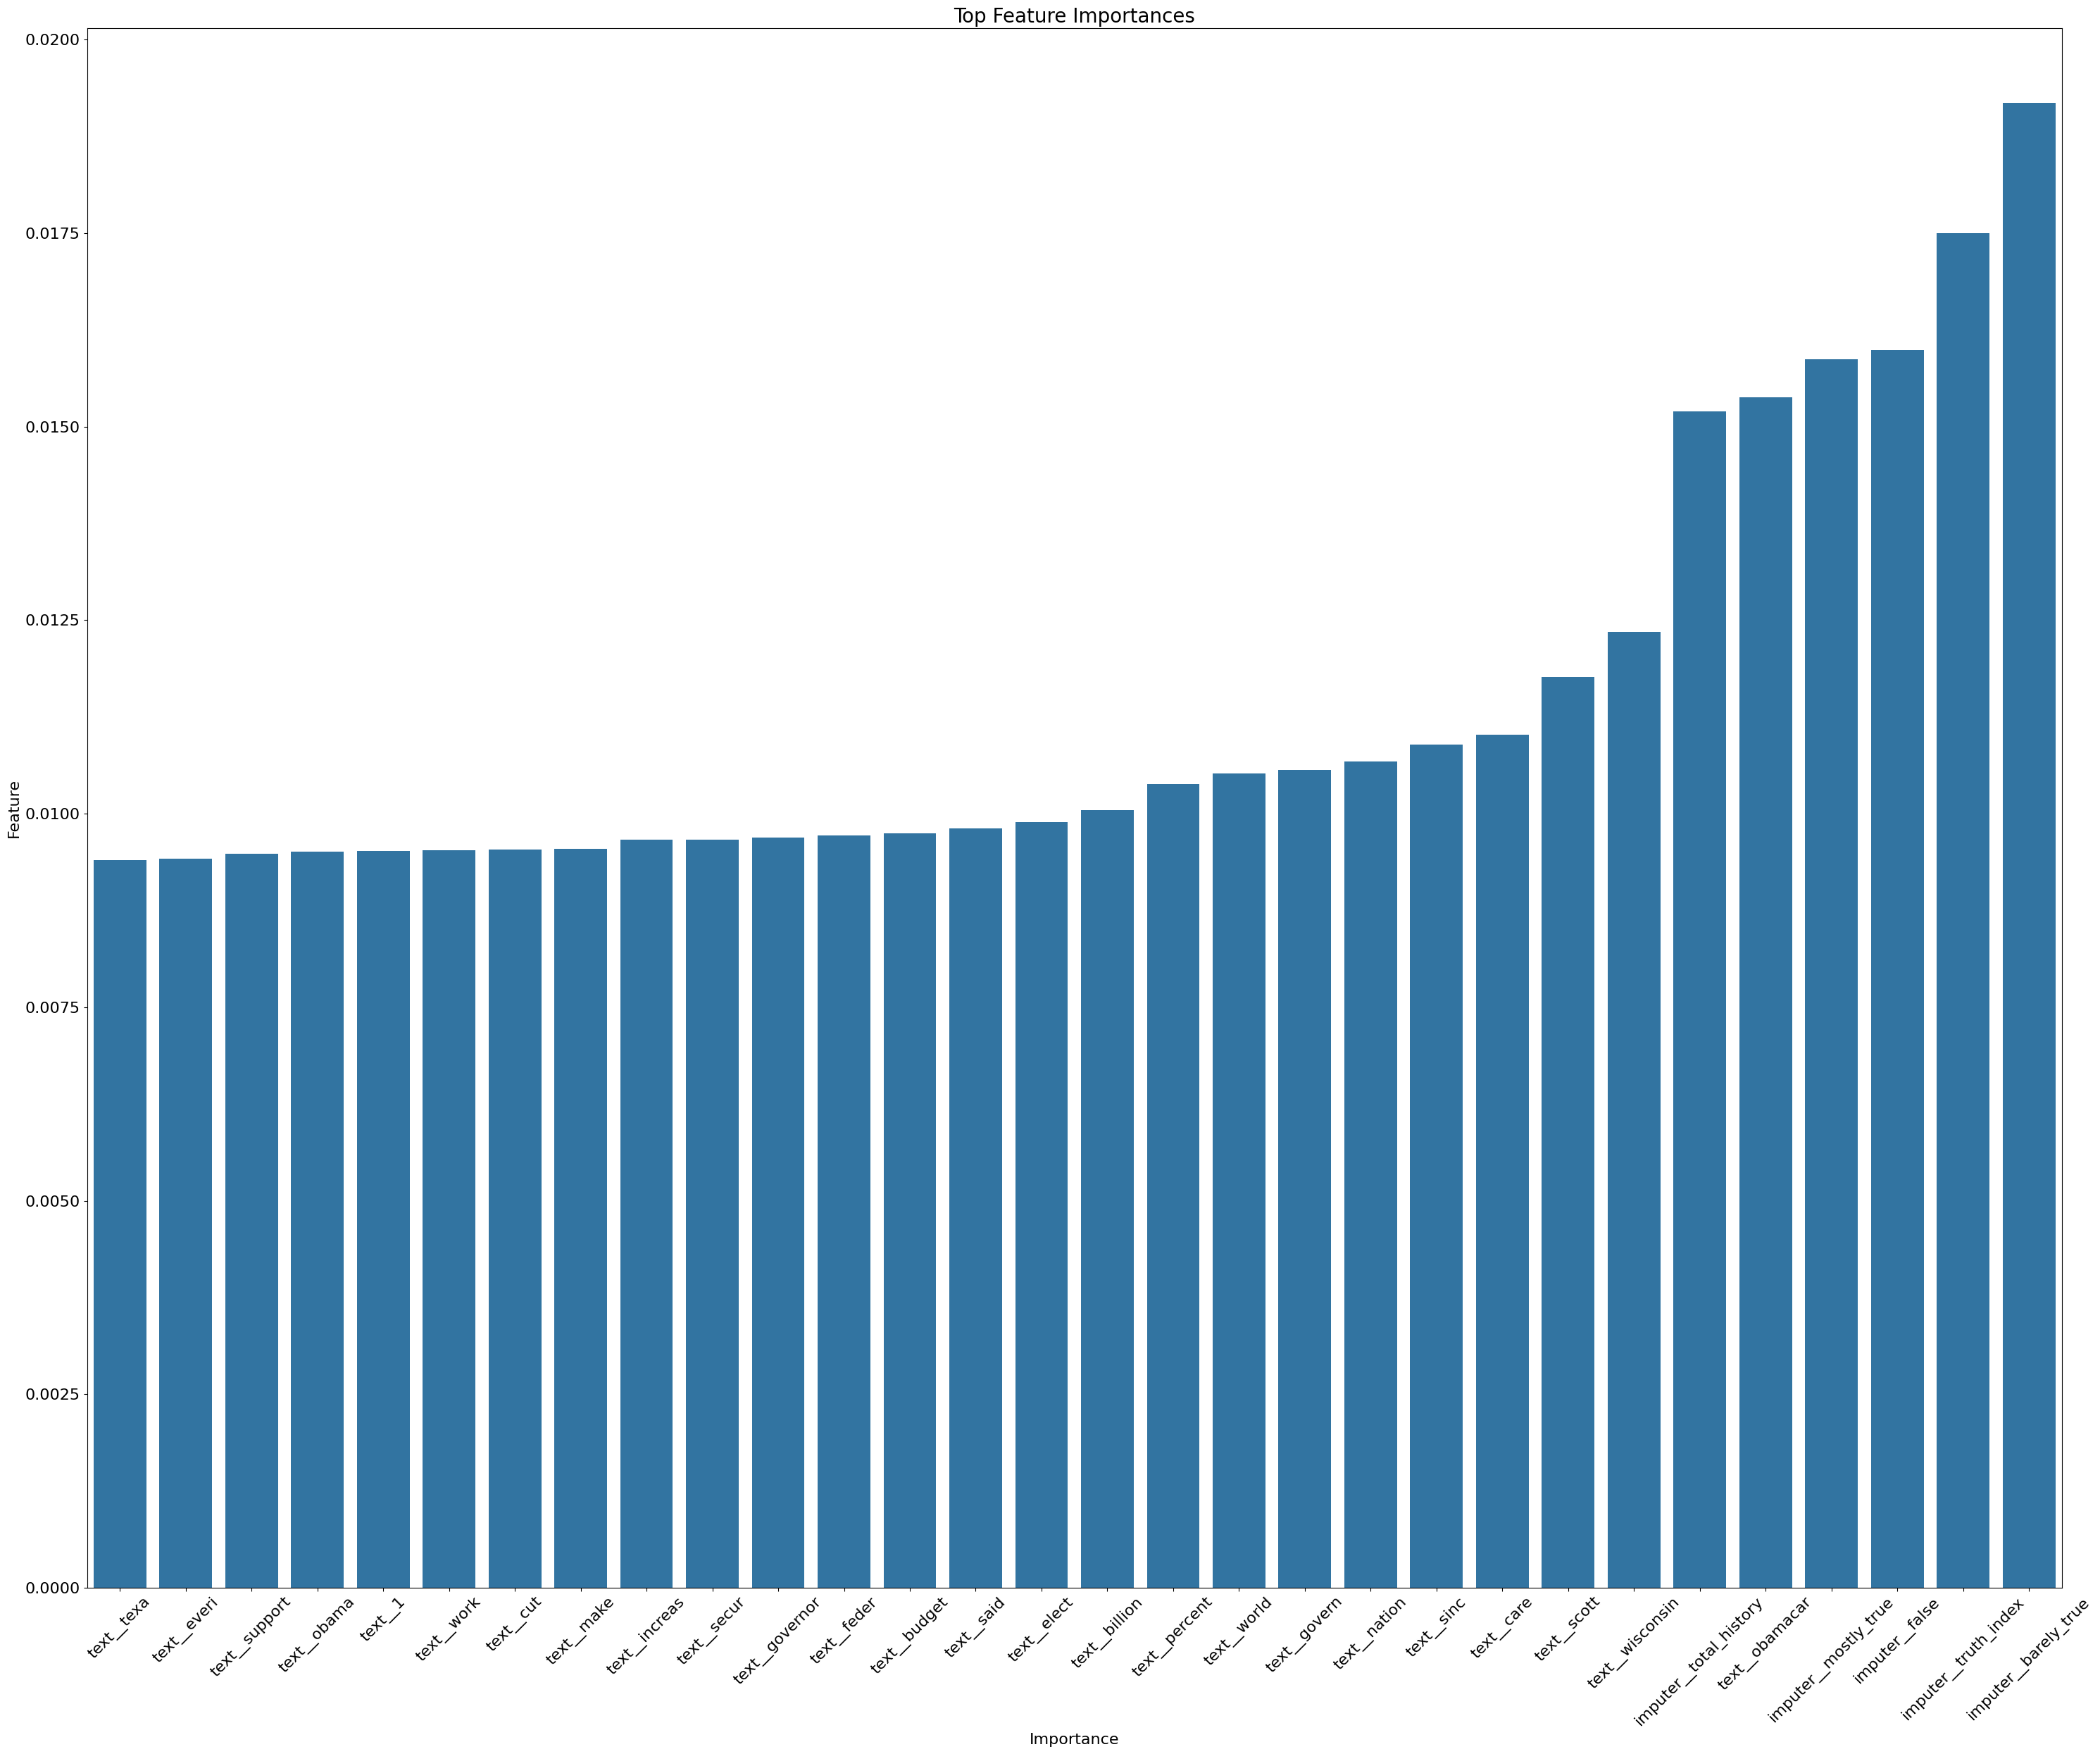

In [72]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('half_true')
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=100), 'statement'),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

Lower number of words may give us better results.

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.603


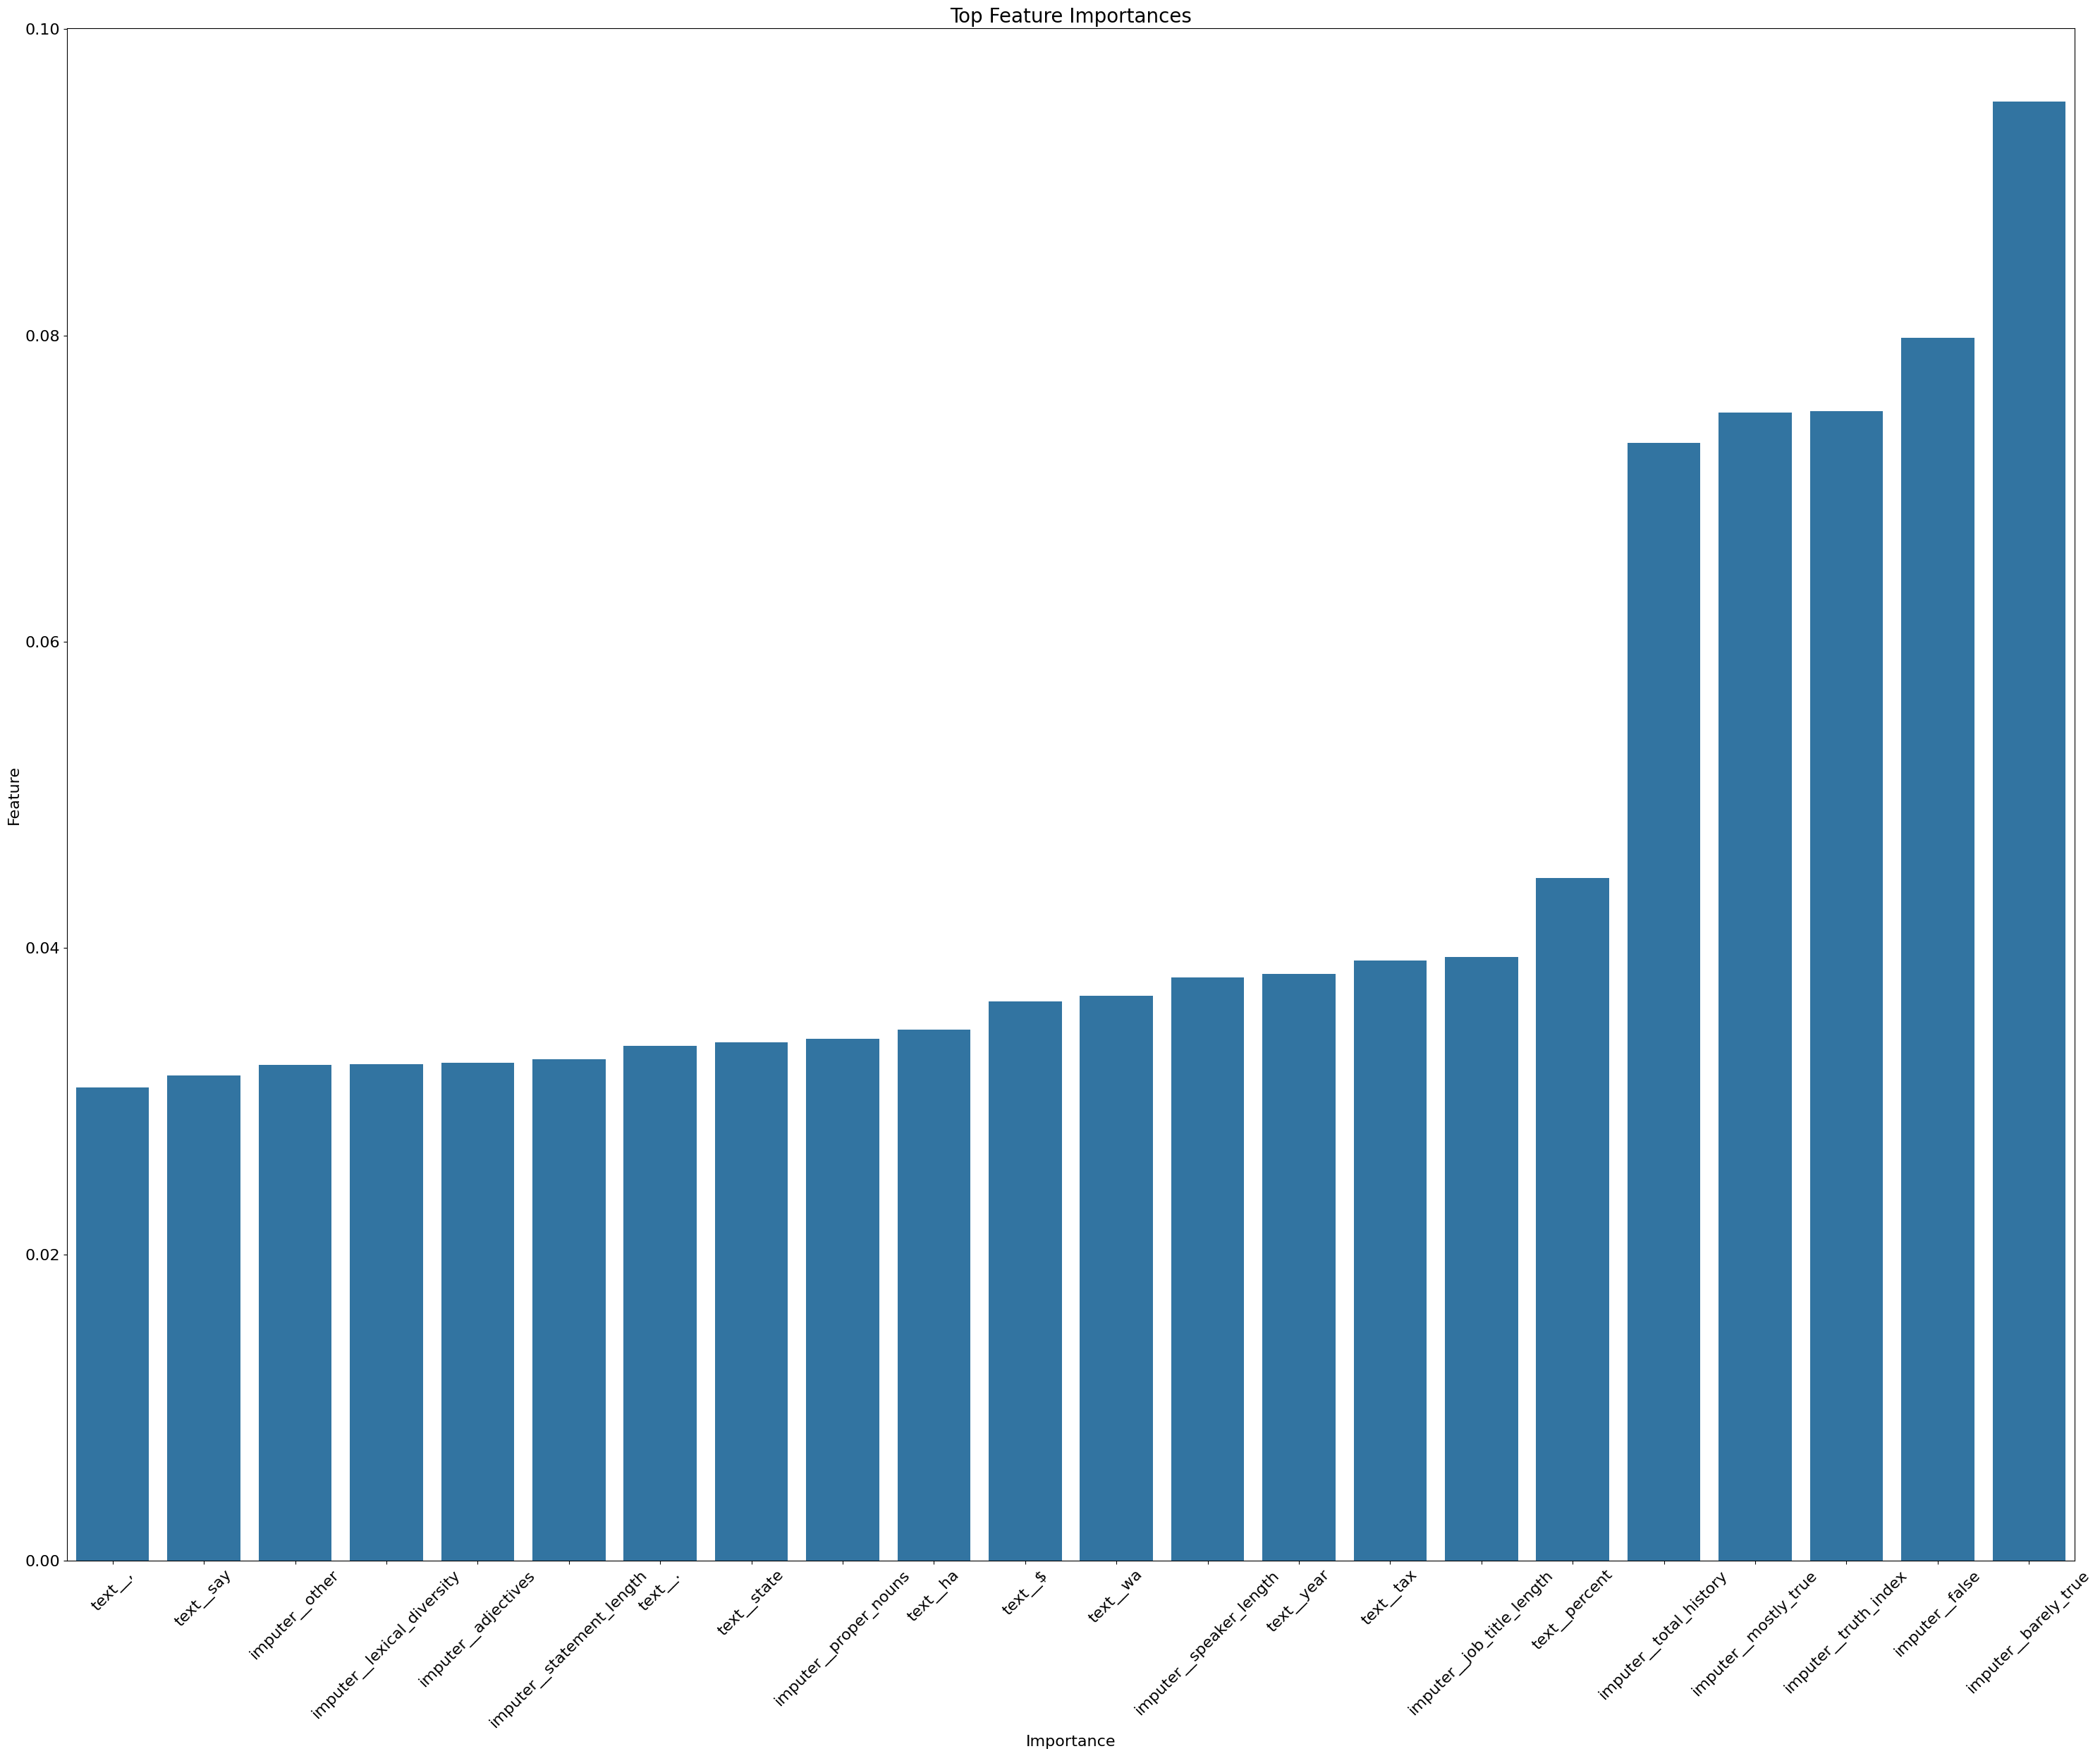

In [74]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('half_true')
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=10), 'statement'),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

We should try tfidf vectorizer

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.601


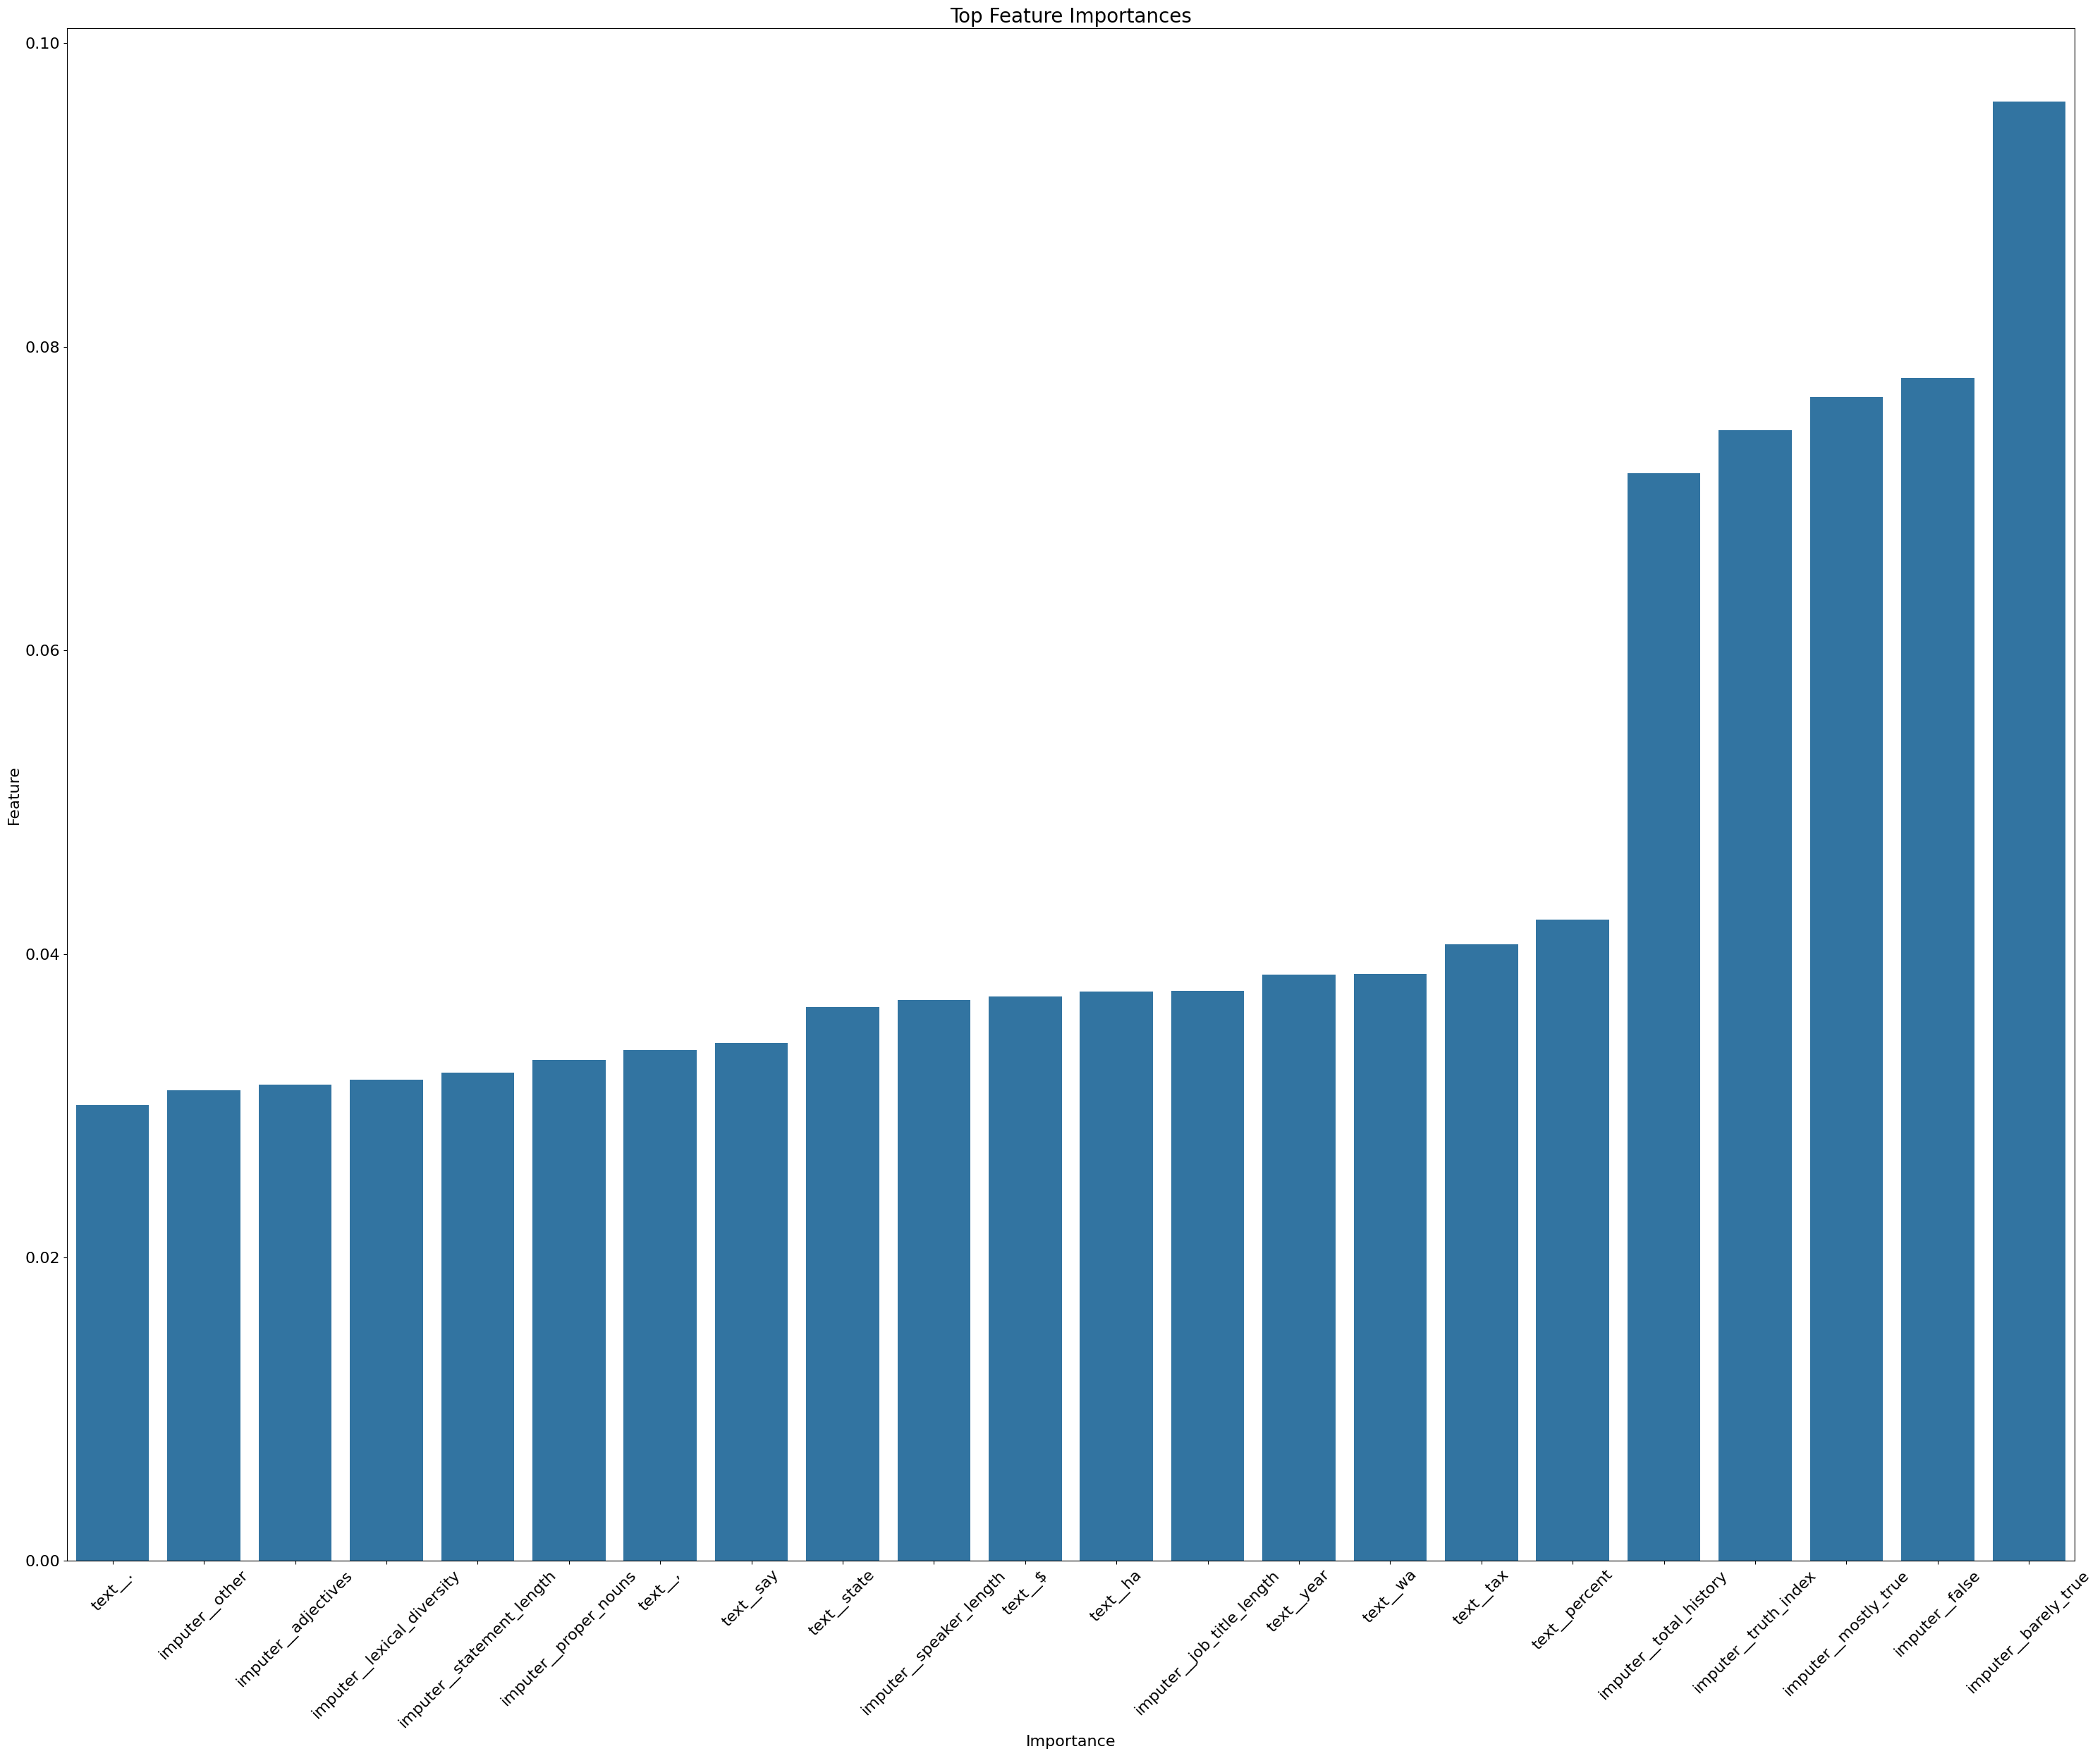

In [75]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('half_true')
preprocessor = ColumnTransformer(transformers=[
    ('text', TfidfVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=10), 'statement'),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

Let us try with the num columns with the highest importance here

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.597


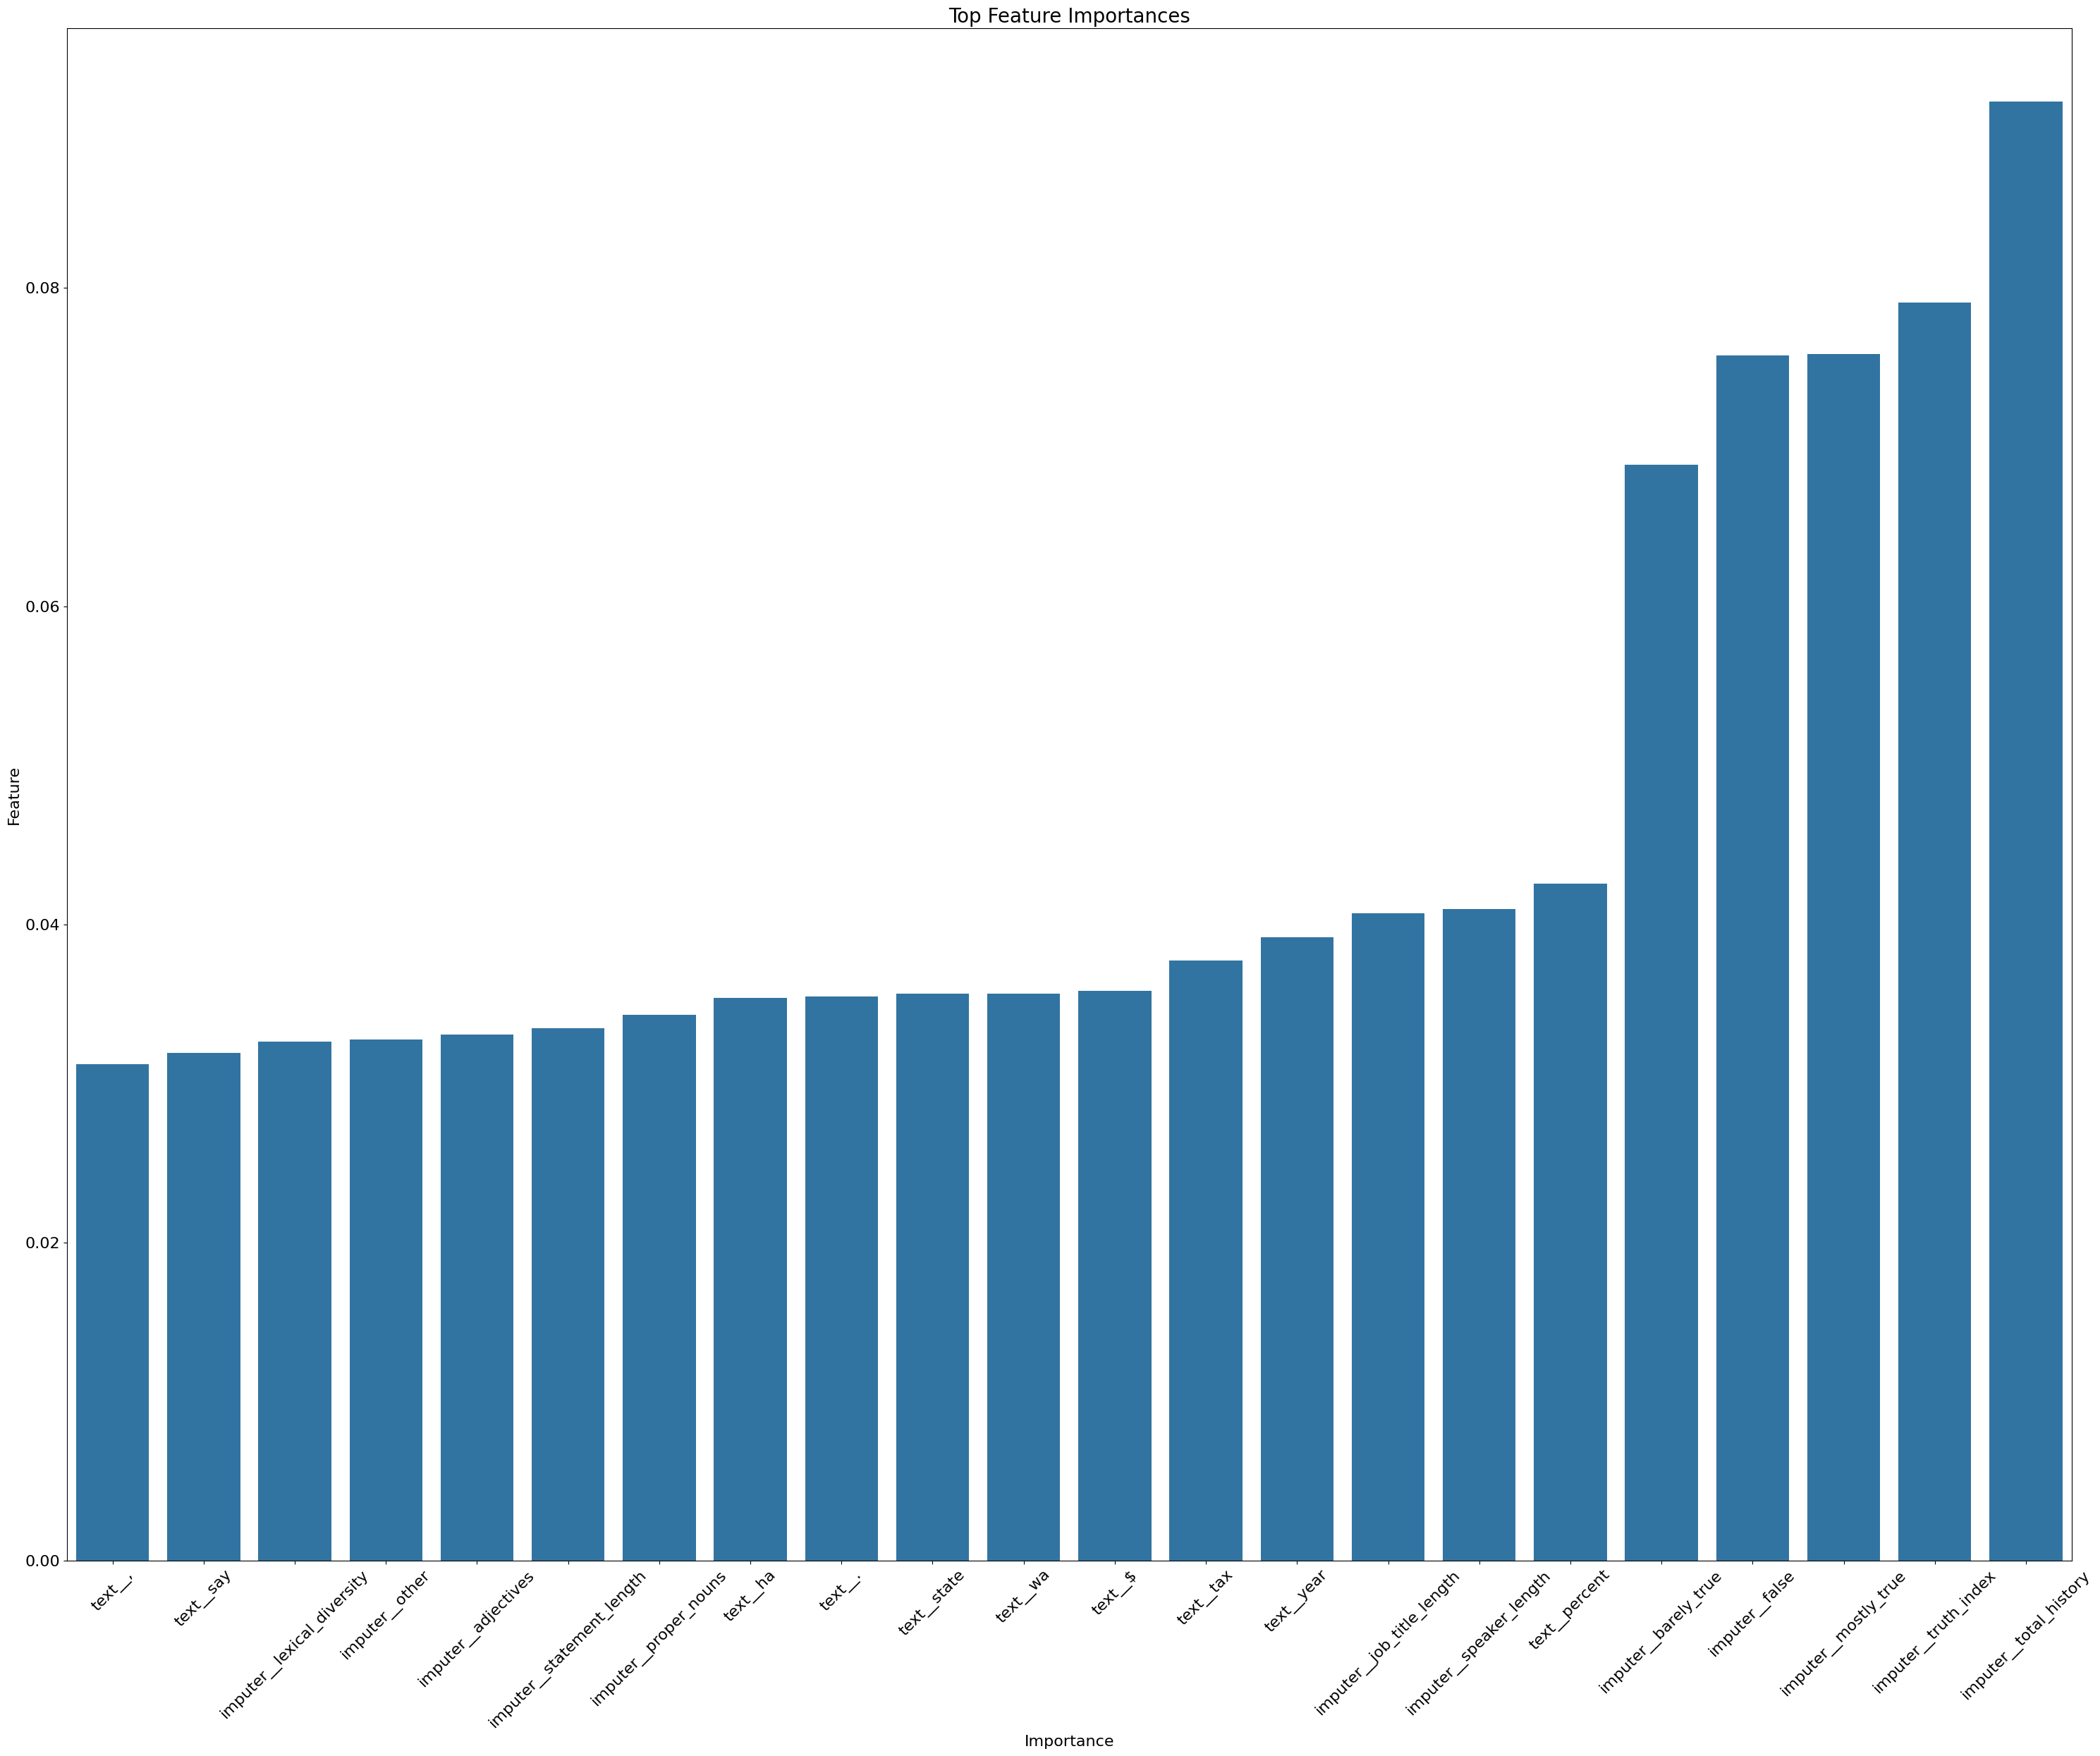

In [76]:
numerical_cols = [
    'other', 'adjectives', 'lexical_diversity', 'statement_length',
    'proper_nouns', 'speaker_length', 'job_title_length', 'total_history',
    'truth_index', 'mostly_true', 'false', 'barely_true'
]
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=10), 'statement'),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

Definetely not better results, but maybe it is worth trying to combine with cat cols

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.640


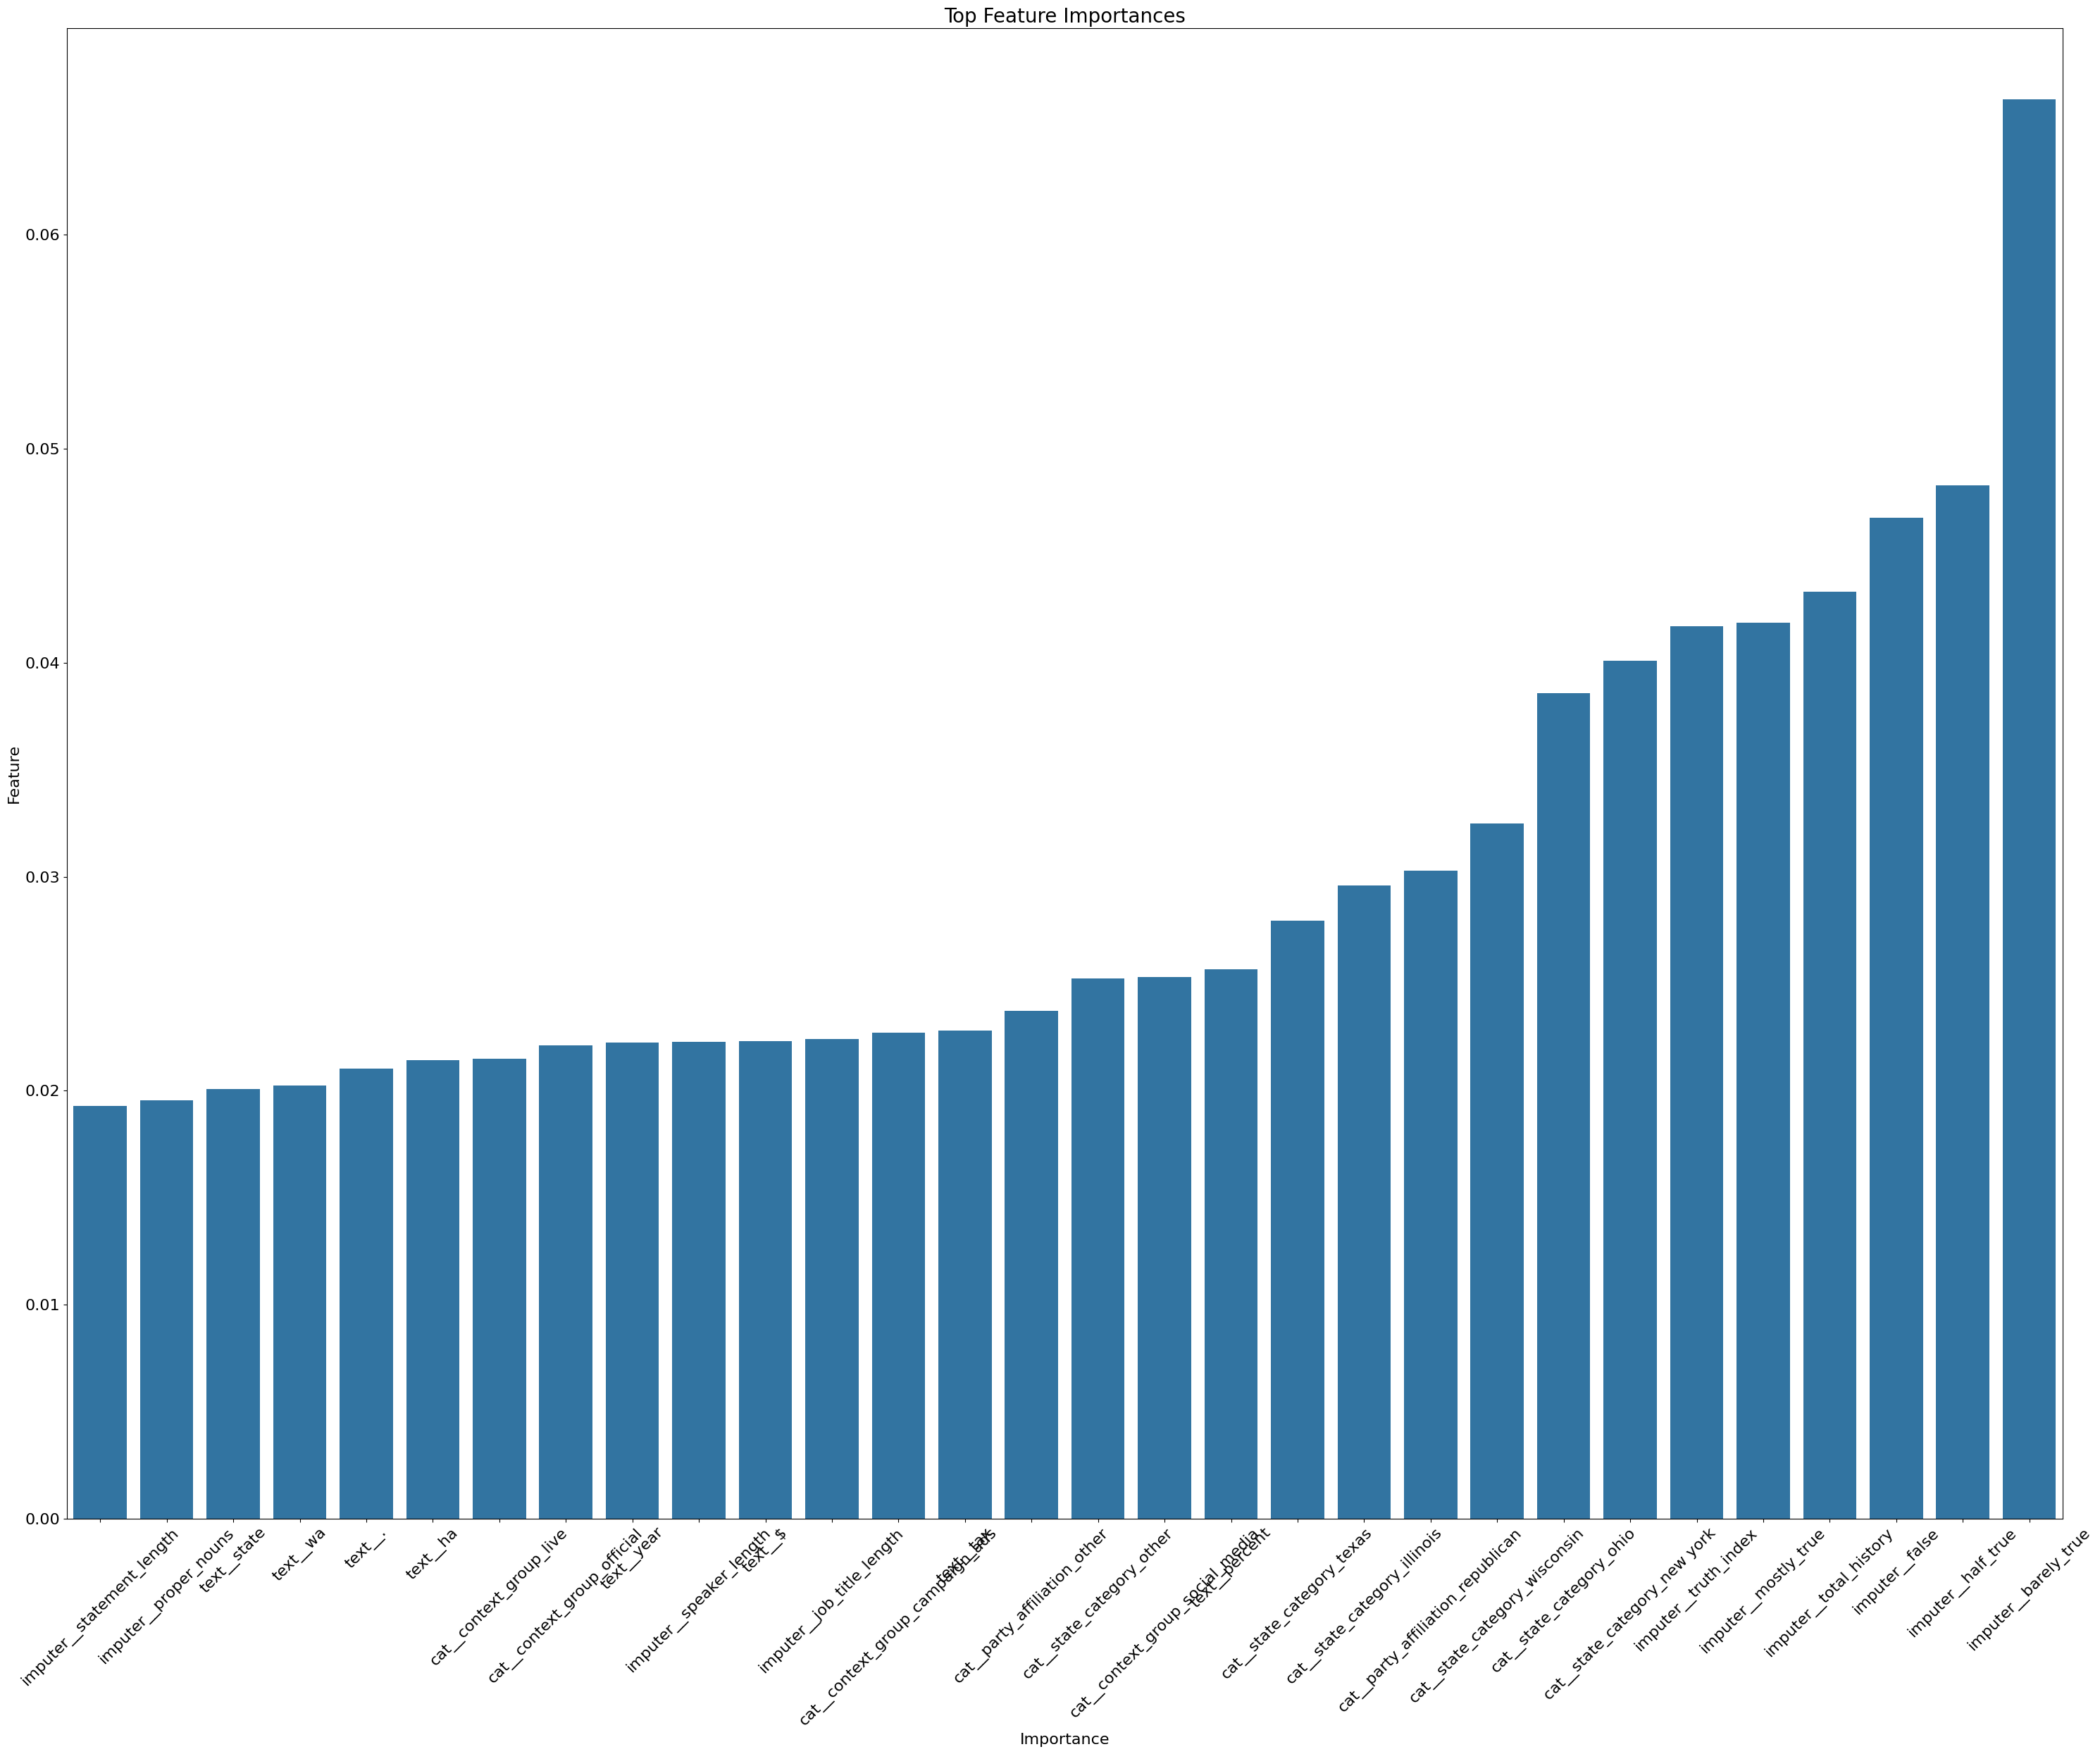

In [78]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
categorical_cols = ['context_group', 'state_category', 'party_affiliation']
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=10), 'statement'),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

We got the same score as our best results till this moment, maybe we should try different vectorization params

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.609


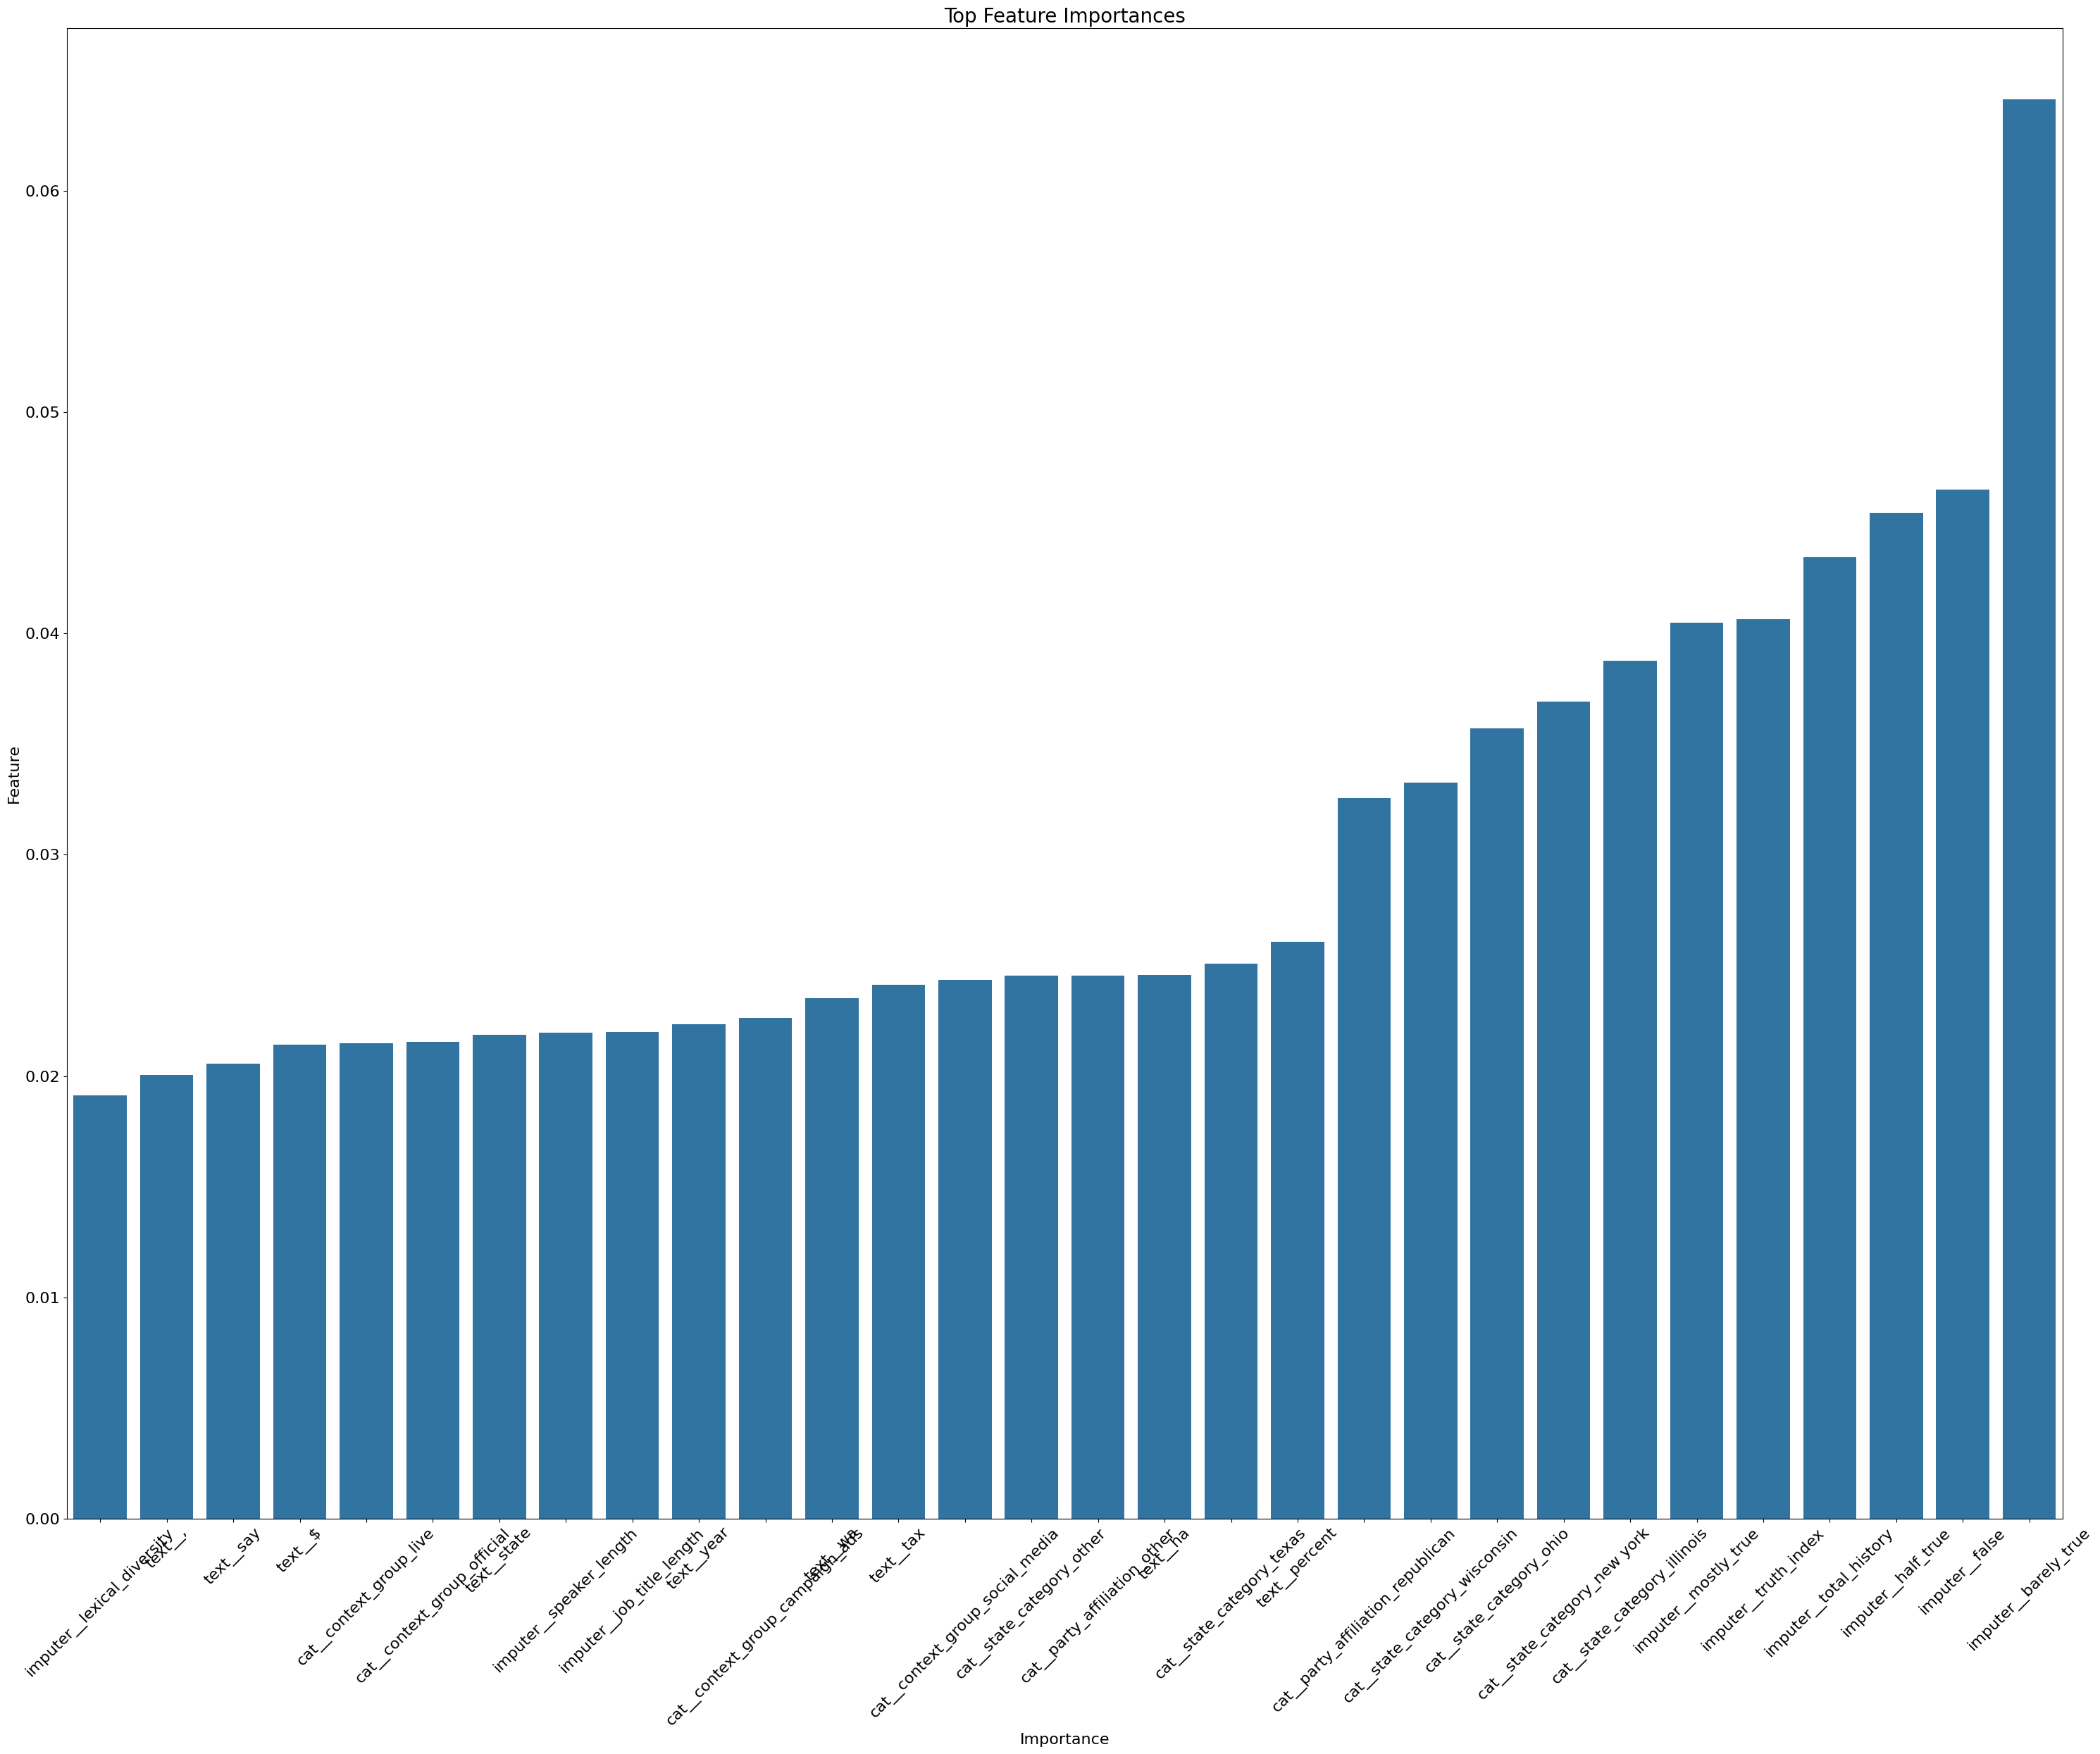

In [79]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
categorical_cols = ['context_group', 'state_category', 'party_affiliation']
preprocessor = ColumnTransformer(transformers=[
    ('text', TfidfVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=10), 'statement'),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

Tfidf gives us worse results

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.630


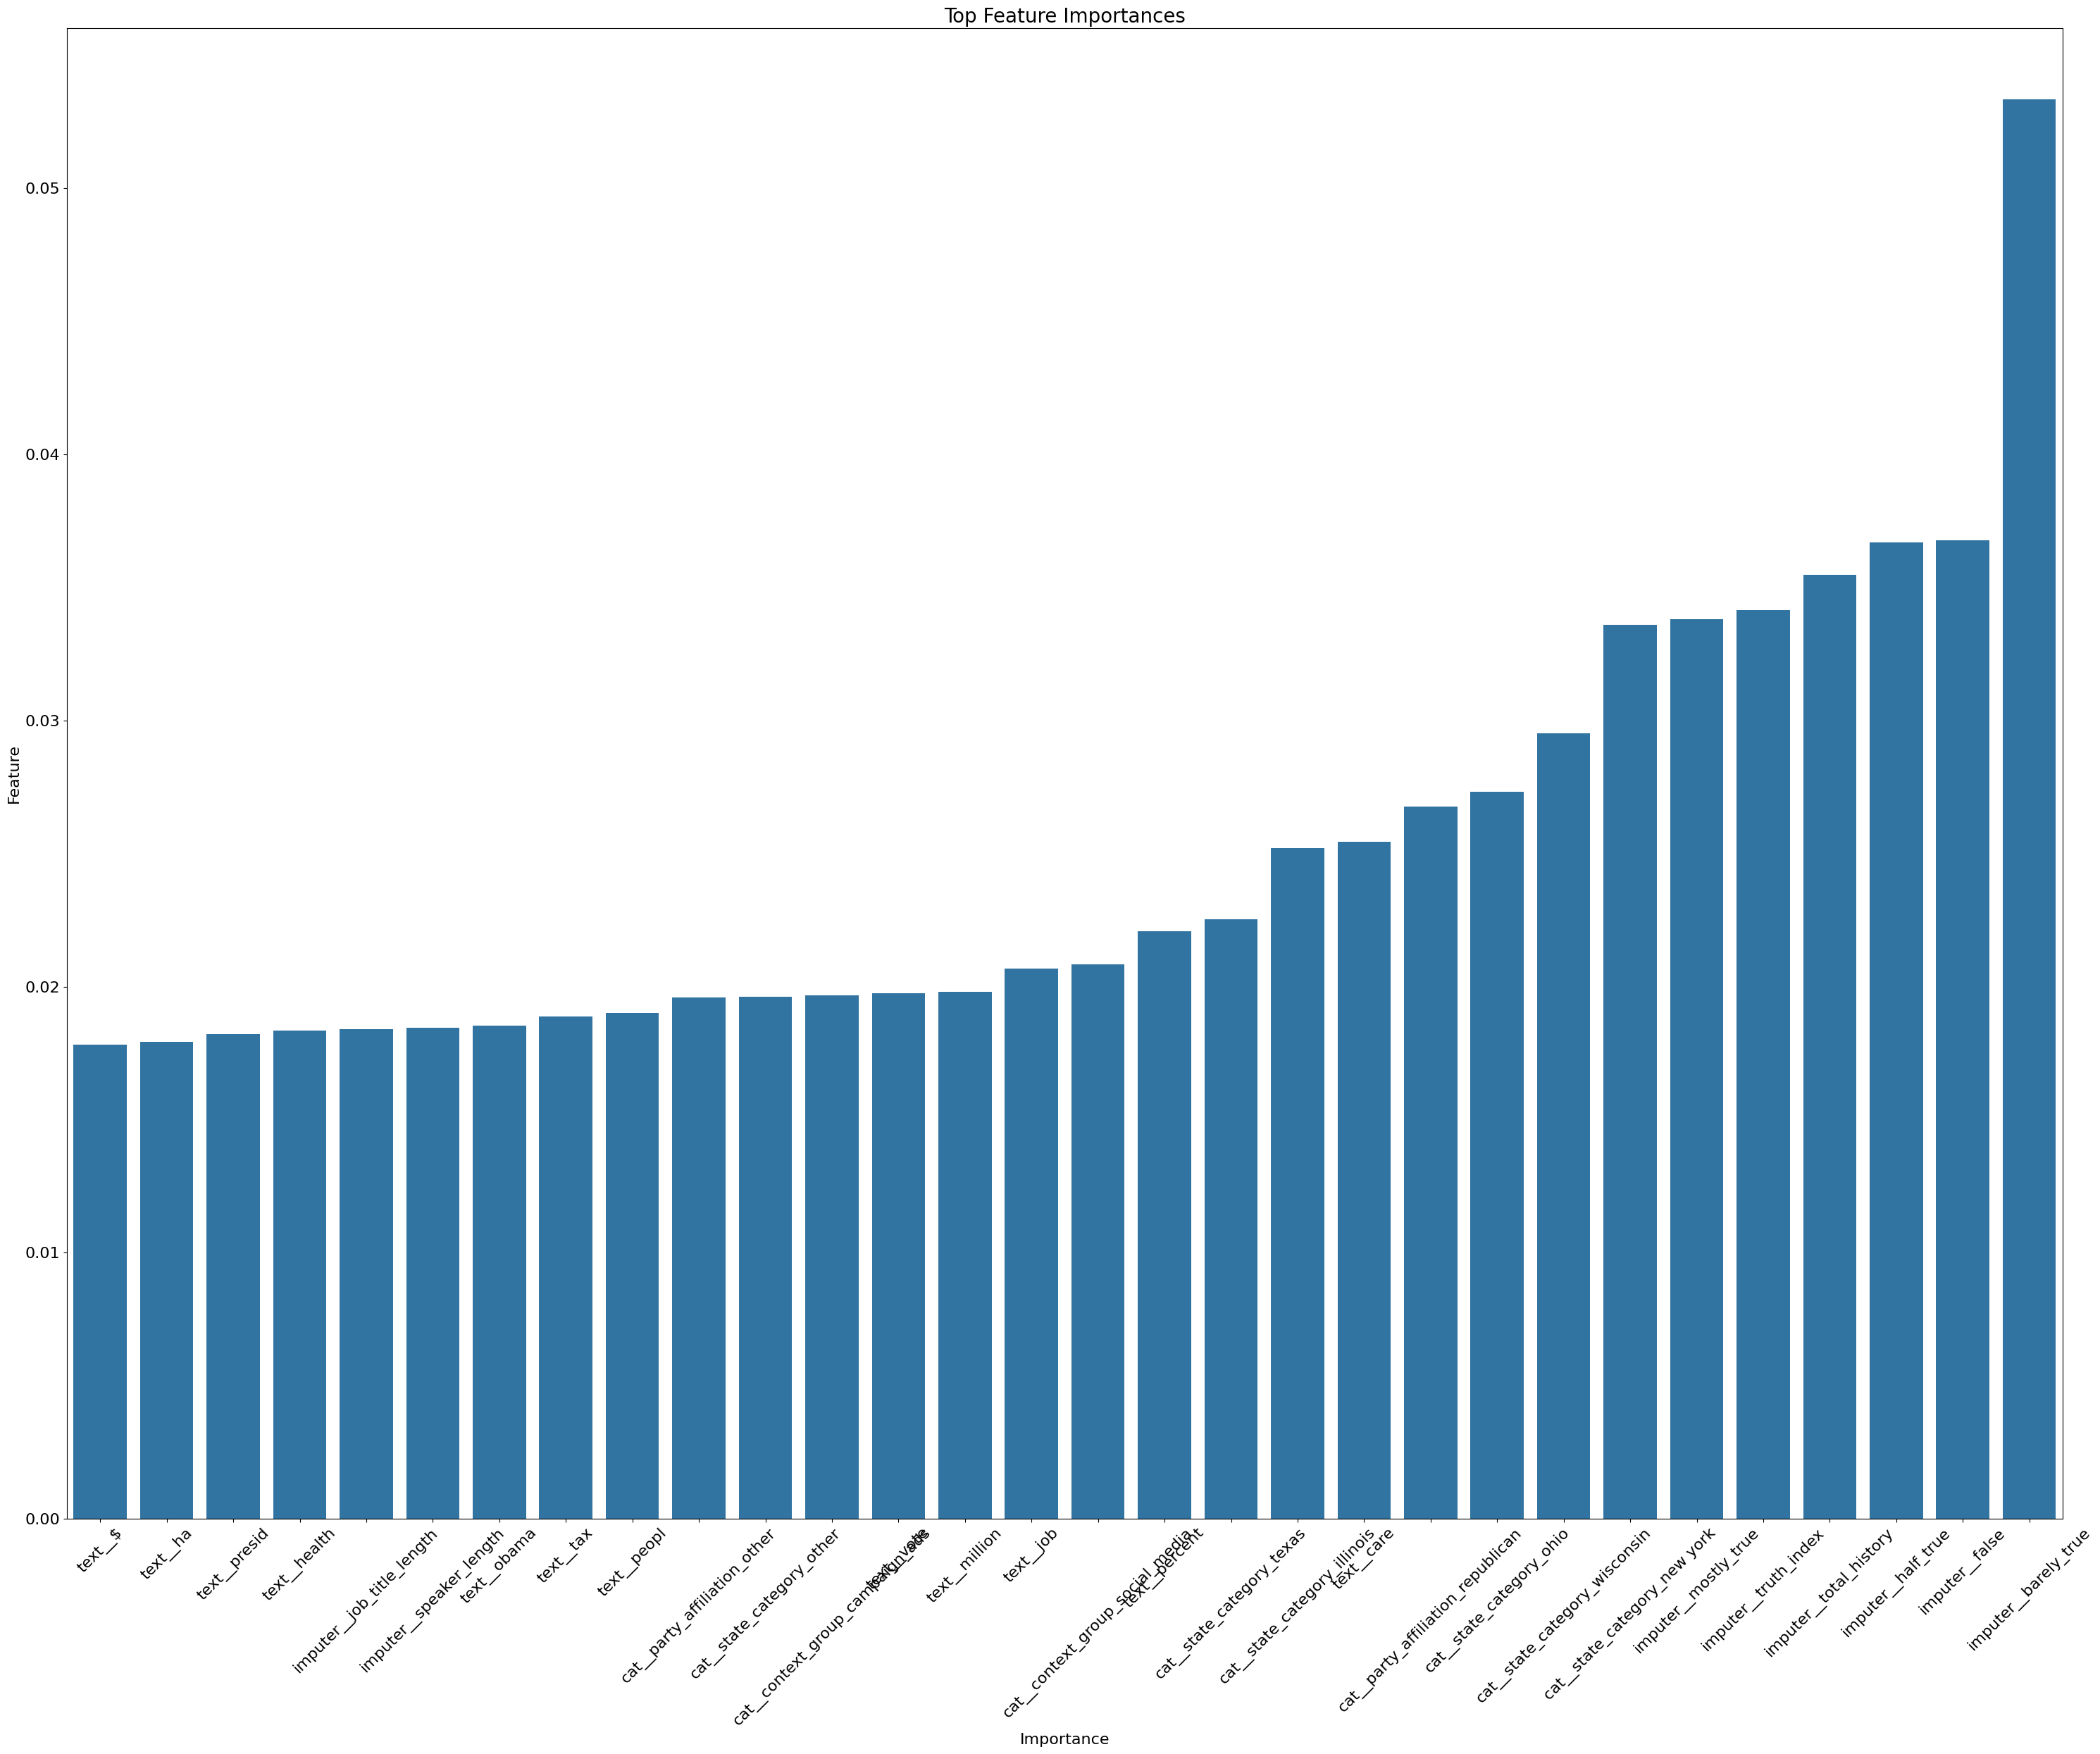

In [80]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
categorical_cols = ['context_group', 'state_category', 'party_affiliation']
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=20), 'statement'),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

Let us remove one of the cat cols

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.626


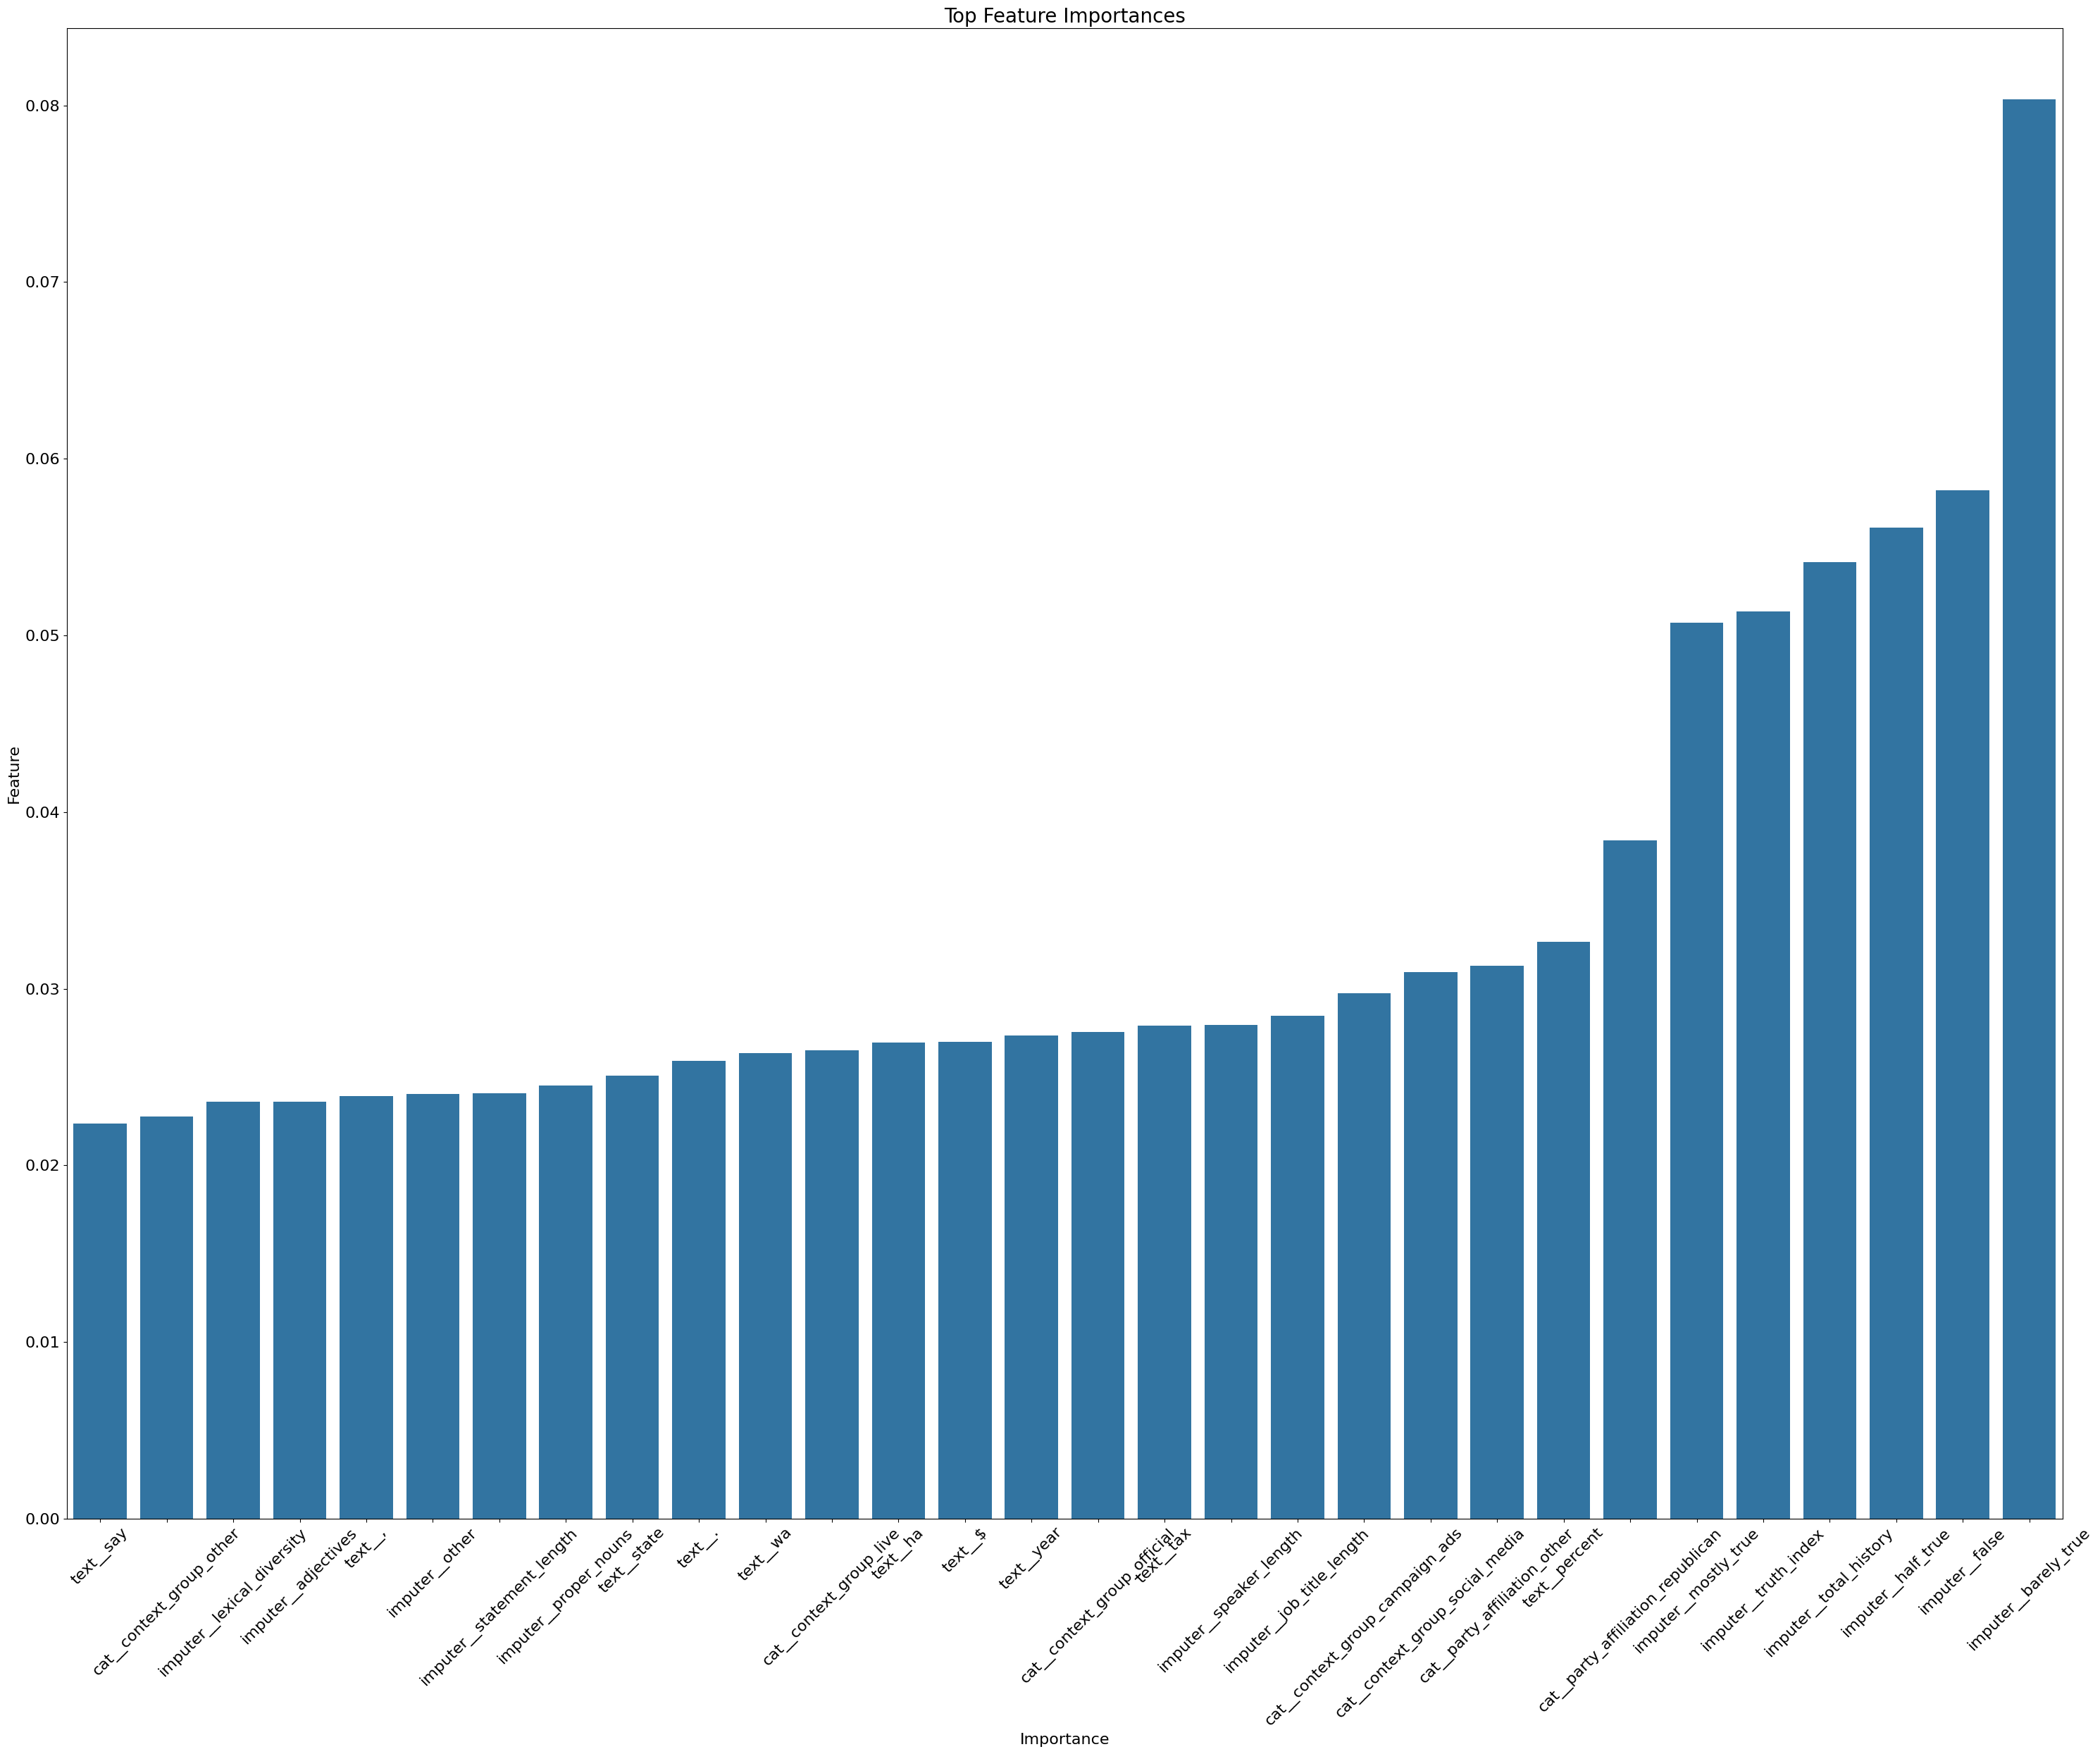

In [81]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
categorical_cols = ['context_group', 'party_affiliation']
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=10), 'statement'),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.637


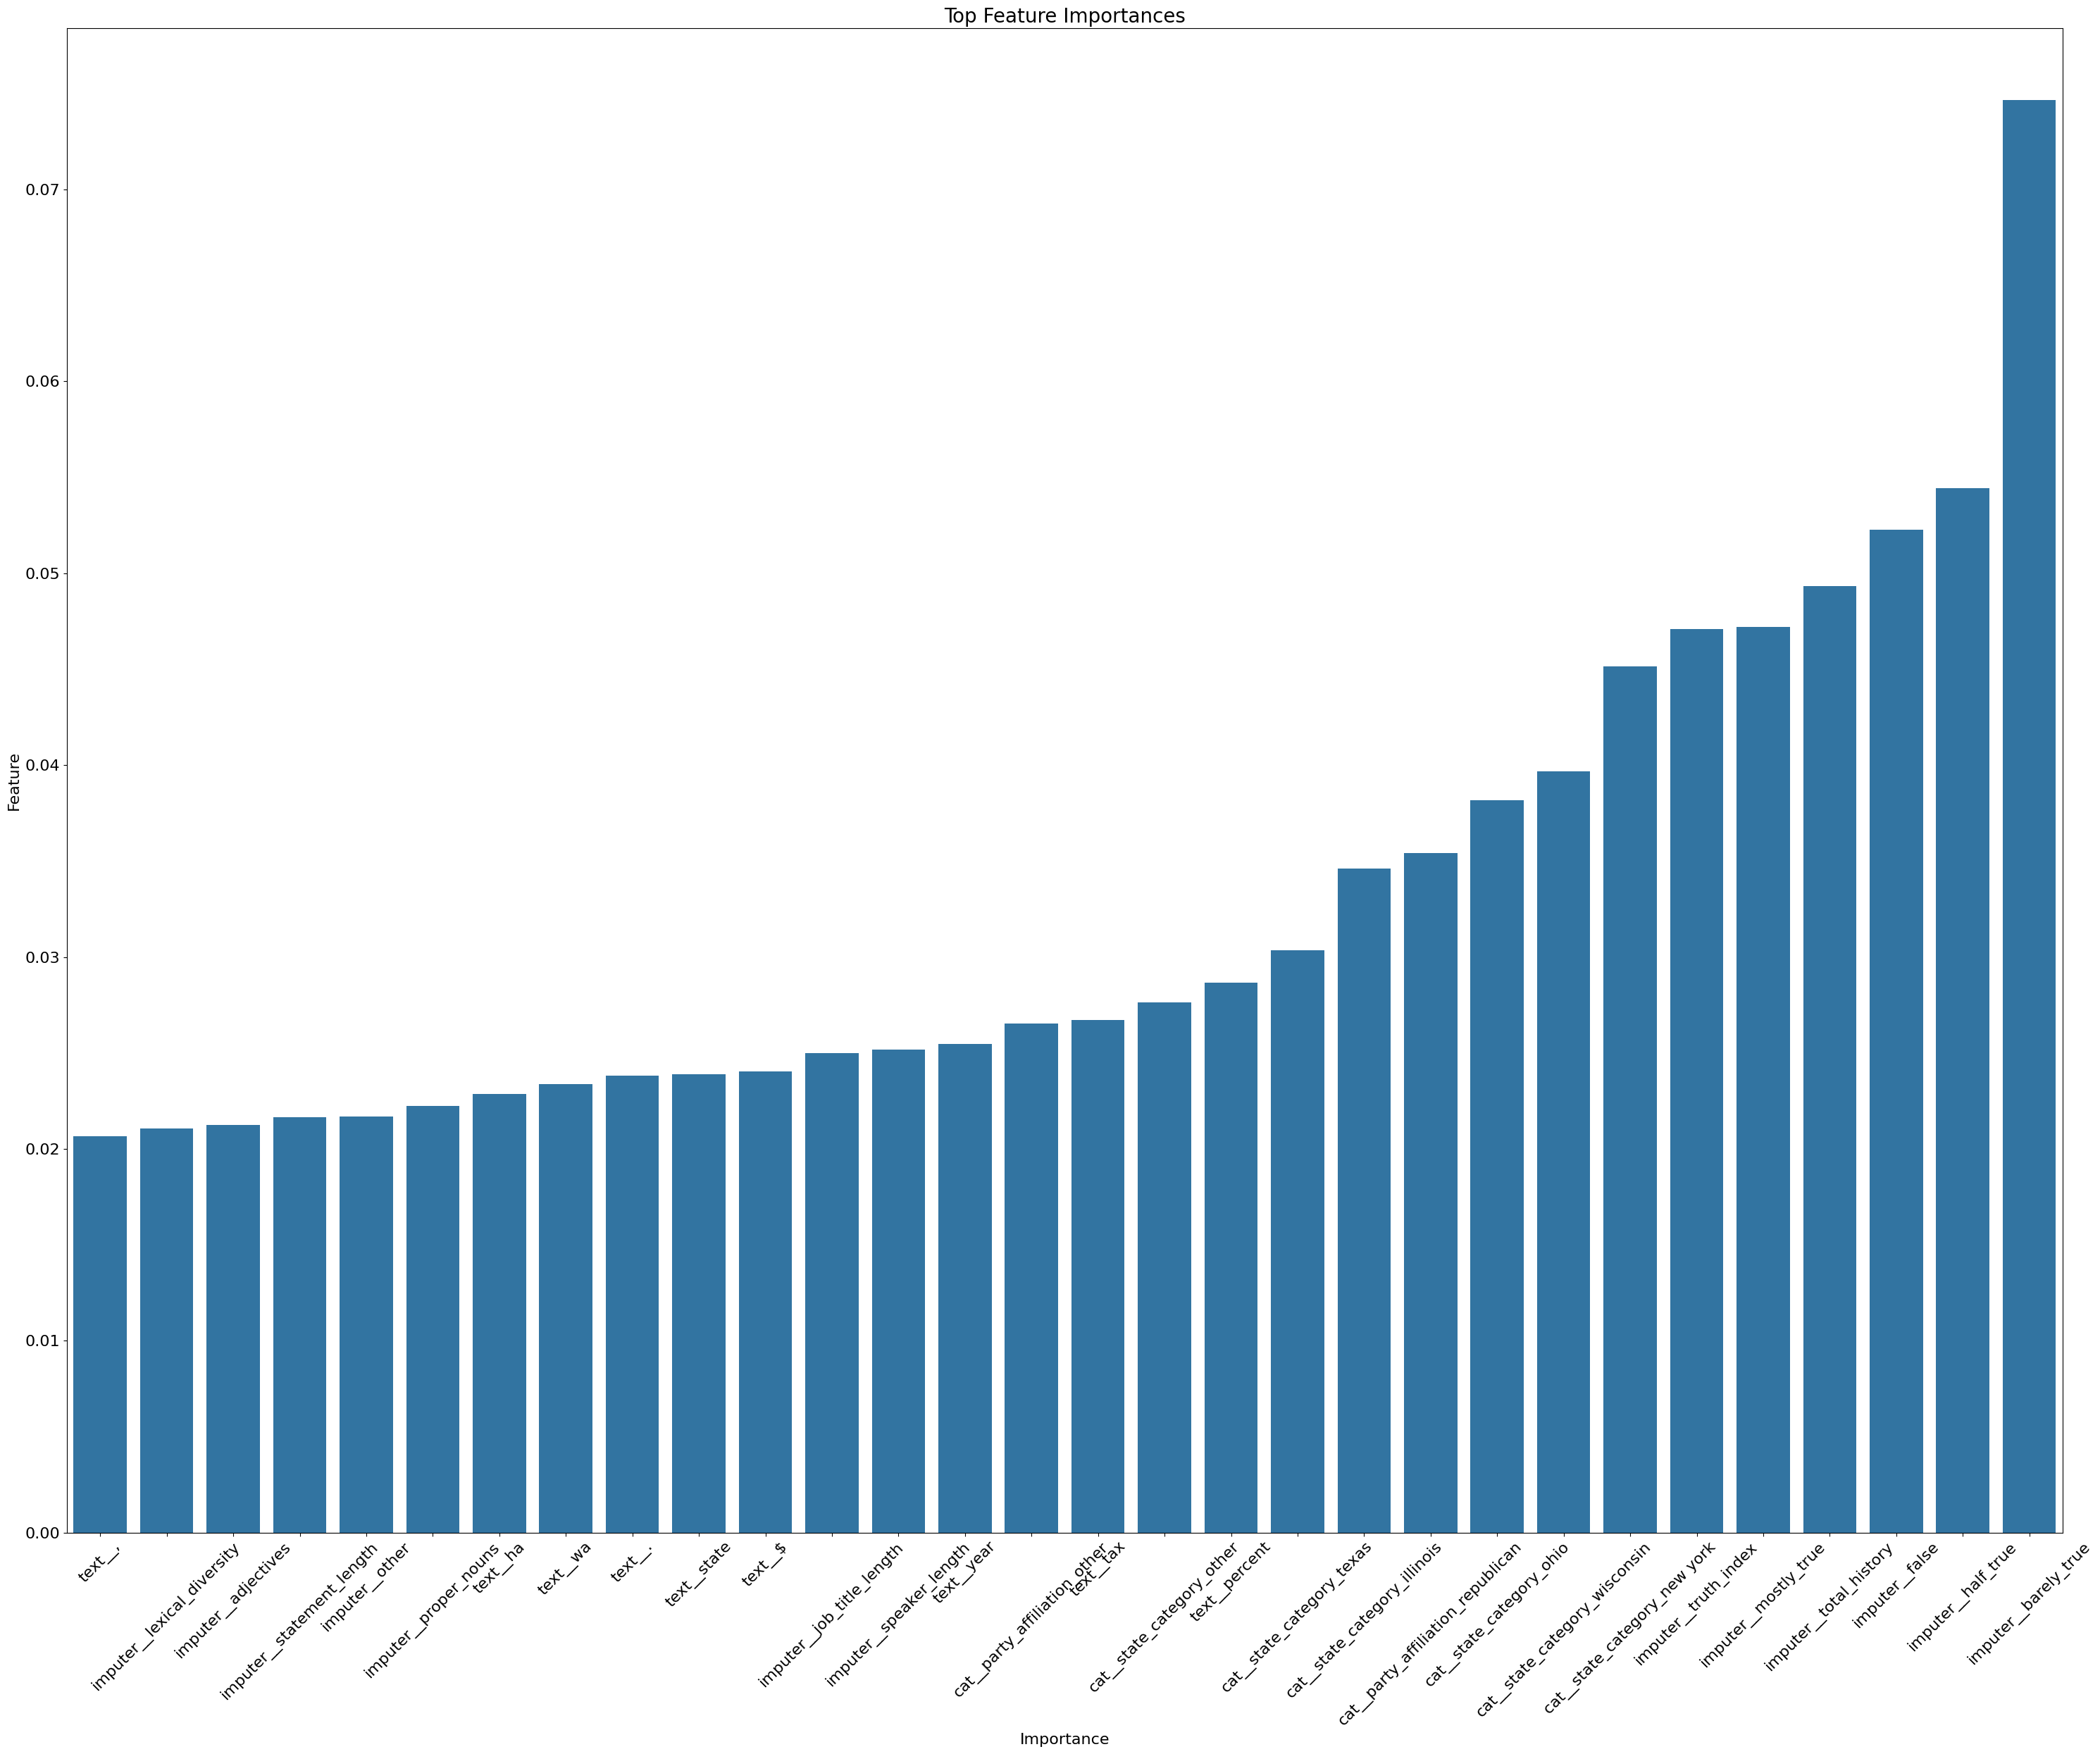

In [82]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
categorical_cols = ['state_category', 'party_affiliation']
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=10), 'statement'),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.640


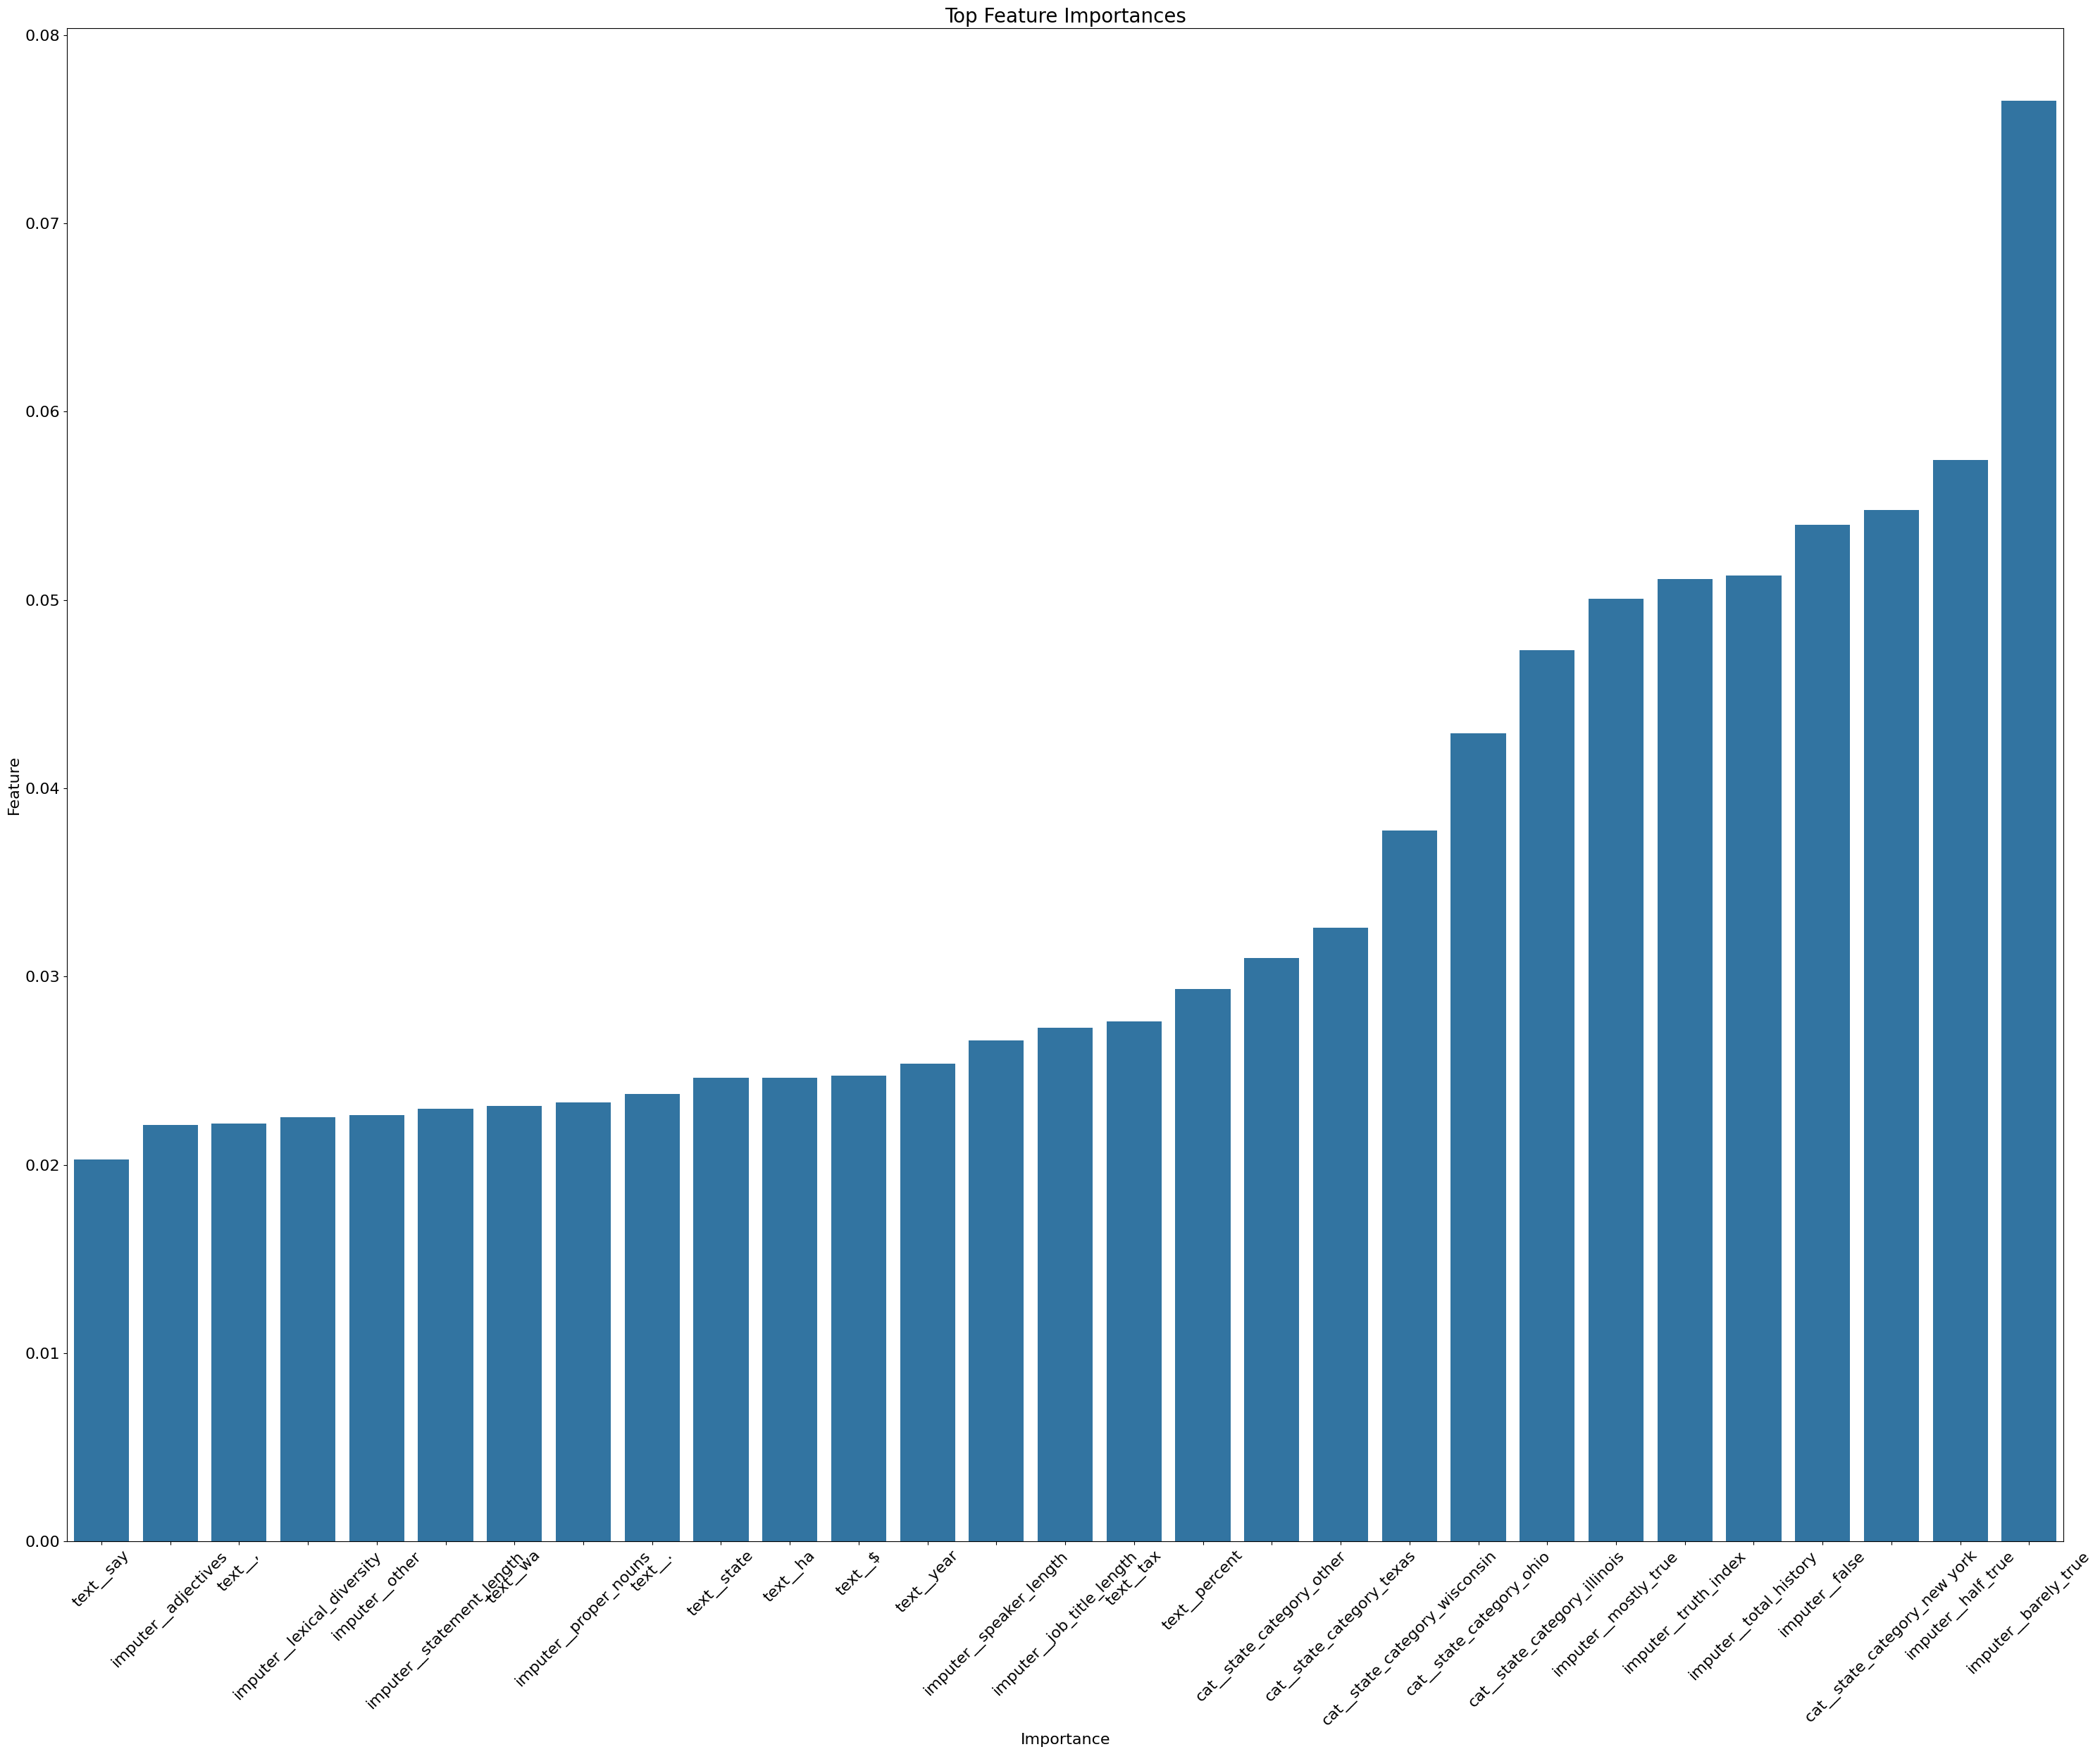

In [83]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
categorical_cols = ['state_category']
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=10), 'statement'),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

This is our best score, what happens if we remove one of the correlated cols, e.g. half_true

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.596


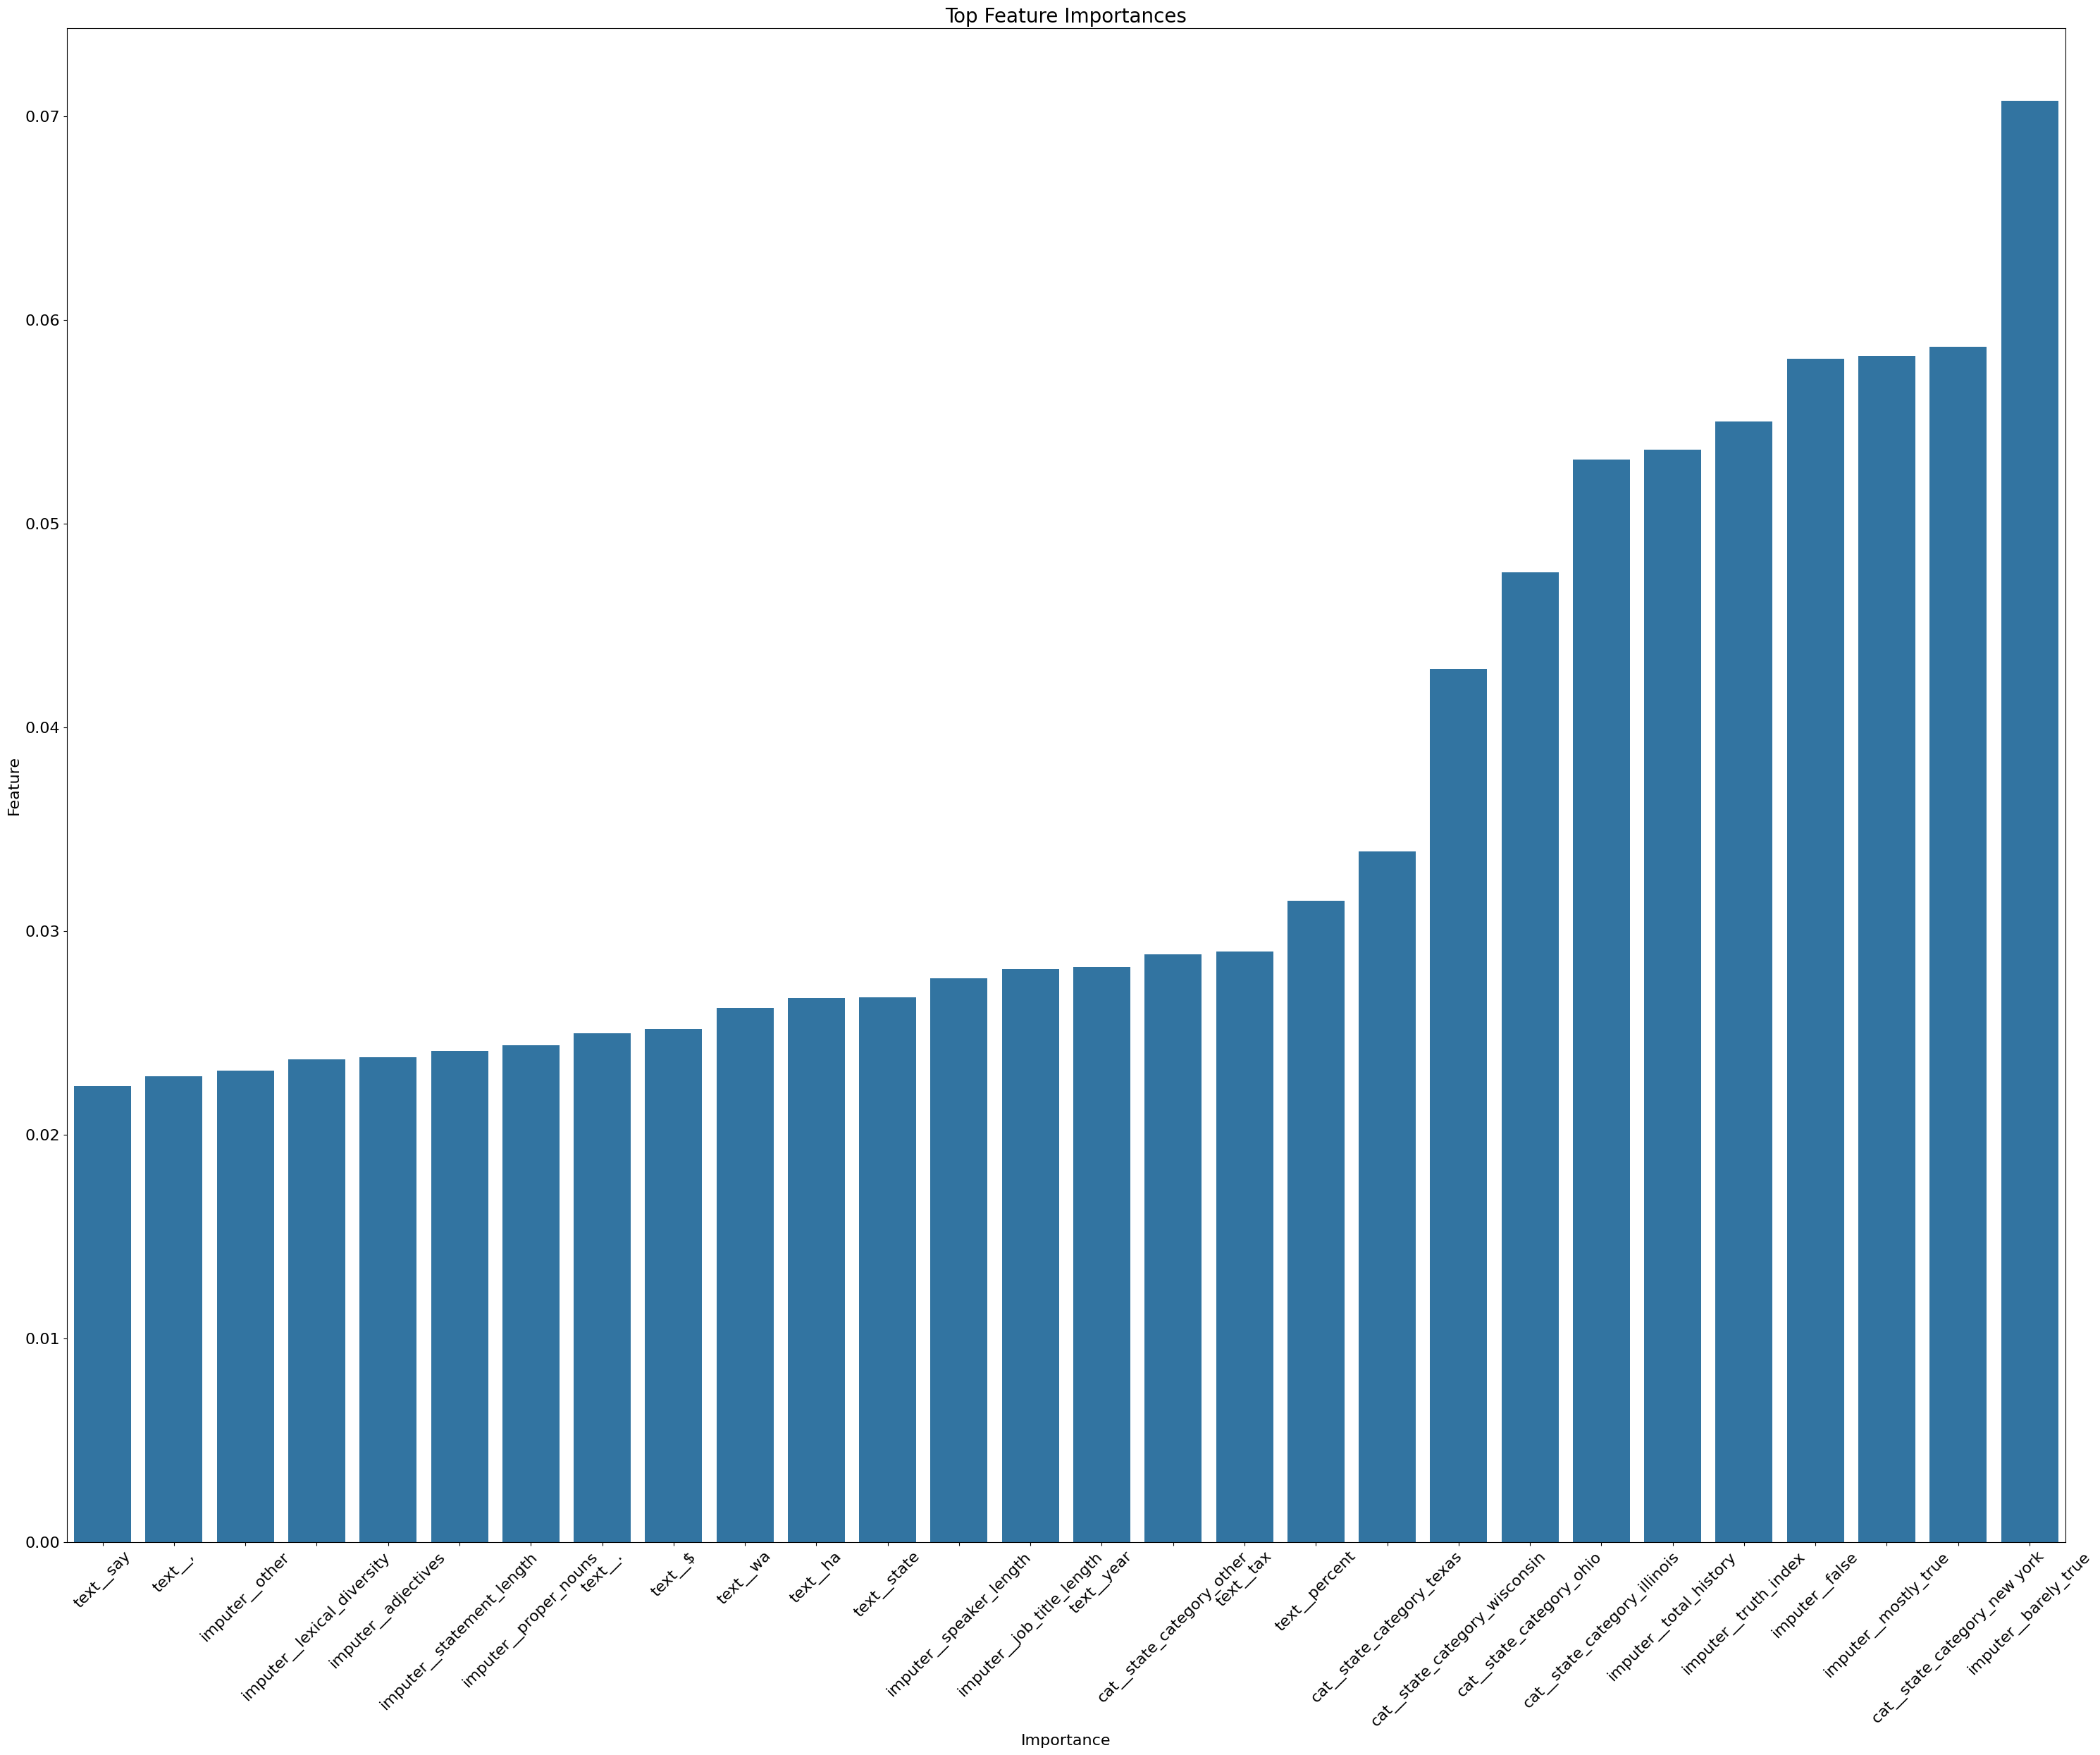

In [85]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('half_true')
categorical_cols = ['state_category']
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=10), 'statement'),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
calculate_metrics(y_test, pipeline.predict(X_test), "XGBoost", pipeline)
plot_feature_importances(pipeline)

Worse results

So our best model actually uses Count Vectorizer and stemming and the top 10 most frequent words.

In [14]:
best_model = XGBClassifier(random_state=42, n_estimators=300, max_depth=10, learning_rate=0.1, subsample=1, n_jobs=-1, num_classes = 6)

d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

F1 Score: 0.640


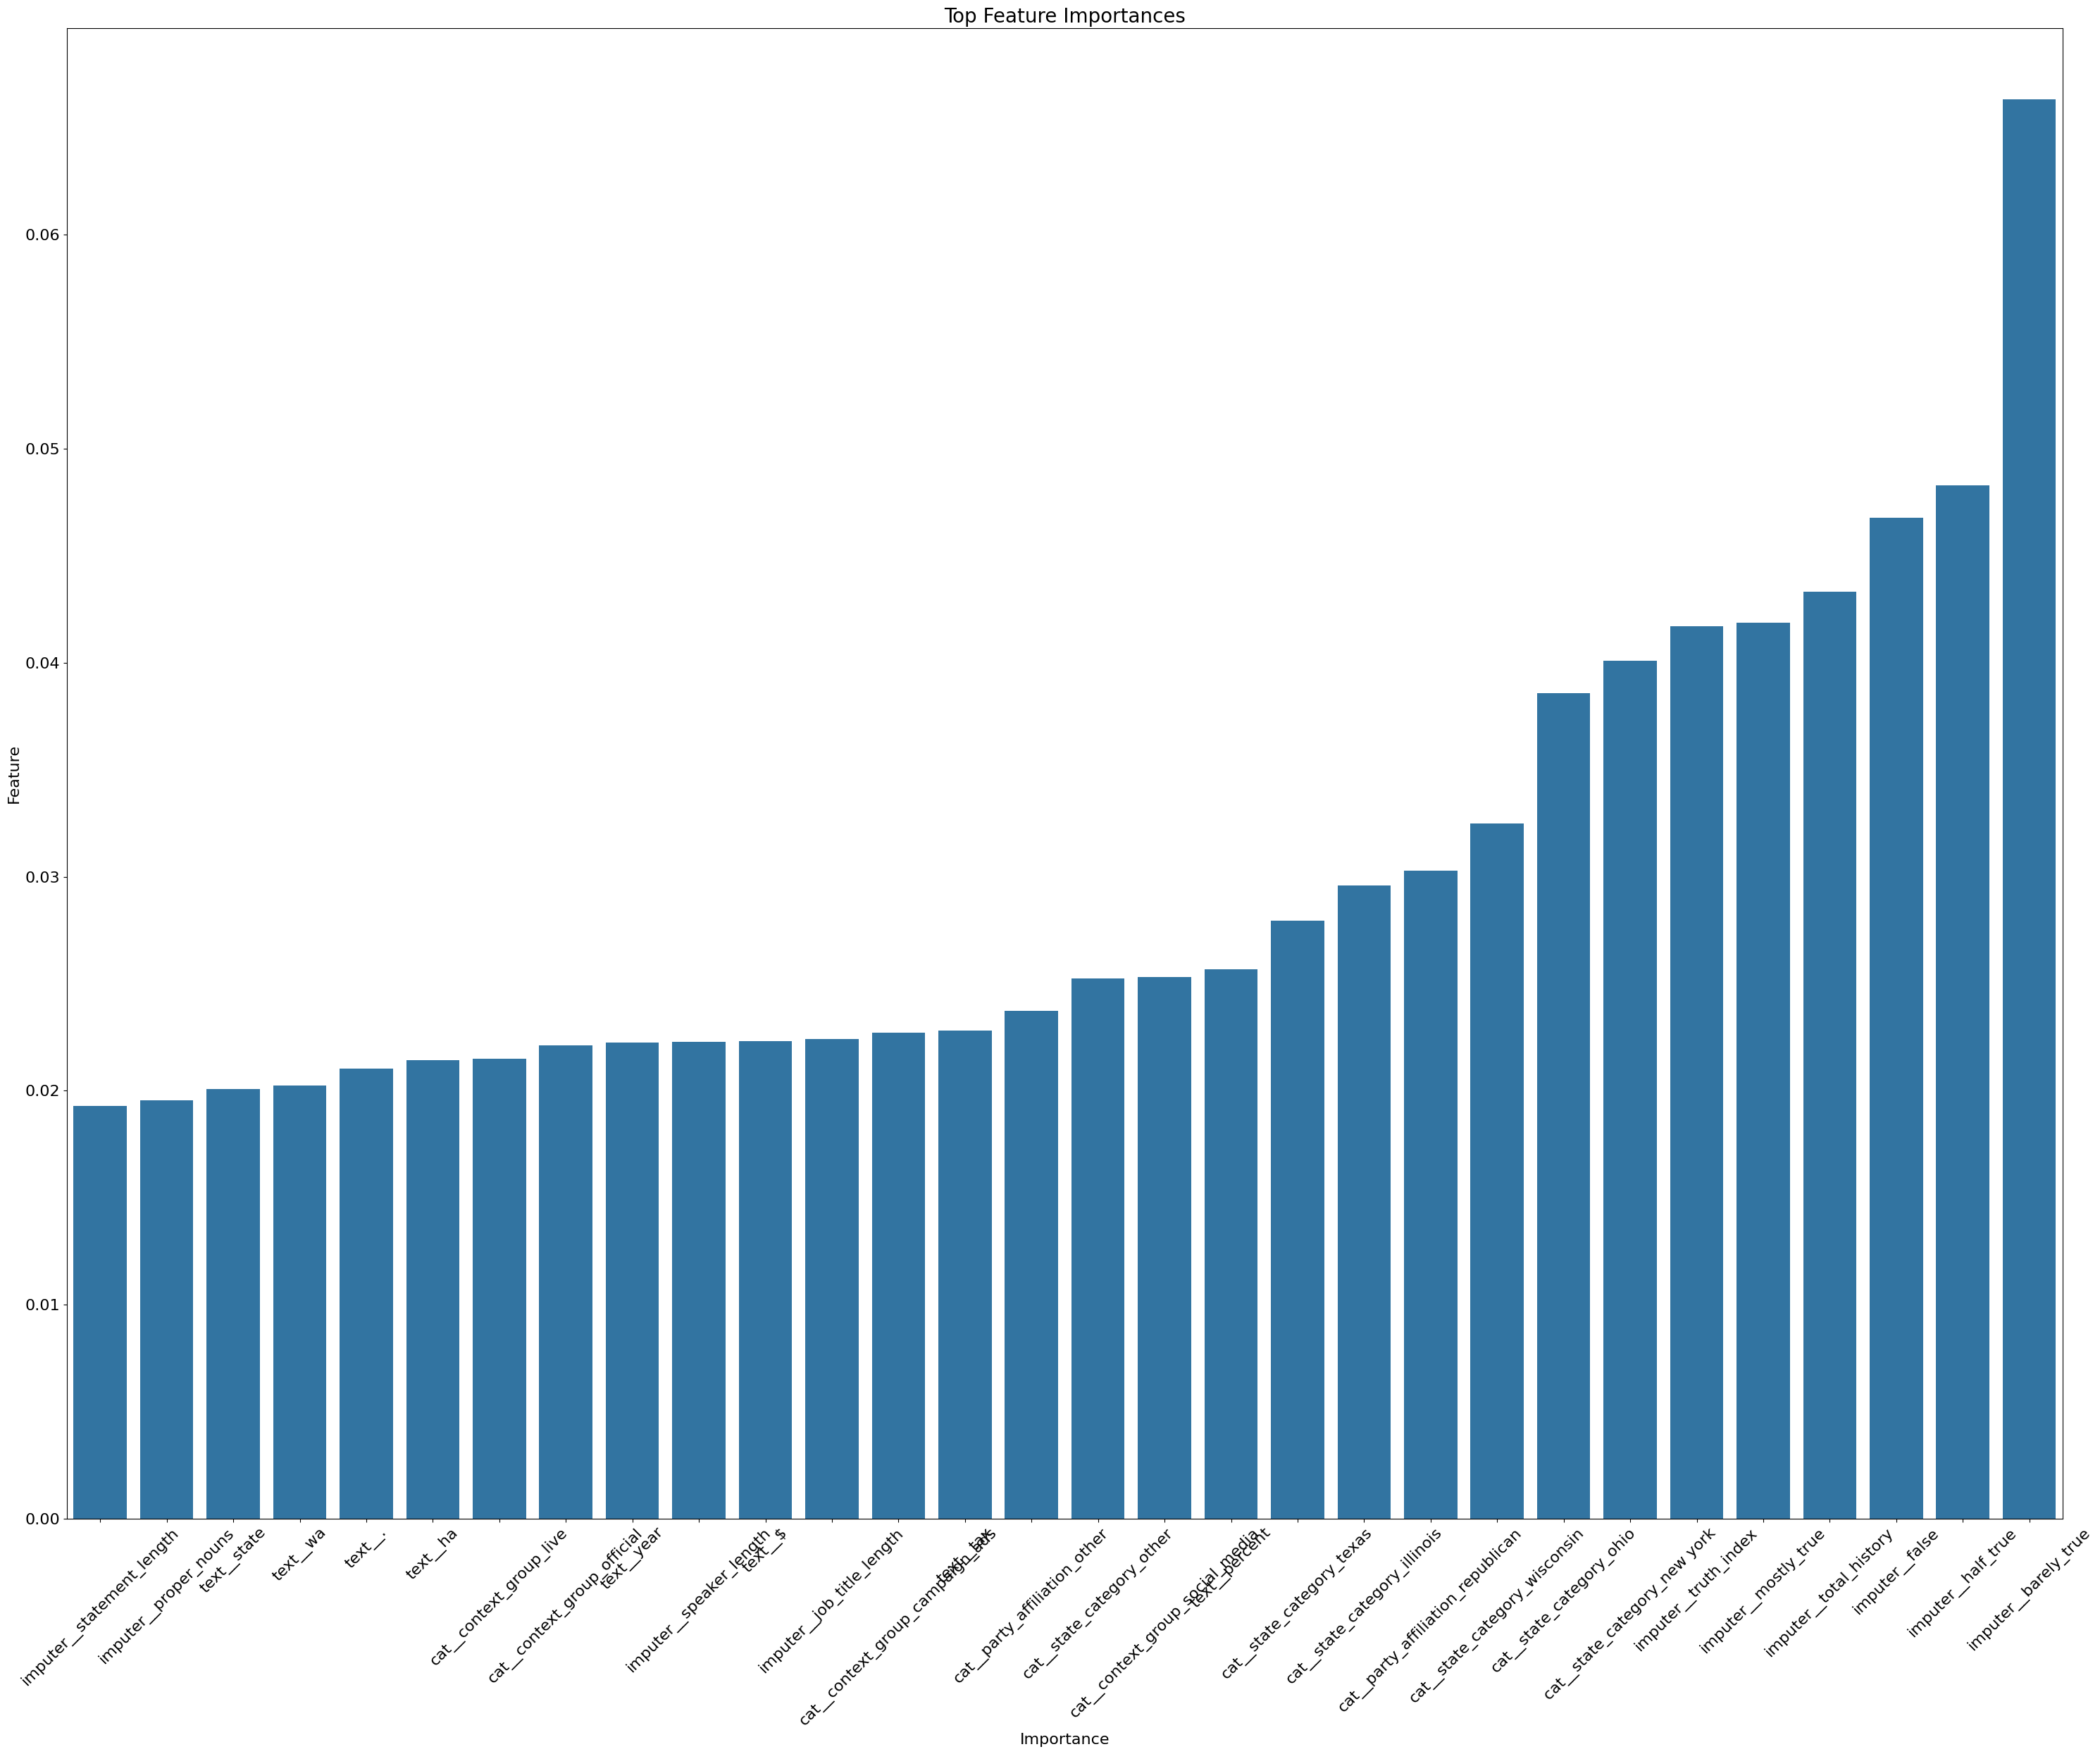

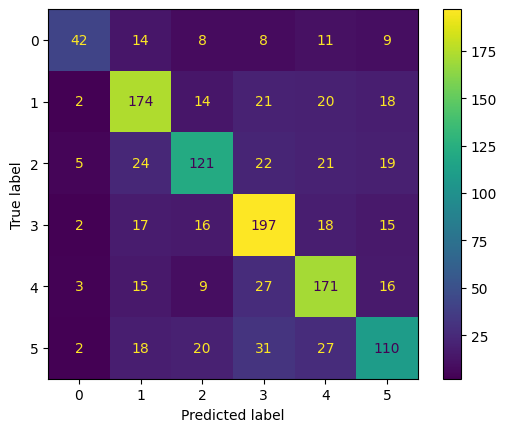

In [20]:
numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
categorical_cols = ['context_group', 'state_category', 'party_affiliation']
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=10), 'statement'),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])
pipeline.fit(X_combined, y_combined)
predictions = pipeline.predict(X_test)
calculate_metrics(y_test, predictions,"XGBoost", pipeline)
plot_feature_importances(pipeline)
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()
plt.show()

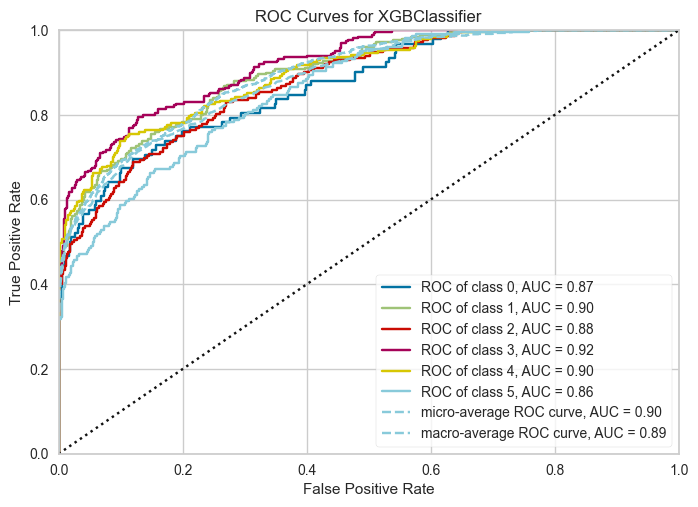

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [26]:
class_names = [
    0,1, 2, 3, 4, 5
]
visualizer = ROCAUC(pipeline, classes=class_names)
visualizer.fit(X_combined, y_combined)
visualizer.score(X_test, y_test)
visualizer.show()

Now we will continue the analysis in the xgboost model report

We will save now our model and will train it on the whole dataset

In [ ]:
X_full = pd.concat([X_combined, X_test], axis=0)
y_full = pd.concat([y_combined, y_test], axis=0)

numerical_cols = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
categorical_cols = ['context_group', 'state_category', 'party_affiliation']
preprocessor = ColumnTransformer(transformers=[
    ('text', CountVectorizer(tokenizer=stemmed_tokenizer,
                             stop_words='english', max_features=10), 'statement'),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
    ('imputer', SimpleImputer(strategy='median'), numerical_cols)],
                                 remainder='drop')

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_model)])

pipeline.fit(X_full, y_full)



d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\ML\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 't

['xgboost_final_pipeline.joblib']

In [35]:
joblib.dump(pipeline, 'xgboost_pipeline.joblib')

['xgboost_pipeline.joblib']